## Import Libraries

In [91]:
# Data Analysis      
import pandas as pd          # data analysis library for handling structured data             
import numpy as np           # mathematical library for working with numerical data
import os, sys

# from metrics import *
# Add the previous directory to sys.path
sys.path.append(os.path.abspath('../'))

# Now you can import the metrics module
from metrics import *
import os 

# Visualization
import matplotlib.pyplot as plt     # data visualization library for creating graphs and charts
%matplotlib inline
import seaborn as sns        # data visualization library based on matplotlib for creating more attractive visualizations
import missingno as msno    #visualize missing data
from sklearn.metrics import mean_squared_error, r2_score 

# Ignore warnings
import warnings
warnings.filterwarnings("ignore") 

pd.set_option('display.max_rows', 50) 
pd.set_option('display.max_columns', 500) 
pd.set_option('display.width', 1000) 


# Function to filter out LightGBM warnings
def suppress_lightgbm_warnings(message, category, filename, lineno, file=None, line=None):
    return 'LightGBM' not in str(message)

warnings.showwarning = suppress_lightgbm_warnings


In [92]:
root_dir = r"C:\Users\pault\OneDrive - University of Oklahoma\GRA - Bio-Manufacturing\1. ML-Cytovance-OU-Research"
os.chdir(root_dir)

## Preprocessing

> Drop invariant columns

In [93]:
# drop invariant columns 
def drop_invariant_columns(df):
    """
    This function takes a list of DataFrames and drops specified invariant columns from each DataFrame.

    Parameters:
    experiment_data (list): List of pandas DataFrames.
    invariant_cols (list): List of column names to be dropped from each DataFrame.

    Returns:
    list: A new list of DataFrames with invariant columns dropped.
    """
    invariant_cols = ['input_vessel_type',	'input_vessel_volume',	'input_vessel_name',	'input_agitation_rpm',	'input_DO_%',	
                  'input_pH_setpoint',	'input_gas_flow',	'input_air_%',	'input_O2',	'input_Temp_c',	'input_media_type',	
                  'input_feed_type',	'input_glucose_limit']
    

    # Create a copy of the DataFrame to avoid modifying the original data.
    updated_df = df.drop(columns=invariant_cols, axis=1)
    return updated_df




> Missing Value Imputation

In [94]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer  
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor    

def convert_WCW_zero(df):
    df['output_WCW_gl'] = df.apply(lambda row: 0 if row['input_Timepoint (hr)'] in [0,1, 2] else row['output_WCW_gl'], axis=1)
    # df['output_WCW_gl'] = df.apply(lambda row: 0 if row.name in [pd.Timestamp("2024-01-01 00:00:00"), pd.Timestamp("2024-01-01 01:00:00"), pd.Timestamp("2024-01-01 02:00:00")] else row['output_WCW_gl'], axis=1)
    return df


# def impute_missing_values_iteratively(X_a): #or (X, Columns)
    
#     X_a = convert_WCW_zero(X_a)
#     X = X_a.copy()
    
#     for col in X.columns: 
#         if X[col].isnull().any() and X[col].dtype == 'object' and col != 'input_Timepoint (hr)':  
#             X[col] = pd.to_numeric(X[col], errors='coerce')

    
#     imputer = IterativeImputer(
#         # estimator = RandomForestRegressor() 
#         estimator=RandomForestRegressor(n_estimators=100, random_state=0), # the estimator to predict the NA
#         initial_strategy='mean', # how will NA be imputed in step 1
#         max_iter=10, # number of cycles
#         imputation_order='ascending', # the order in which to impute the variables
#         n_nearest_features=None, # whether to limit the number of predictors
#         skip_complete=True, # whether to ignore variables without NA
#         random_state=0,)
    
#     # Select columns that are now either originally numeric or successfully converted from object
#     numeric_cols = X.select_dtypes(include=['number']).columns
#     # select only the columns with missing values to be imputed
#     # X_cols = X[columns]
#     X_imputed = imputer.fit_transform(X[numeric_cols]) #or X_cols
#     X_a[numeric_cols] = X_imputed
    
#     return X_a


def impute_missing_values_iteratively(X_a, exclude=None):
    # Convert specific values to zero based on conditions
    X_a = convert_WCW_zero(X_a)
    X = X_a.copy()

    # Normalize the exclude parameter to be a list if it's not None or already a list
    if exclude is not None and not isinstance(exclude, list):
        exclude = [exclude]

    for col in X.columns:
        # Check if column is excluded or if it's 'input_Timepoint (hr)'
        if exclude is not None and col in exclude:
            continue

        # Process columns that are not excluded and meet the conditions
        if X[col].isnull().any() and X[col].dtype == 'object' and col != 'input_Timepoint (hr)':
            X[col] = pd.to_numeric(X[col], errors='coerce')

    imputer = IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=100, random_state=0),  # the estimator to predict the NA
        initial_strategy='mean',  # how will NA be imputed in step 1
        max_iter=10,  # number of cycles
        imputation_order='ascending',  # the order in which to impute the variables
        n_nearest_features=None,  # whether to limit the number of predictors
        skip_complete=True,  # whether to ignore variables without NA
        random_state=0,)

    # Select columns that are now either originally numeric or successfully converted from object
    numeric_cols = [col for col in X.select_dtypes(include=['number']).columns if col not in exclude] if exclude is not None else X.select_dtypes(include=['number']).columns

    # Impute missing values only in the selected numeric columns that are not excluded
    X_imputed = imputer.fit_transform(X[numeric_cols])
    X_a[numeric_cols] = X_imputed

    return X_a 

> Trasforming time variable (using sine and cosine method)

In [95]:

def add_cyclical_time_features(df, time_column, cycle_period):
    """
    Adds cyclical time features to a DataFrame based on a specified time column and cycle period.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the time column.
    - time_column (str): The name of the column in df that contains time values.
    - cycle_period (float): The period of the cycle in the same units as the time column (e.g., 48 hours).

    Returns:
    - pd.DataFrame: A DataFrame with two new columns appended, representing the sine and cosine transformations of the time column.
    """
    
    # Ensure the time column exists in the DataFrame
    if time_column not in df.columns:
        raise ValueError(f"The specified time column '{time_column}' does not exist in the DataFrame.")

    # Apply sine and cosine transformations
    df[f'{time_column}_sin'] = np.sin(2 * np.pi * df[time_column] / cycle_period)
    df[f'{time_column}_cos'] = np.cos(2 * np.pi * df[time_column] / cycle_period)
    # df.drop(columns = time_column, inplace=True)

    return df

# Example usage
# Assuming your DataFrame is named df and the time column is named 'time'
# df_combined_extra = add_cyclical_time_features(df_combined_extra, time_column = 'input_Timepoint (hr)', cycle_period = 48.0)


> Scale and Concat

In [96]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# Use StandardScaler for this
scale_cols = ['output_WCW_gl', 'output_agitation', 'output_air_%', 'output_D0_%', 'output_gasflow', 'output_O2', 'output_Ph', 
              'output_feed_%', 'output_feed', 'output_Temp', 'output_glycerol_gl', 
              'output_glucose_gl', 'output_acetate_mmol_l', 'output_phosphate_mmol_l']

def scale_and_concat(X, columns_to_transform = scale_cols, train = False, scaler = None):
    """
    Scales selected columns in a DataFrame using StandardScaler and concatenates them with the rest of the DataFrame.

    Args:
        df (pandas.DataFrame): The DataFrame containing the data.
        columns_to_transform (list): List of column names to be scaled.

    Returns:
        pandas.DataFrame: The concatenated DataFrame with scaled columns.
    """
    
    # Filter out columns in 'columns_to_transform' that are not present in 'X'
    valid_columns = [col for col in columns_to_transform if col in X.columns]
    
    if train == True:
        # scaler = MinMaxScaler() # Initialize the scaler 
        scaler = StandardScaler()   # Initialize the scaler
        scaler.fit(X[valid_columns])  # Fit only on the training set
    else:
        scaler = scaler

    # Create a copy of the original DataFrame
    df_concatenated = X.copy()

    # Scale the selected columns
    scaled_columns = scaler.transform(X[valid_columns])

    # Create a DataFrame with the scaled columns
    df_scaled = pd.DataFrame(scaled_columns, columns=valid_columns, index=X.index)
            
    # Concatenate the scaled columns with the rest of the DataFrame
    df_concatenated = pd.concat([df_concatenated.drop(columns=valid_columns, axis = 1), df_scaled], axis=1)

    if train == True:
        return df_concatenated, scaler
    else:
        return df_concatenated
    



## Building the Model

> Polynomial Feature Extraction

In [97]:
from sklearn.preprocessing import PolynomialFeatures

# Select the most important features
important_features = ['output_WCW_gl', 'output_phosphate_mmol_l', 'output_gasflow', 
                      'output_agitation', 'output_feed_%', 'output_glycerol_gl', 'output_glucose_gl', 
                      'input_Timepoint (hr)_sin', 'input_Timepoint (hr)_cos']


def add_polynomial_features_sklearn(X_train, X_test, degree=2, columns=None, prefix='poly_'):
    """
    Adds polynomial features up to a specified degree to a subset of columns in training and testing Pandas DataFrames.
    
    Parameters:
        X_train (Pandas DataFrame): The training DataFrame.
        X_test (Pandas DataFrame): The testing DataFrame.
        degree (int): The maximum degree of polynomial features to generate.
        columns (list of str): The names of the columns to generate polynomial features for.
        prefix (str): Prefix for the new polynomial feature columns.
        
    Returns:
        tuple: A tuple containing the new training and testing DataFrames with added polynomial features.
    """
    if columns is None:
        # Optionally, define default columns if none provided, or remove this block
        columns = X_train.columns  # This will include all columns if not specified

        # Filter out columns in 'columns_to_transform' that are not present in 'X'
    valid_columns = [col for col in columns if col in X_train.columns]
    
    # Extract the specified columns for transformation
    X_train_subset = X_train[valid_columns]
    X_test_subset = X_test[valid_columns]

    # Initialize PolynomialFeatures transformer
    poly = PolynomialFeatures(degree=degree, include_bias=False)

    # Fit and transform the training data
    X_train_poly = poly.fit_transform(X_train_subset)
    # Transform the test data based on the fitted transformer
    X_test_poly = poly.transform(X_test_subset)

    # Generate new column names
    poly_feature_names = [prefix + name for name in poly.get_feature_names_out(valid_columns)]

    # Create DataFrames for polynomial features
    poly_train_df = pd.DataFrame(X_train_poly, columns=poly_feature_names, index=X_train_subset.index)
    poly_test_df = pd.DataFrame(X_test_poly, columns=poly_feature_names, index=X_test_subset.index)

    # Concatenate polynomial features with the original DataFrames excluding transformed columns
    new_X_train = pd.concat([X_train.drop(columns=valid_columns), poly_train_df], axis=1)
    new_X_test = pd.concat([X_test.drop(columns=valid_columns), poly_test_df], axis=1)

    return new_X_train, new_X_test, poly 




> Feature Selection

In [98]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

def feature_selection_with_model(X_train, y_train, X_test, threshold=None):
    """
    Performs feature selection using a model-based method on the training set
    and applies the same selection to the test set.

    Args:
        X_train (DataFrame): Training features.
        y_train (Series): Training target.
        X_test (DataFrame): Test features.
        threshold (str or float, optional): The threshold value to use for feature selection.
            If 'median' (string), select features whose importance is greater than the median.
            If None, uses the default threshold of the model. Defaults to None.

    Returns:
        X_train_selected (DataFrame): Training set with selected features.
        X_test_selected (DataFrame): Test set with selected features.
        selected_features (list): List of selected feature names.
    """
    # Initialize the model you want to use for feature selection
    model = RandomForestRegressor(random_state=42)

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Initialize SelectFromModel with the fitted model and threshold
    selector = SelectFromModel(model, threshold=threshold, prefit=True)

    # Transform the training and test sets using the selector
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    # Get the selected feature names
    selected_features = X_train.columns[selector.get_support()]

    # Transform back to DataFrames for compatibility with the rest of your code
    X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train.index)
    X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features, index=X_test.index)

    return X_train_selected, X_test_selected, selector # Return the final DataFrames and the selector object








from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor  # Or any other suitable estimator

def feature_selection_rfe(X_train, y_train, X_test, num_features_to_select = None):
    """
    Performs feature selection using Recursive Feature Elimination (RFE) on the training set and applies the selection to both training and test sets.

    Args:
        X_train (pd.DataFrame): The training features.
        y_train (pd.Series): The training target variable.
        X_test (pd.DataFrame): The test features.
        num_features_to_select (int): The number of features to select with RFE.

    Returns:
        X_train_selected (pd.DataFrame): The transformed training set with selected features.
        X_test_selected (pd.DataFrame): The transformed test set with selected features.
    """
    # Initialize the base estimator for RFE
    estimator = RandomForestRegressor()

    # Initialize RFE with the chosen estimator and number of features to select
    rfe = RFE(estimator, n_features_to_select=num_features_to_select, step=1)

    # Fit RFE on the training data
    rfe.fit(X_train, y_train)

    # Transform training and test sets to contain only the selected features
    X_train_selected = rfe.transform(X_train)
    X_test_selected = rfe.transform(X_test)

    # Retrieve the names of the selected features to maintain a DataFrame structure
    selected_features = X_train.columns[rfe.support_]

    # Convert the arrays back to DataFrames for compatibility and readability
    X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train.index)
    X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features, index=X_test.index)

    return X_train_selected, X_test_selected, rfe






> Model Selection

In [99]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


# Assuming y_train and X_train are defined and contain your training data
def fit_sarimax_model(X_train, y_train, X_test, y_test):
    # Define the model
    model = SARIMAX(
        y_train, exog=X_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)
    )
    # Fit the model
    model_fit = model.fit()
    y_pred = model_fit.get_forecast(
        steps=len(X_test), exog=X_test
    ).predicted_mean.values
    
    mse = mean_squared_error(y_test, y_pred, squared=True)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    # print(f"Mean Squared Error for SARIMAX: {mse}")
    # print(f"Root Mean Squared Error for SARIMAX: {rmse}")
    # print(f"R2 for SARIMAX: {r2}")
    return mse, rmse, r2, model_fit 


# Function for XGBoost regression
def train_evaluate_xgboost(X_train, y_train, X_test, y_test, params = None, fold_index = None):
    # Instantiate the XGBoost regressor with the given parameters
    if params is not None:
            xg_reg = xgb.XGBRegressor(**params)
    else:
        xg_reg = xgb.XGBRegressor()
        
    xg_reg.fit(X_train, y_train)

    # Predictions
    y_pred = xg_reg.predict(X_test)

    # Evaluate the performance
    mse = mean_squared_error(y_test, y_pred, squared=True)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    # print(f"Mean Squared Error for XGBoost: {mse}")
    # print(f"Root Mean Squared Error for XGBoost: {rmse}")
    # print(f"R2 for XGBoost: {r2}")
    
    # Collecting model information
    model_info = {'Model Name': xg_reg.__class__.__name__,
                  'Mean Squared Error': mse, 
                  'Root Mean Squared Error': rmse, 
                  'R2 Score': r2}
    
    print(f"Mean Squared Error for XGBoost: {mse}")
    print(f"Root Mean Squared Error for XGBoost: {rmse}")
    print(f"R2 Score for XGBoost: {r2}")
    print(' ')
        
    if hasattr(xg_reg, 'get_params'):  # Check if the model has 'get_params' method
        model_params = xg_reg.get_params()
        model_info['Model Parameters'] = model_params
    else:
        model_info['Model Parameters'] = "Not accessible for this model type."

    # Include cross-validation fold index if provided
    if fold_index is not None:
        model_info['Cross-Validation Fold Index'] = fold_index
    return model_info, xg_reg


# Function for Multiple Linear Regression
# def train_evaluate_linear_regression(X_train, y_train, X_test, y_test):

#     # Instantiate the Linear Regression model
#     lin_reg = LinearRegression()
#     lin_reg.fit(X_train, y_train)

#     # Predictions
#     y_pred = lin_reg.predict(X_test)

#     # Evaluate the performance
#     mse = mean_squared_error(y_test, y_pred, squared=True)
#     rmse = np.sqrt(mse)
#     r2 = r2_score(y_test, y_pred)
    # print(f"Mean Squared Error for Linear Regression: {mse}")
    # print(f"Root Mean Squared Error for Linear Regression: {rmse}")
    # print(f"R2 for Linear Regression: {r2}")
#     return mse, rmse, r2, lin_reg


from pycaret.regression import *
from pycaret.regression import setup, compare_models, create_model, tune_model, plot_model, evaluate_model, save_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, r2_score

def pycaret_model_2(X_train, y_train, X_test, y_test, fold_index=None):
    # Combine X and y into a single DataFrame for PyCaret setup
    train_df = pd.concat([X_train, y_train], axis=1)
    test_df = X_test.copy()
    
    # Setup PyCaret environment
    exp_reg = setup(data=train_df, target=y_train.name, session_id=123, fold_shuffle = False,
                    preprocess=False, verbose=False, data_split_shuffle = False, 
                    use_gpu = True)

    # Compare models and select the best one based on a specified metric, for example, 'RMSE'
    best_model = compare_models(exclude=['lightgbm'], sort='RMSE', cross_validation=False, verbose=False)

    # Train the best model on the entire training set
    final_model = finalize_model(best_model)
    
    # Predict on test set
    predictions = predict_model(final_model, data=test_df, verbose=False) 

    # Evaluate predictions
    mse = mean_squared_error(y_test, predictions['prediction_label'])
    rmse = np.sqrt(mse) 
    r2 = r2_score(y_test, predictions['prediction_label']) 
    
    # Collecting model information
    model_info = {'Model Name': best_model.__class__.__name__,
                  'Mean Squared Error': mse, 
                  'Root Mean Squared Error': rmse, 
                  'R2 Score': r2}
    
    # Display evaluation metrics
    print(f"Mean Squared Error for PyCaret: {mse}")
    print(f"Root Mean Squared Error for PyCaret: {rmse}")
    print(f"R2 Score for PyCaret: {r2}")
    print(' ')
    if hasattr(best_model, 'get_params'):  # Check if the model has 'get_params' method
        model_params = best_model.get_params()
        model_info['Model Parameters'] = model_params
    else:
        model_info['Model Parameters'] = "Not accessible for this model type."

    if fold_index is not None:
        model_info['Cross-Validation Fold Index'] = fold_index
                
    return model_info, final_model


def train_evaluate_randomforest(X_train, y_train, X_test, y_test, params = None, fold_index = None):
    # Instantiate the Random Forest Regressor with the given parameters
    
    if params is not None:
            rf_reg = RandomForestRegressor(**params)
    else:
        rf_reg = RandomForestRegressor()

    rf_reg.fit(X_train, y_train)

    # Predictions
    y_pred = rf_reg.predict(X_test)

    # Evaluate the performance
    mse = mean_squared_error(y_test, y_pred, squared=True)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Collecting model information
    model_info = {'Model Name': rf_reg.__class__.__name__,
                  'Mean Squared Error': mse, 
                  'Root Mean Squared Error': rmse, 
                  'R2 Score': r2}
    print(f"Mean Squared Error for RandomForest: {mse}")
    print(f"Root Mean Squared Error for RandomForest: {rmse}")
    print(f"R2 Score for RandomForest: {r2}")
    print(' ')
        
    if hasattr(rf_reg, 'get_params'):  # Check if the model has 'get_params' method
        model_params = rf_reg.get_params()
        model_info['Model Parameters'] = model_params
    else:
        model_info['Model Parameters'] = "Not accessible for this model type."

    if fold_index is not None:
        model_info['Cross-Validation Fold Index'] = fold_index
                  
    return model_info, rf_reg


def train_evaluate_extratrees(X_train, y_train, X_test, y_test, params = None, fold_index = None):
    # Instantiate the Extra Trees Regressor with the given parameters
    
    if params is not None:
        et_reg = ExtraTreesRegressor(**params)
    else:
        et_reg = ExtraTreesRegressor()
        
    et_reg.fit(X_train, y_train)

    # Predictions
    y_pred = et_reg.predict(X_test)

    # Evaluate the performance
    mse = mean_squared_error(y_test, y_pred, squared=True)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Collecting model information
    model_info = {'Model Name': et_reg.__class__.__name__,
                  'Mean Squared Error': mse, 
                  'Root Mean Squared Error': rmse, 
                  'R2 Score': r2}

    print(f"Mean Squared Error for ExtraTreesRegressor: {mse}")
    print(f"Root Mean Squared Error for ExtraTreesRegressor: {rmse}")
    print(f"R2 Score for ExtraTreesRegressor: {r2}")
    print(' ')
        
    if hasattr(et_reg, 'get_params'):  # Check if the model has 'get_params' method
        model_params = et_reg.get_params()
        model_info['Model Parameters'] = model_params
    else:
        model_info['Model Parameters'] = "Not accessible for this model type."

    if fold_index is not None:
        model_info['Cross-Validation Fold Index'] = fold_index
                    
    return model_info, et_reg


from lightgbm import LGBMRegressor

def train_evaluate_lightgbm(X_train, y_train, X_test, y_test, params=None, fold_index=None):
    if params is not None:
        lgbm_reg = LGBMRegressor(**params)
    else:
        lgbm_reg = LGBMRegressor()

    lgbm_reg.fit(X_train, y_train)
    y_pred = lgbm_reg.predict(X_test)

    # Performance Evaluation
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Collecting model information
    model_info = {'Model Name': lgbm_reg.__class__.__name__,
                  'Mean Squared Error': mse, 
                  'Root Mean Squared Error': rmse, 
                  'R2 Score': r2}
    
    print(f"Mean Squared Error for LightGBM: {mse}")
    print(f"Root Mean Squared Error for LightGBM: {rmse}")
    print(f"R2 Score for LightGBM: {r2}")
    print(' ')

    if hasattr(lgbm_reg, 'get_params'):  # Check if the model has 'get_params' method
        model_params = lgbm_reg.get_params()
        model_info['Model Parameters'] = model_params
    else:
        model_info['Model Parameters'] = "Not accessible for this model type."

    if fold_index is not None:
        model_info['Cross-Validation Fold Index'] = fold_index
        
    return model_info, lgbm_reg


from catboost import CatBoostRegressor
def train_evaluate_catboost(X_train, y_train, X_test, y_test, params=None, fold_index=None):
    if params is not None:
        cb_reg = CatBoostRegressor(**params)
    else:
        cb_reg = CatBoostRegressor()

    cb_reg.fit(X_train, y_train)
    y_pred = cb_reg.predict(X_test)

    # Performance Evaluation
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Collecting model information
    model_info = {'Model Name': cb_reg.__class__.__name__,
                  'Mean Squared Error': mse, 
                  'Root Mean Squared Error': rmse, 
                  'R2 Score': r2}
    
    print(f"Mean Squared Error for LightGBM: {mse}")
    print(f"Root Mean Squared Error for LightGBM: {rmse}")
    print(f"R2 Score for LightGBM: {r2}")
    print(' ')

    if hasattr(cb_reg, 'get_params'):  # Check if the model has 'get_params' method
        model_params = cb_reg.get_params()
        model_info['Model Parameters'] = model_params
    else:
        model_info['Model Parameters'] = "Not accessible for this model type."

    if fold_index is not None:
        model_info['Cross-Validation Fold Index'] = fold_index
        
    return model_info, cb_reg


from sklearn.svm import SVR
def train_evaluate_svr(X_train, y_train, X_test, y_test, params=None, fold_index=None):
    if params is not None:
        svr_reg = SVR(**params)
    else:
       svr_reg = SVR()

    svr_reg.fit(X_train, y_train)
    y_pred = svr_reg.predict(X_test)

    # Performance Evaluation
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Collecting model information
    model_info = {'Model Name': svr_reg.__class__.__name__,
                  'Mean Squared Error': mse, 
                  'Root Mean Squared Error': rmse, 
                  'R2 Score': r2}
    
    print(f"Mean Squared Error for LightGBM: {mse}")
    print(f"Root Mean Squared Error for LightGBM: {rmse}")
    print(f"R2 Score for LightGBM: {r2}")
    print(' ')

    if hasattr(svr_reg, 'get_params'):  # Check if the model has 'get_params' method
        model_params = svr_reg.get_params()
        model_info['Model Parameters'] = model_params
    else:
        model_info['Model Parameters'] = "Not accessible for this model type."

    if fold_index is not None:
        model_info['Cross-Validation Fold Index'] = fold_index
        
    return model_info, svr_reg








In [103]:
import os
import joblib
import torch

def save_models_and_info(models_dict, model_infos_dict, directory):
    # Ensure the directory exists
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Initialize an empty list to collect all model info dataframes
    all_model_infos = []

    # Iterate over the model_infos_dict to process each list of dictionaries
    for model_key, infos in model_infos_dict.items():
        for model_info in infos:
            model_info_df = pd.DataFrame([model_info])
            model_info_df['Model Key'] = model_key  # Add a column for the model key to track it
            all_model_infos.append(model_info_df)

    # Concatenate all the individual dataframes into one
    all_model_infos_df = pd.concat(all_model_infos, ignore_index=True)
    
    # Save the concatenated DataFrame to CSV
    model_infos_csv_path = os.path.join(directory, 'model_infos.csv')
    all_model_infos_df.to_csv(model_infos_csv_path, index=False)
    print(f"Model information saved to {model_infos_csv_path}")

    # Save models
    for model_key, model in models_dict.items():
        # Save PyTorch models
        if isinstance(model, torch.nn.Module):
            model_file_path = os.path.join(directory, f"{model_key}_pytorch.pt")
            torch.save(model.state_dict(), model_file_path)
        # Save TensorFlow/Keras models
        elif "tensorflow" in str(type(model)) or "keras" in str(type(model)):
            model_file_path = os.path.join(directory, f"{model_key}_tf")
            model.save(model_file_path)
        # Save traditional machine learning models with joblib
        else:
            model_file_path = os.path.join(directory, f"{model_key}.joblib")
            joblib.dump(model, model_file_path)

    print(f"Models saved in the directory: {directory}")




def save_csv(X_train, X_test, y_train, y_test, directory, fold_idx):
    # Ensure the directory exists
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the training and test sets to CSV
    X_train.to_csv(os.path.join(directory, f'X_train_{fold_idx}.csv'), index=False)
    X_test.to_csv(os.path.join(directory, f'X_test_{fold_idx}.csv'), index=False)
    y_train.to_csv(os.path.join(directory, f'y_train_{fold_idx}.csv'), index=False)
    y_test.to_csv(os.path.join(directory, f'y_test.csv_{fold_idx}'), index=False)

    print(f"Training and test sets saved in the directory: {directory}")



def save_models(models, fold_idx, base_dir="models/preprocessing/Data 1"):
    # Ensure the base directory exists
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    
    for model in models:
        if model is not None:
            model_name = model.__class__.__name__
            model_dir = os.path.join(base_dir, model_name)
            
            # Ensure the model's directory exists
            if not os.path.exists(model_dir):
                os.makedirs(model_dir)
            
            # Define the path for the model file
            model_file_path = os.path.join(model_dir, f"{model_name}_{fold_idx}.joblib")
            
            # Save the model
            joblib.dump(model, model_file_path)
            print(f"Model {model_name} saved in {model_file_path}")
        else:
            print("One of the provided models is None, skipping...")

> Titer Value imputation

In [114]:
import random 


experiment_names = ['exp_210623_1', 'exp_210623_2', 'exp_210623_3', 'exp_210623_4', 
                    'exp_211013_1', 'exp_211013_2', 'exp_211013_3', 'exp_211013_4', 
                    'exp_211130_1', 'exp_211130_2', 'exp_211130_3', 'exp_211130_4', 
                    'exp_220309demo_1', 'exp_220309demo_2', 'exp_220309demo_3', 'exp_220309demo_4',
                    'exp_220315c1_1', 'exp_220315c1_2', 'exp_220315c1_3', 'exp_220315c1_4', 'exp_220315c1_5', 'exp_220315c1_6',
                    'exp_220329c2_1', 'exp_220329c2_2', 'exp_220329c2_3', 'exp_220329c2_4', 'exp_220329c2_5', 'exp_220329c2_6', 
                    'exp_220822_1', 'exp_220822_2', 'exp_220822_3', 'exp_220822_4']



from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from collections import defaultdict


def load_data(batch_names, num_impute=5):   #You can change num_impute to 5. However, for this case i will impute all
    df_list = []
    impute_batches = np.random.choice(batch_names, size=num_impute, replace=False) 
    for b_name in batch_names:
        df = pd.read_csv(f"titer/data/{b_name}.csv")
        df = drop_invariant_columns(df)
        df.name = b_name
        df['batch'] = b_name
        
        # Find the first point where 'output_phosphate_mmol_l' <= 3
        condition_met_idx = df[df['output_phosphate_mmol_l'] <= 5].index.min()
        df['original_titer'] = df['output_titre_µgl'].copy()        # this copies the original titer for use in plotting 
        # Check if such a point exists
        if pd.notnull(condition_met_idx) and condition_met_idx > 1:
            # Calculate the index two rows up from the found point
            start_idx = max(condition_met_idx - 2, 0) 
            # Set 'output_titre_µgl' to 0.0 from start_idx to the beginning of the dataset
            df.loc[:start_idx, 'output_titre_µgl'] = 0.0
            
        # Find the last index with 'output_titre_µgl' == 0.0
        last_zero_idx = df[df['output_titre_µgl'] == 0.0].index.max() 

        # Determine the last non-NaN value or use the threshold
        if pd.isnull(df['output_titre_µgl'].iloc[-1]):
            final_value = random.uniform(0.3, 2.2)  # Threshold value if the last value is NaN
        else:
            final_value = df['output_titre_µgl'].dropna().iloc[-1]  # Last non-NaN value

        # Define the start and end indices for filling
        start_i = last_zero_idx + 1 if pd.notnull(last_zero_idx) else 0
        end_i = df.index.max()

        # Apply the exponential function to fill missing values
        num_points = end_i - start_i + 1
        exp_values = np.linspace(0, 1, num_points)
        exp_values = final_value * (np.exp(exp_values) - 1) / (np.exp(1) - 1)  # Normalized exponential

        for i, val in zip(range(start_i, end_i + 1), exp_values):
            if b_name in impute_batches:
                df.loc[i, 'output_titre_µgl'] = val
                df['input_batch'] = b_name

        df_list.append(df)
        
    return df_list  


def concatenate_impute_split(experiment_names):
    
    # Load data
    df_list = load_data(experiment_names)

    # Concatenate all data into a single DataFrame
    full_data = pd.concat(df_list, ignore_index=True)

    full_data_inputed = impute_missing_values_iteratively(full_data, exclude = ['output_titre_µgl', 'input_batch', 'imputed_titre', 'original_titer'])  # Impute missing values iteratively to avoid over-fitting on the test set
    full_data_cyclical_time = add_cyclical_time_features(full_data_inputed, time_column = 'input_Timepoint (hr)', cycle_period = 48.0)    # Add cyclical time features 

    # Split the data back into the original batches using the 'batch' column and return as a list
    # batched_dataframes_list = [group.drop('batch', axis=1) for _, group in full_data_cyclical_time.groupby('batch', sort=False)]
    batched_dataframes_list = [group for _, group in full_data_cyclical_time.groupby('batch', sort=False)]
    
    return batched_dataframes_list



def titer_imputation(experiment_names):

    
    df_batch_list = concatenate_impute_split(experiment_names)
    
    # Trial and Error: scale and cocatenate the dataset
    dataset = pd.concat(df_batch_list, ignore_index=True)

    # train_df, scaler = scale_and_concat(train_df, train = True)
   
    # # Split the DataFrames into features and target variables
    # X_train, y_train = train_df.drop('output_OD600', axis = 1) , train_df['output_OD600']
    # X_test, y_test = test_df.drop('output_OD600', axis = 1) , test_df['output_OD600']

    # # Polynomial Feature Extraction and then Feature Selection using Recursive feature elimination (RFE)
    # X_train, X_test, selector = add_polynomial_features_sklearn(X_train, X_test, degree=2, columns=important_features, prefix='poly_')

    # X_train, X_test, rfe_model = feature_selection_rfe(X_train, y_train, X_test, num_features_to_select=int(X_train.shape[1] * 0.8))

    # X_train, X_test, fs_model = feature_selection_with_model(X_train, y_train, X_test, threshold="median")
    # print("Feature Selection: ", X_test.shape, X_train.shape)

    return dataset



dataset = titer_imputation(experiment_names)

In [116]:
# dataset

In [121]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
import numpy as np

# 1. Filter the dataset to include only rows with non-missing 'output_titer_ug' values
# filtered_dataset = dataset.dropna(subset=['output_titre_µgl', 'y_exponential'])
filtered_dataset = dataset[dataset['input_batch'].notnull()]

# 2. Select features and target variable
X = filtered_dataset.drop(columns=['output_titre_µgl', 'input_batch', 'original_titer','batch', 'imputed_titre'])  # Features
y = filtered_dataset['imputed_titre']  # Target variable

# 3. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Create and train the linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# 5. Evaluate the model
y_pred = lr_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")

X_full = dataset.drop(columns=['output_titre_µgl', 'input_batch', 'batch', 'original_titer','imputed_titre'])

# Make predictions for the entire dataset
predictions = lr_model.predict(X_full)

# Add the predictions as a new column in the DataFrame
dataset['ml_predicted_output_titer_µg'] = predictions

# Replace 'predicted_output_titer_µg' with 0 where 'output_titre_µgl' is 0
dataset.loc[dataset['output_titre_µgl'] == 0, 'ml_predicted_output_titer_µg'] = 0

Root Mean Squared Error (RMSE) on test data: 0.2489831624591407


> Kalman Filter

In [129]:
# Define a new Kalman Filter class that incorporates features into the state transition process

# Define any missing utility functions from the provided code snippet
def dot3(A, B, C):
    """Compute A * B * C for matrices A, B, and C."""
    return np.dot(A, np.dot(B, C))


# Define the KalmanState class to hold the state mean and covariance
class KalmanState:
    def __init__(self, mean, covariance):
        self.m = mean  # State mean
        self.P = covariance  # State covariance
        
        
# class FeatureIncorporatedKalmanFilter:
#     def __init__(self, model):
#         self.model = model

#     def _filter_prediction(self, prev_state, feature, T=None):
#         # Adjust the state transition matrix based on the feature
#         A_adjusted = self.model['A'] + self.model['B'] @ feature.reshape(-1, 1)
#         m = np.dot(A_adjusted, prev_state.m)
#         P = dot3(A_adjusted, prev_state.P, A_adjusted.T) + self.model['Q']
#         return KalmanState(mean=m, covariance=P)

#     def _filter_update(self, pred_state, observation):
#         if np.isnan(observation):
#             return pred_state  # If observation is NaN, skip the update step
#         v = observation - np.dot(self.model['H'], pred_state.m)
#         S = dot3(self.model['H'], pred_state.P, self.model['H'].T) + self.model['R']
#         K = dot3(pred_state.P, self.model['H'].T, np.linalg.inv(S))
#         m = pred_state.m + np.dot(K, v)
#         P = pred_state.P - dot3(K, S, K.T)
#         return KalmanState(mean=m, covariance=P)

#     def filter(self, prev_state, feature, observation, T=None):
#         pred_state = self._filter_prediction(prev_state, feature, T)
#         updated_state = self._filter_update(pred_state, observation)
#         return updated_state



# # Define a modified Kalman Filter class that incorporates a control input for the upward trend
# num_features = 10

class TrendIncorporatedKalmanFilter:
    def __init__(self, model):
        self.model = model

    def _filter_prediction(self, prev_state, feature, control_input=0, T=None):
        # Adjust the state transition matrix based on the feature
        A_adjusted = self.model['A'] + self.model['B'] @ feature.reshape(-1, 1)
        # Adjust the state based on the control input if provided (for NaN sections indicating an upward trend)
        m = np.dot(A_adjusted, prev_state.m) + self.model['B_u'] @ control_input
        P = dot3(A_adjusted, prev_state.P, A_adjusted.T) + self.model['Q']
        return KalmanState(mean=m, covariance=P)

    def _filter_update(self, pred_state, observation):
        if np.isnan(observation):
            return pred_state  # If observation is NaN, skip the update step
        v = observation - np.dot(self.model['H'], pred_state.m)
        S = dot3(self.model['H'], pred_state.P, self.model['H'].T) + self.model['R']
        K = dot3(pred_state.P, self.model['H'].T, np.linalg.inv(S))
        m = pred_state.m + np.dot(K, v)
        P = pred_state.P - dot3(K, S, K.T)
        return KalmanState(mean=m, covariance=P)

    def filter(self, prev_state, feature, observation, control_input=0, T=None):
        pred_state = self._filter_prediction(prev_state, feature, control_input, T)
        updated_state = self._filter_update(pred_state, observation)
        return updated_state

# Function to apply the Kalman Filter using features and control input to estimate the labels
def estimate_labels_with_trend(features, labels, kf, initial_state):
    estimated_labels = np.copy(labels)
    current_state = initial_state
    for i in range(len(labels)):
        # Define a control input for the upward trend in NaN sections
        control_input = np.array([[0.1]]) if np.isnan(labels[i]) else np.array([[0]])
        current_state = kf.filter(current_state, features[i], labels[i], control_input)
        estimated_labels[i] = current_state.m
    return estimated_labels

# # Adjust the model to include a control input matrix 'B_u'
# model_with_trend = {
#     'A': np.eye(1),  # State transition matrix
#     'B': np.random.rand(1, num_features) * 0.1,  # Feature effect matrix
#     'B_u': np.eye(1),  # Control input matrix for the upward trend
#     'H': np.eye(1),  # Observation matrix
#     'Q': np.eye(1) * 0.01,  # Process noise covariance
#     'R': np.eye(1) * 1  # Observation noise covariance
# }


# Setup for the Kalman Filter
model_with_trend = {
    'A': np.eye(1),  # Adjusted dynamically below
    'B': np.random.rand(1, int(dataset.drop(columns=['output_titre_µgl', 'input_batch', 'original_titer','batch', 'y_prev', 'input_batch', 'ml_predicted_output_titer_µg', 'imputed_titre', 'input_Timepoint (hr)']).shape[1])) * 0.1,  # Assuming 10 features
    # 'B': np.random.rand(1, 10) * 0.1,  # Example feature effect matrix
    'B_u': np.eye(1),  # Control input matrix for the upward trend
    'H': np.eye(1),  # Observation matrix
    'Q': np.eye(1) * 0.01,  # Process noise covariance
    'R': np.eye(1) * 1  # Observation noise covariance
}



In [107]:
int(dataset.drop(columns=['output_titre_µgl', 'input_batch', 'batch', 'y_prev', 'input_batch', 'ml_predicted_output_titer_µg', 'imputed_titre', 'input_Timepoint (hr)']).shape[1])

17

In [108]:
original_titer

(684, 24)

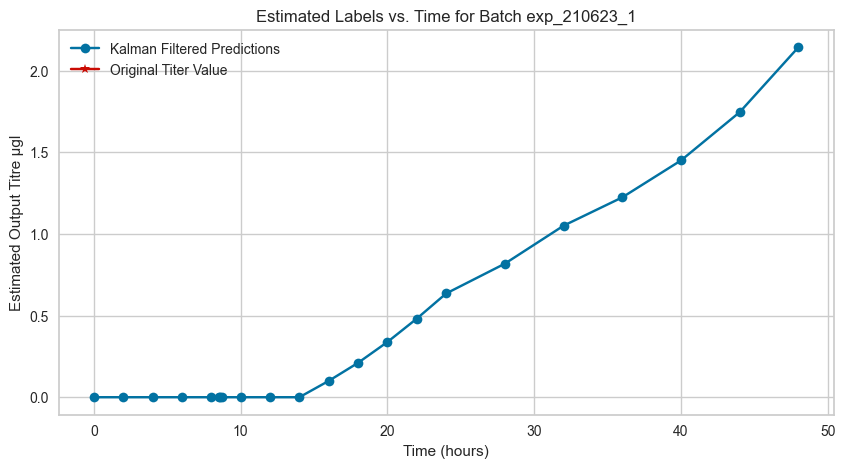

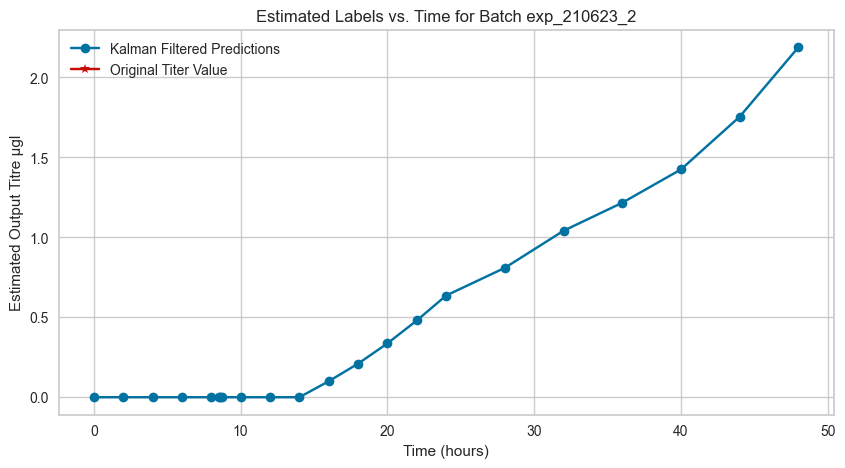

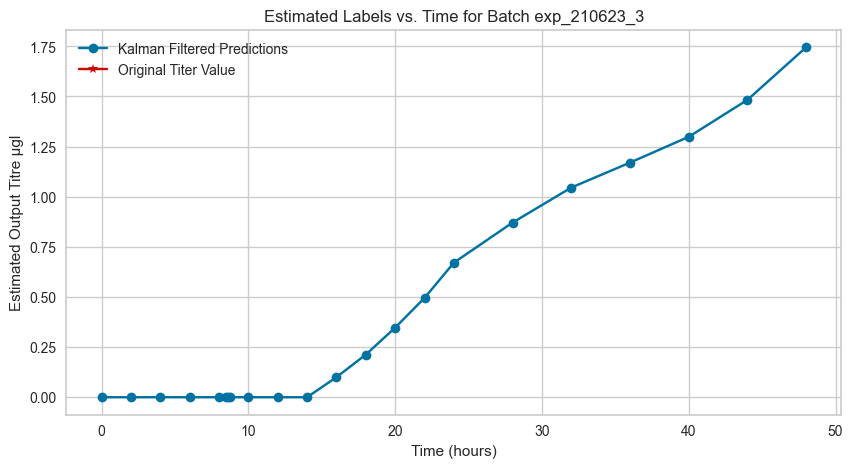

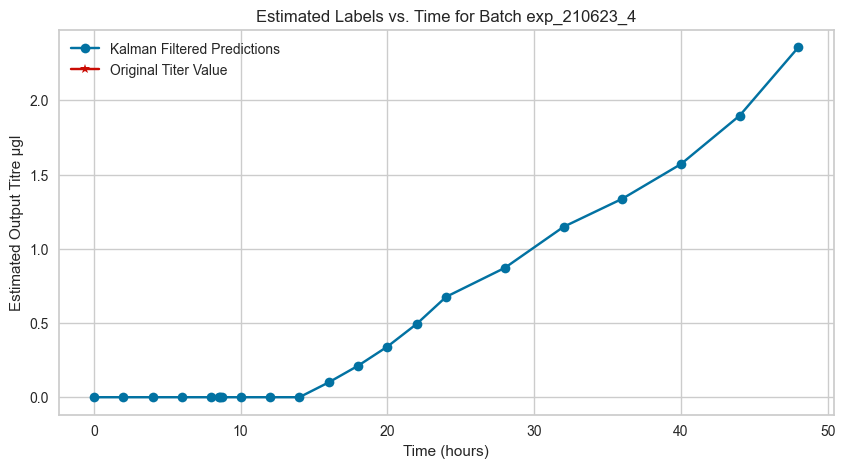

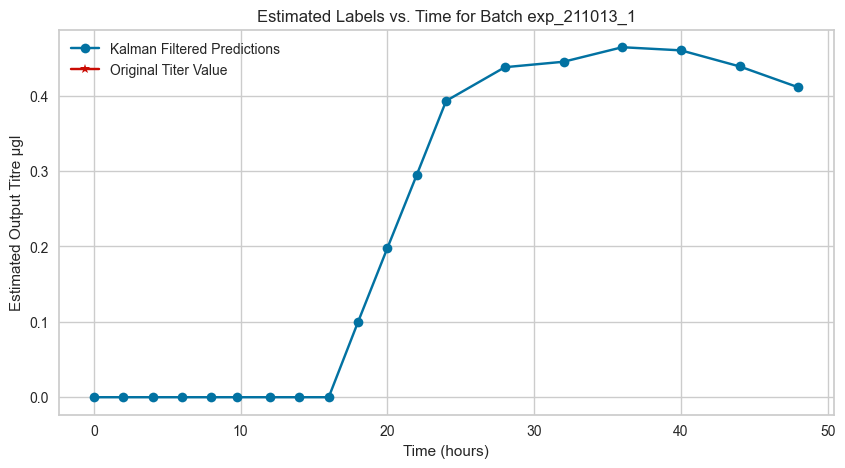

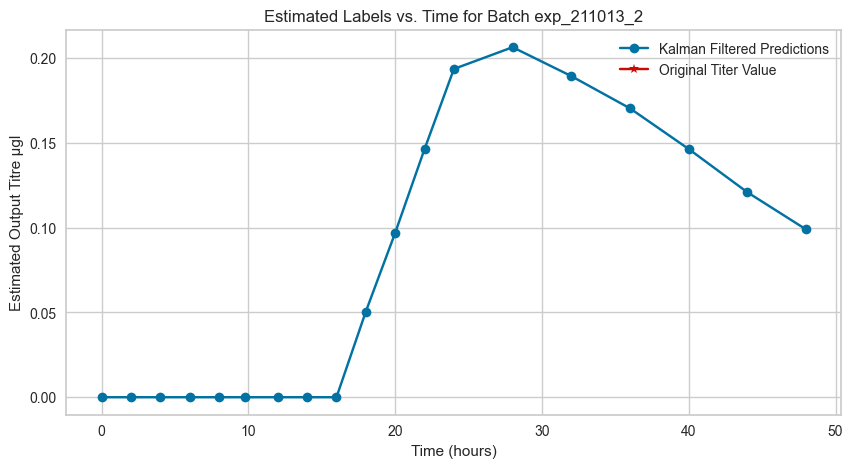

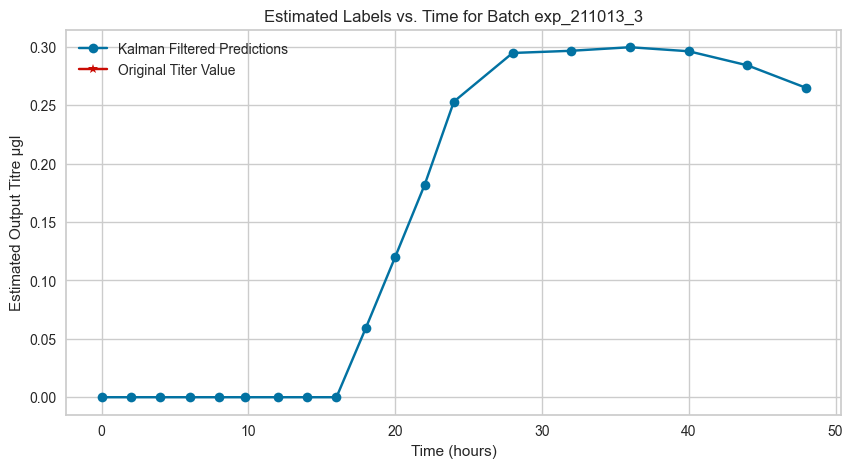

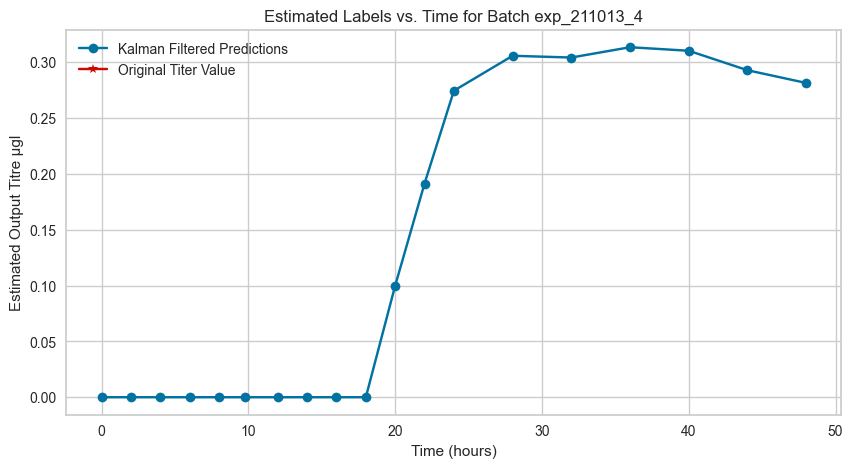

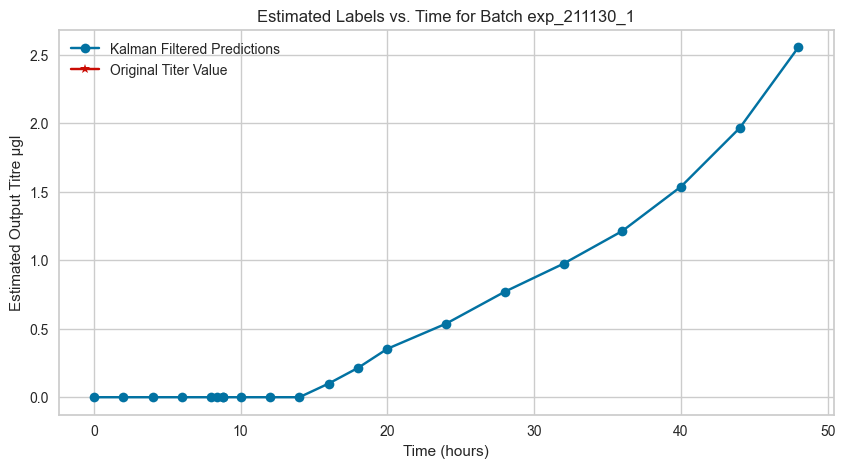

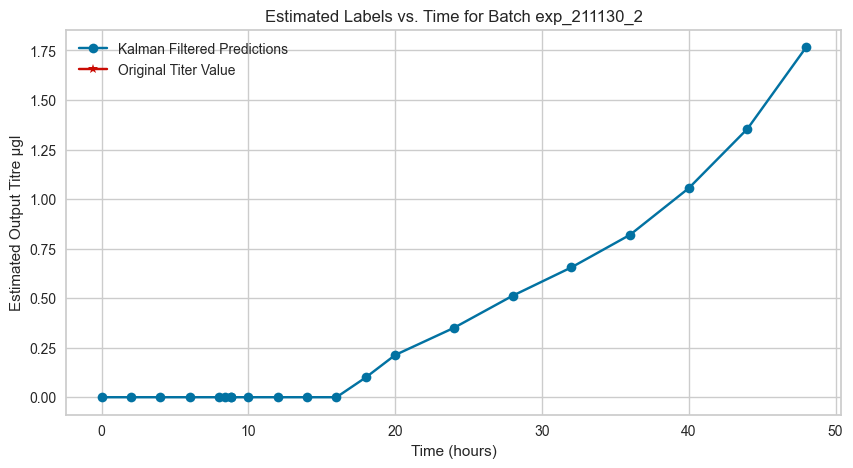

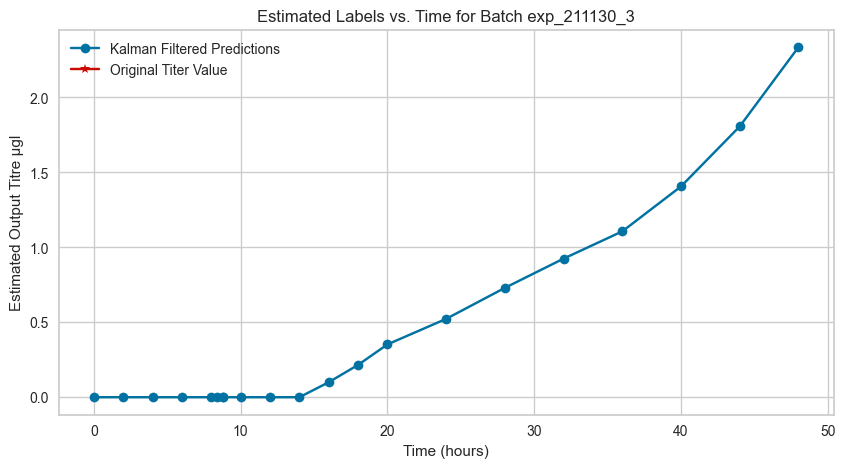

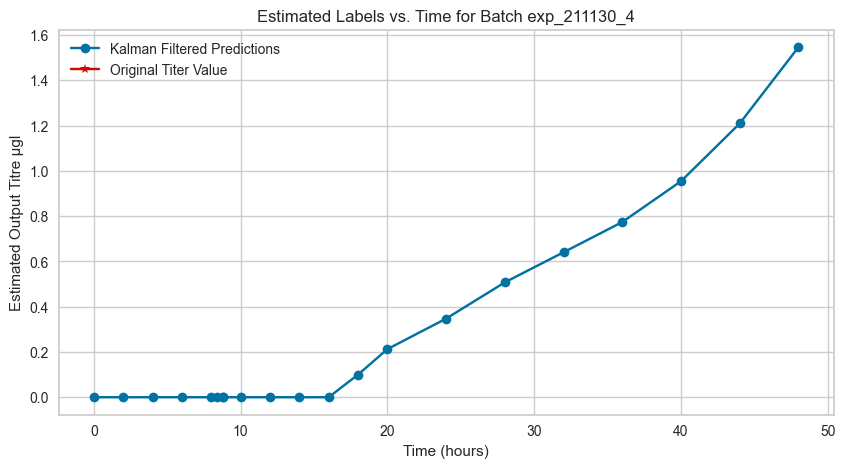

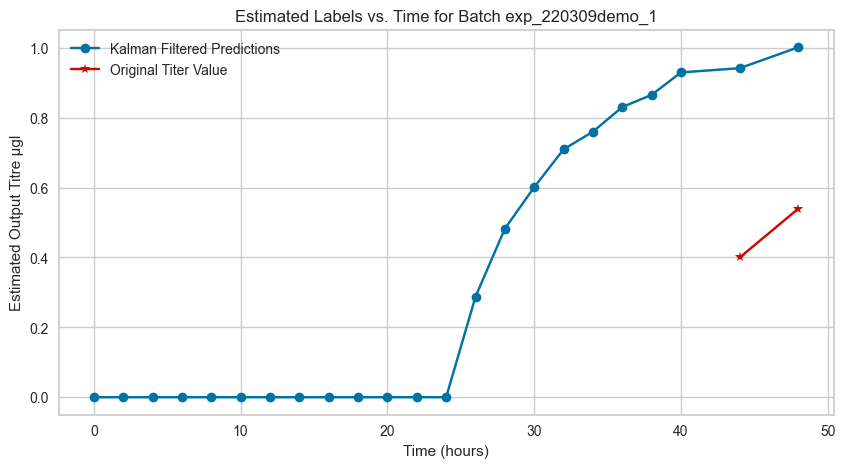

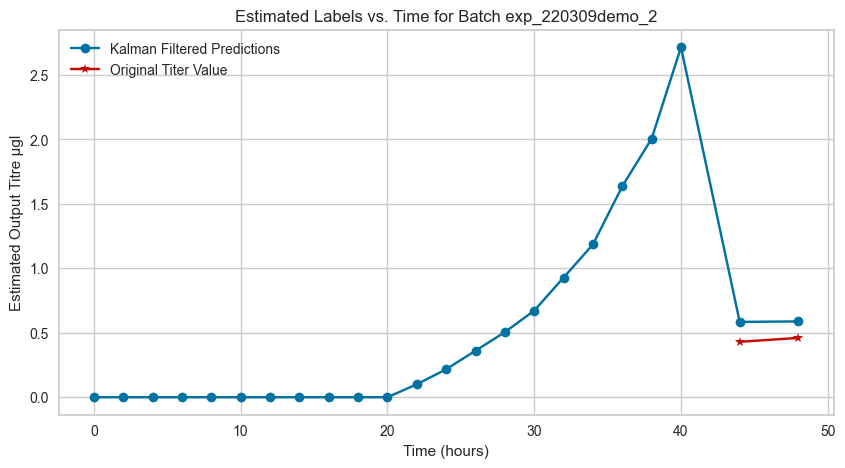

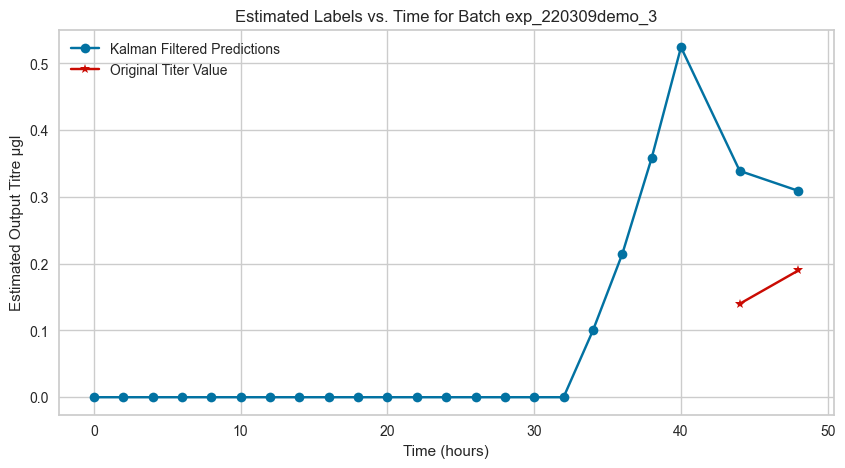

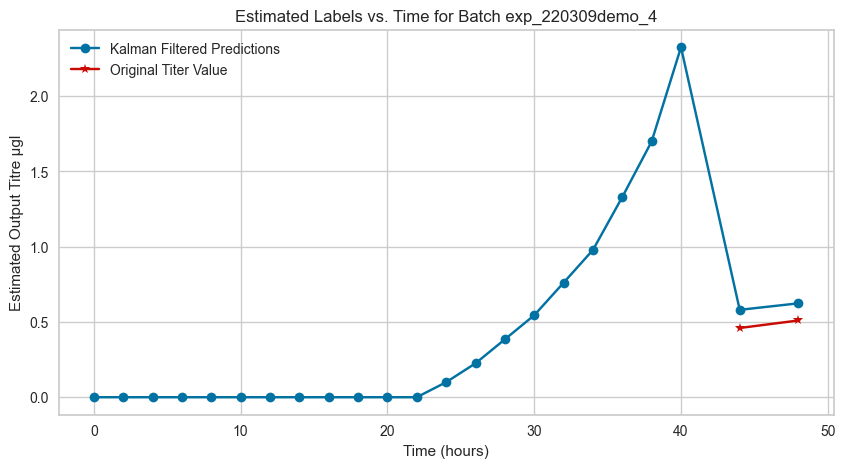

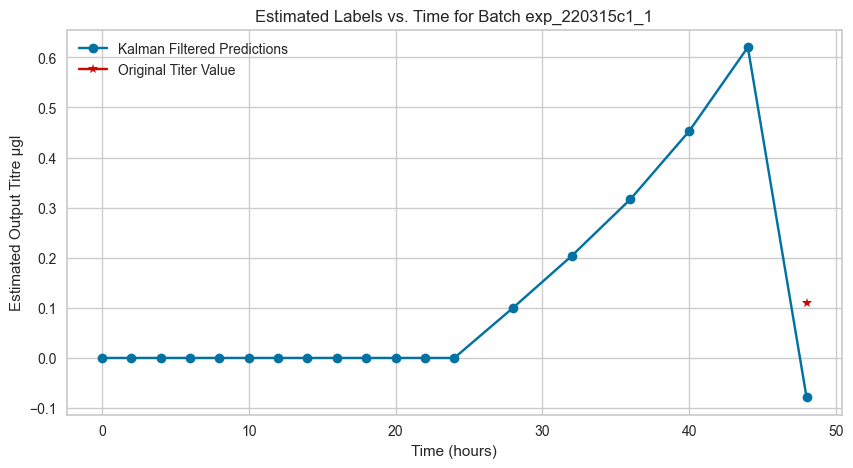

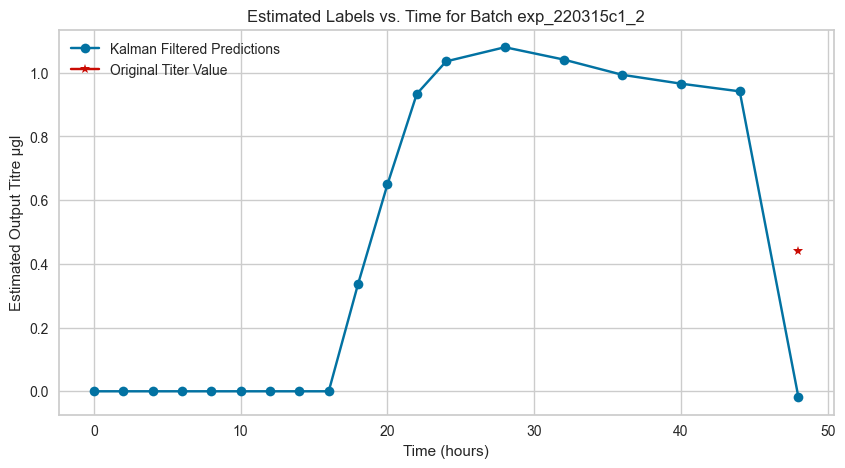

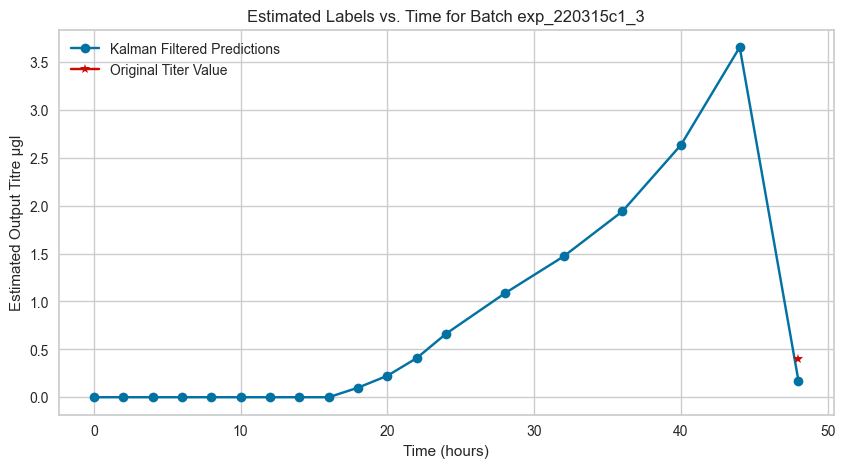

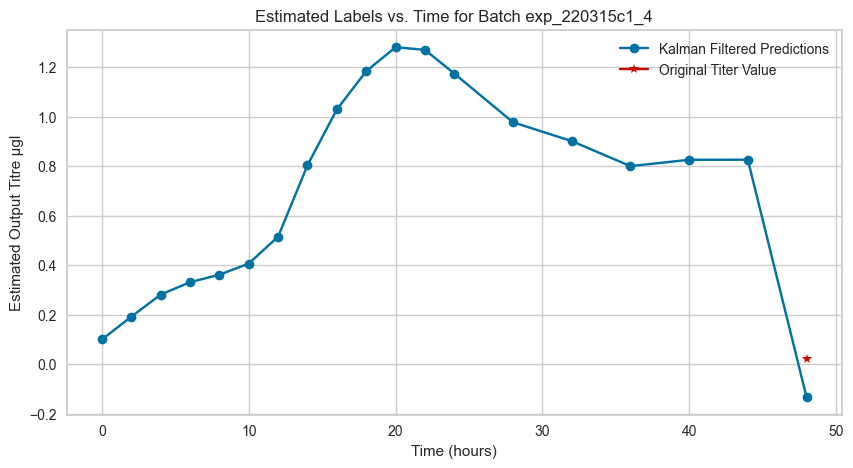

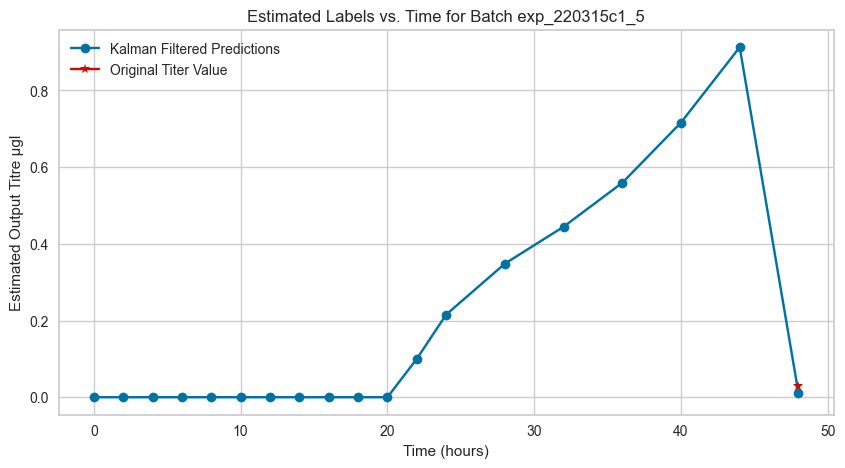

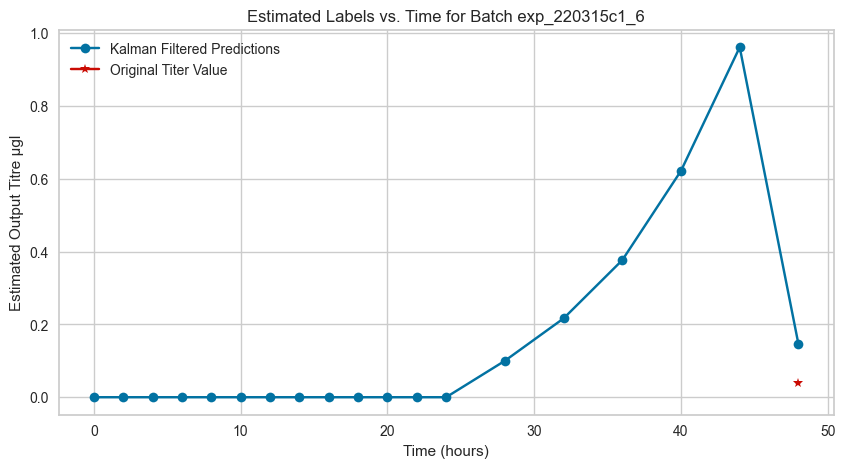

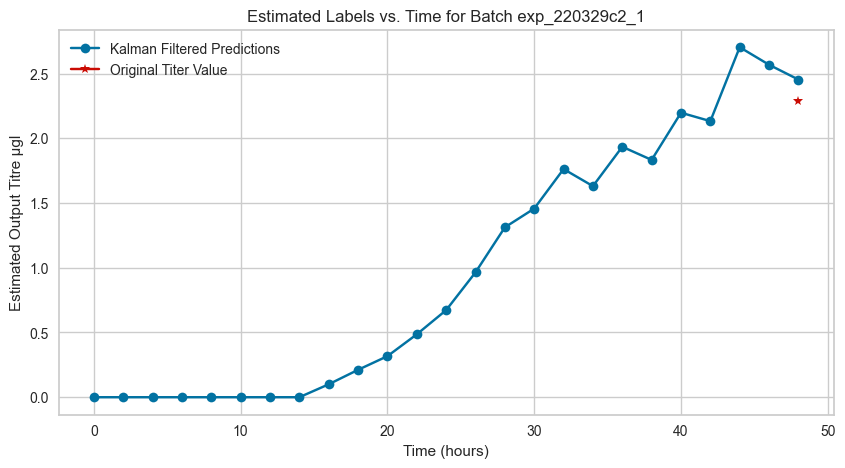

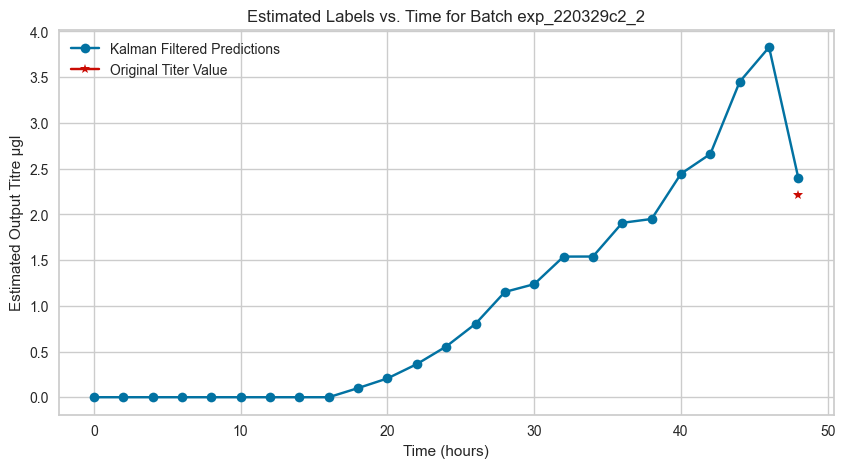

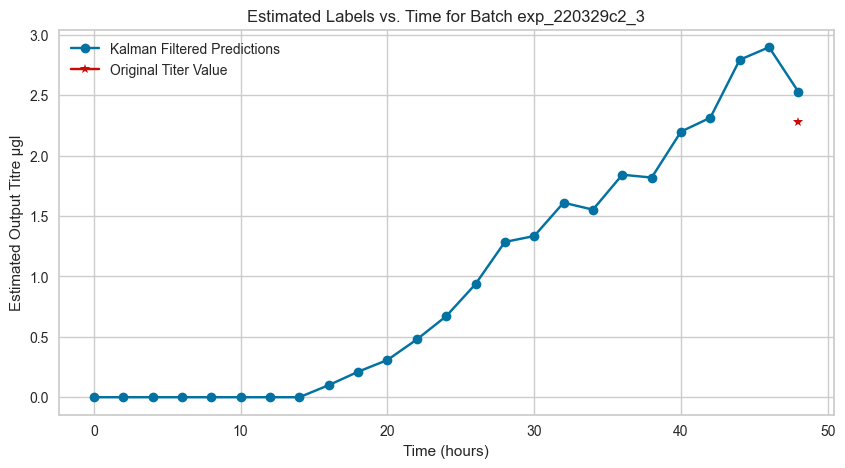

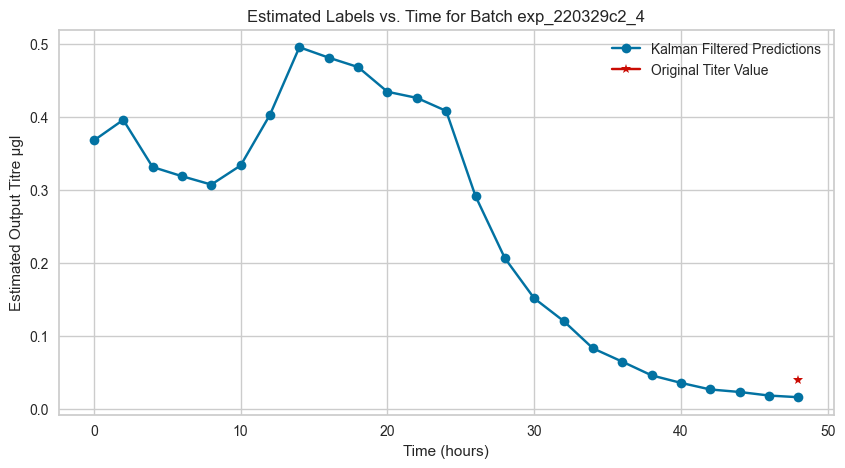

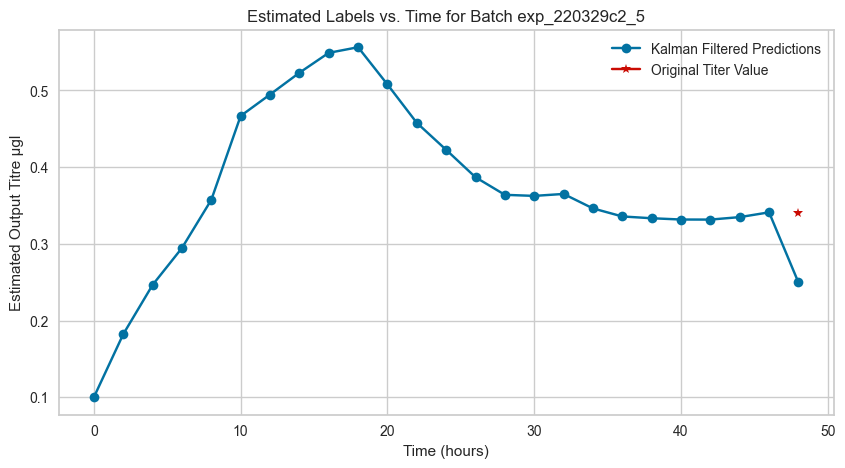

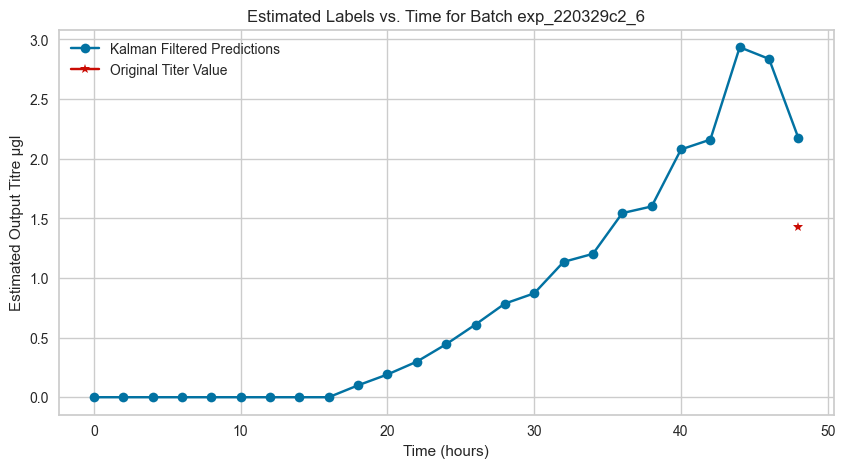

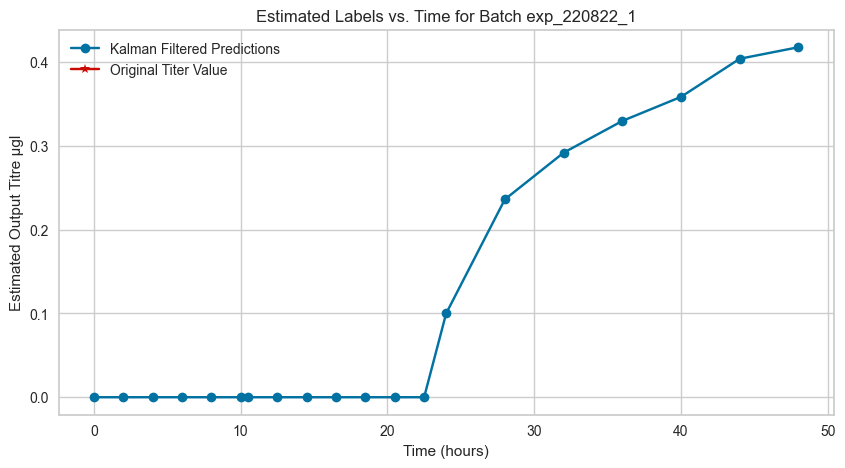

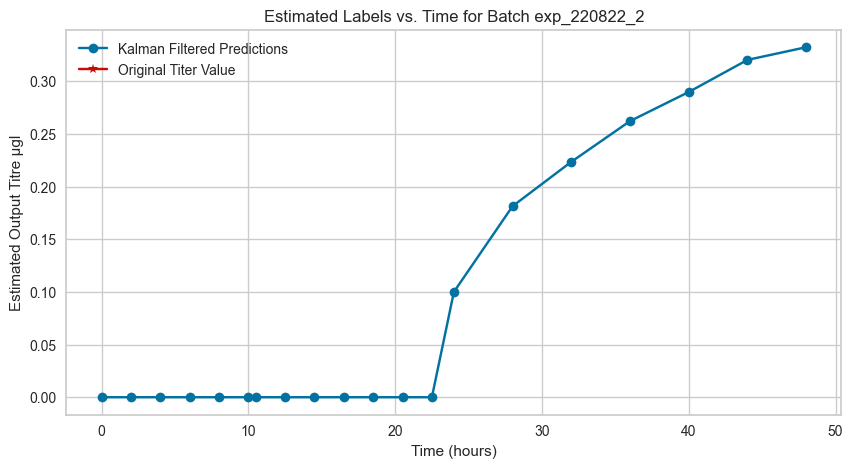

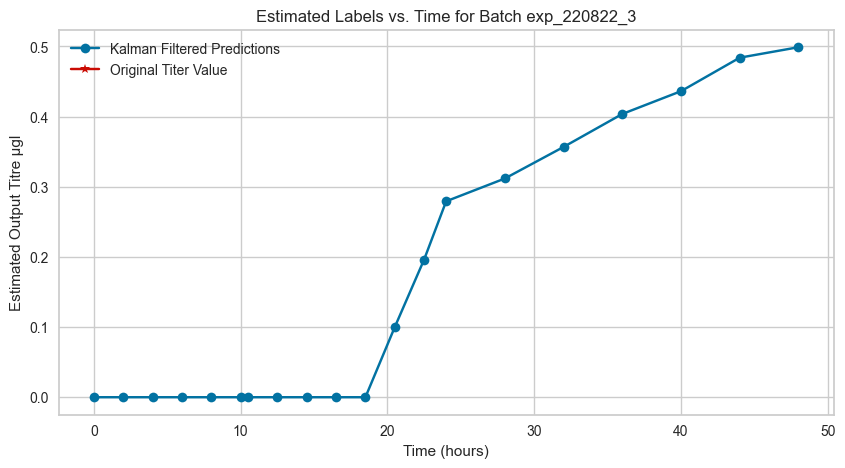

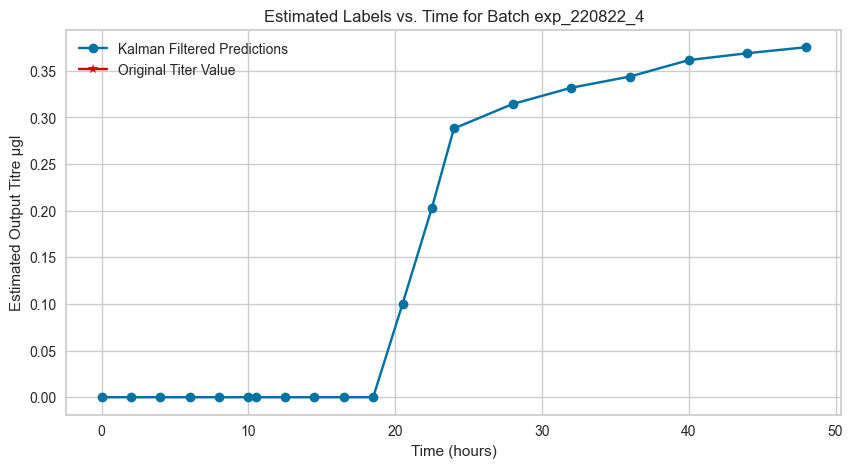

In [131]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score


# Initialize lists to hold results
filled_labels_with_trend = []
features_with_trend = []
real_labels = []
first_split = True
time_vectors = []  # To store time vectors for each batch



# Initialize scaler
# scaler = StandardScaler() 
scaler = MinMaxScaler(feature_range=(0, 1))

def train_evaluate_kalman(dataset):
    unique_batches = dataset['batch'].unique()
    scaler = StandardScaler()  # Initialize the scaler
    
    scaled_dataset = dataset.copy()
    time_indx = scaled_dataset.columns.get_loc('input_Timepoint (hr)')

    # DataFrame 'dataset' should be preloaded with columns including 'batch'
    unique_batches = scaled_dataset['batch'].unique()
    cols_scale = [col for col in scaled_dataset.columns if scaled_dataset[col].dtypes != 'o' and col not in ['output_titre_µgl', 'input_batch', 'batch', 'y_prev', 'input_batch', 'ml_predicted_output_titer_µg', 'input_Timepoint (hr)', 'imputed_titre', 'original_titer']]
    scaled_dataset[cols_scale] = scaler.fit_transform(scaled_dataset[cols_scale])
    
    # Initialize lists to store results
    kalman_results = []
    
    for batch in unique_batches:
        # Filter the data for the current batch
        batch_data = scaled_dataset[scaled_dataset['batch'] == batch]

        # Prepare features and labels
        features = batch_data.drop(columns=['output_titre_µgl', 'original_titer','imputed_titre','input_batch', 'batch', 'y_prev', 'input_batch', 'ml_predicted_output_titer_µg']).to_numpy()
        # labels = batch_data['output_titre_µgl'].to_numpy()  
        labels = batch_data['original_titer'].to_numpy()
        labels_2 = batch_data['imputed_titre'].to_numpy()

        # Create a time vector for the current batch, incrementing by 2 hours per time point
        # time_vector = np.arange(2, 2 * len(labels) + 2, 2)  # Start from 2 hours, increment by 2 

        time_vector = features[:, 0] 
        time_vectors.append(time_vector)

        # Kalman filter initialization for the batch
        kf_with_trend = TrendIncorporatedKalmanFilter(model_with_trend)
        initial_state_with_trend = KalmanState(mean=np.zeros(1), covariance=np.eye(1) * 1)
        # print(features[:, 1:])
        # Estimate labels using the Kalman filter
        estimated_labels = estimate_labels_with_trend(features[:, 1:], labels_2, kf_with_trend, initial_state_with_trend).flatten()
        
        # Store the results
        filled_labels_with_trend.append(estimated_labels)
        features_with_trend.append(features)
        
        real_labels.append(labels)

    # Plotting each batch's estimated labels vs. time
    for i, (time_vector, estimated_labels, batch_label) in enumerate(zip(time_vectors, filled_labels_with_trend, real_labels)):
        plt.figure(figsize=(10, 5))
        plt.plot(time_vector, estimated_labels, marker='o', linestyle='-', color='b', label='Kalman Filtered Predictions')
        plt.plot(time_vector, batch_label, marker='*', linestyle='-', color='r', label='Original Titer Value') 
        plt.title(f'Estimated Labels vs. Time for Batch {unique_batches[i]}')
        plt.xlabel('Time (hours)')
        plt.ylabel('Estimated Output Titre µgl')
        plt.grid(True)
        plt.legend()  # This adds the legend to the plot
        plt.show()


kalman_results = train_evaluate_kalman(dataset)



> Applying Particle Filters

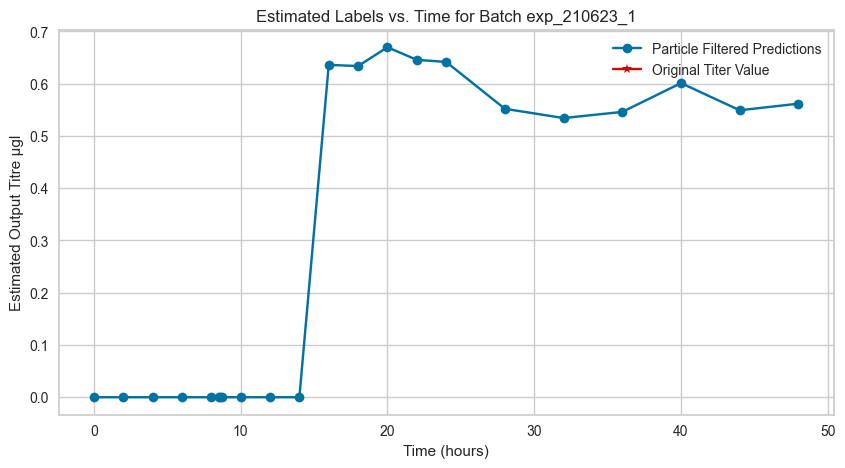

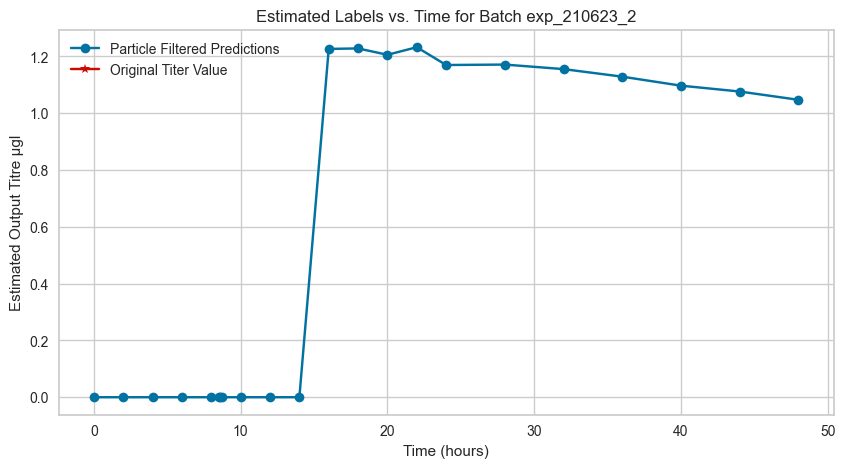

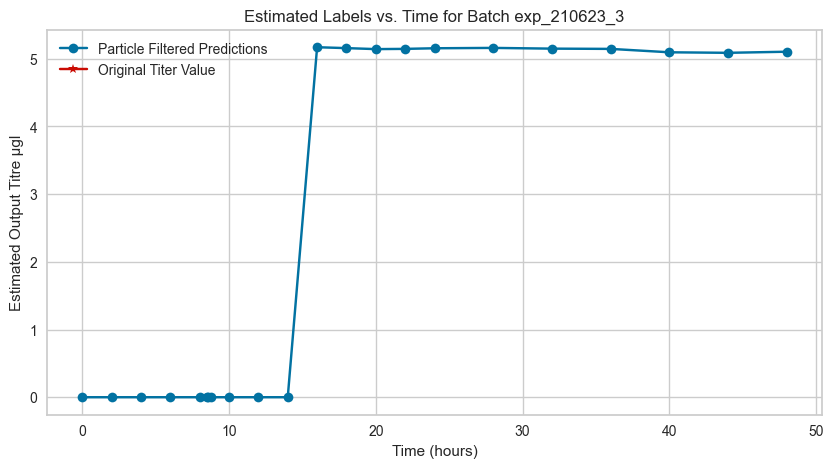

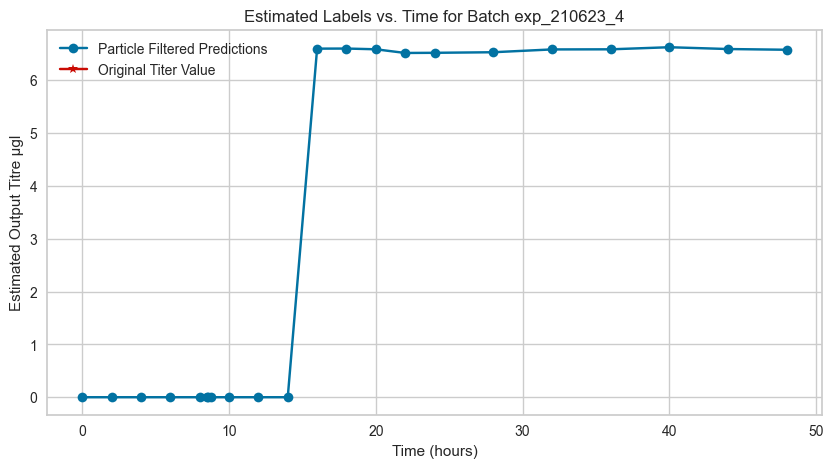

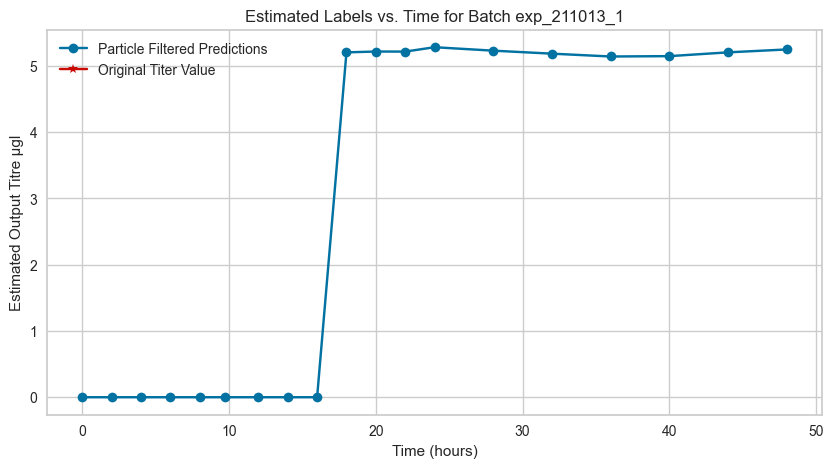

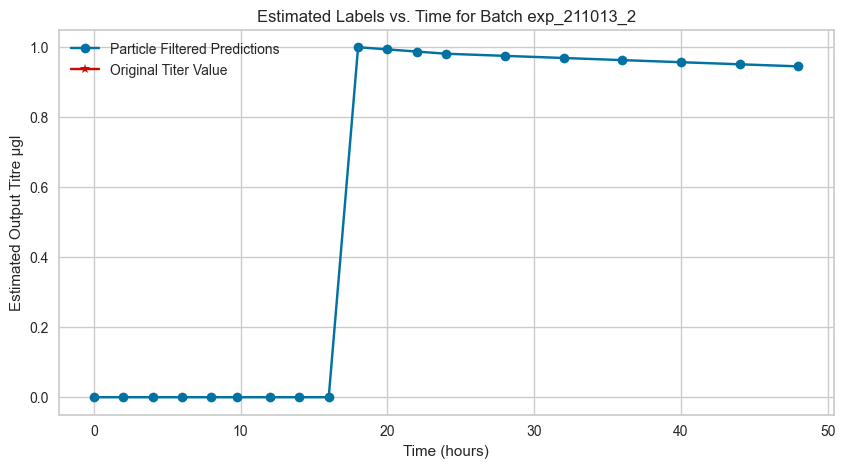

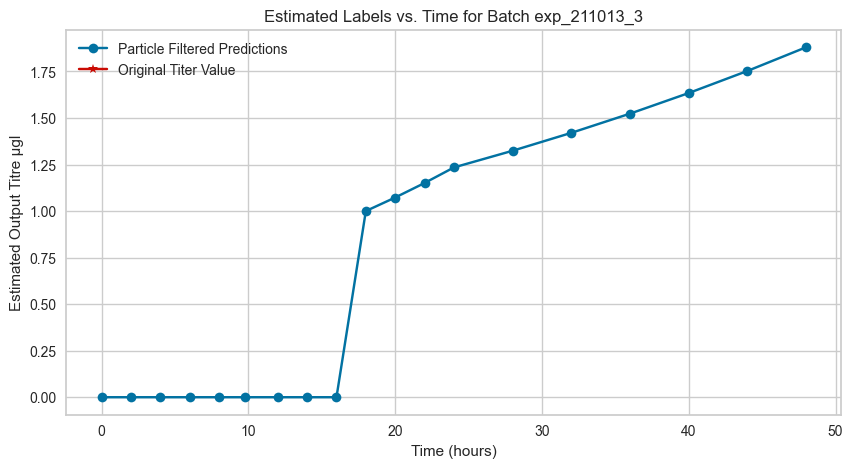

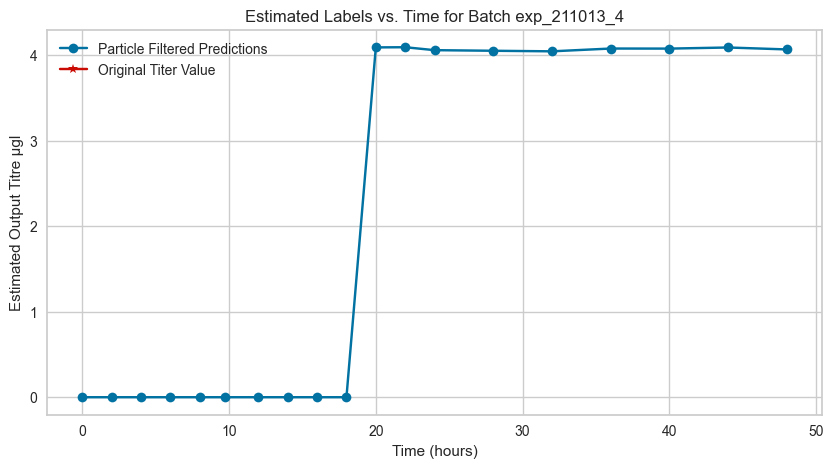

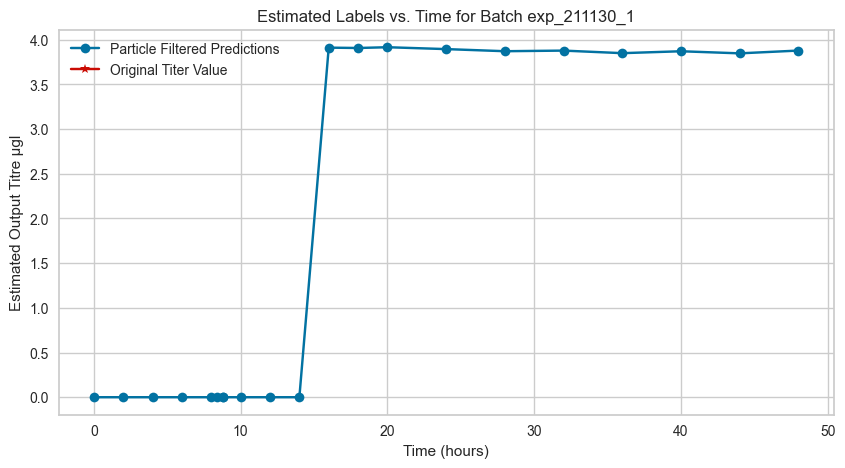

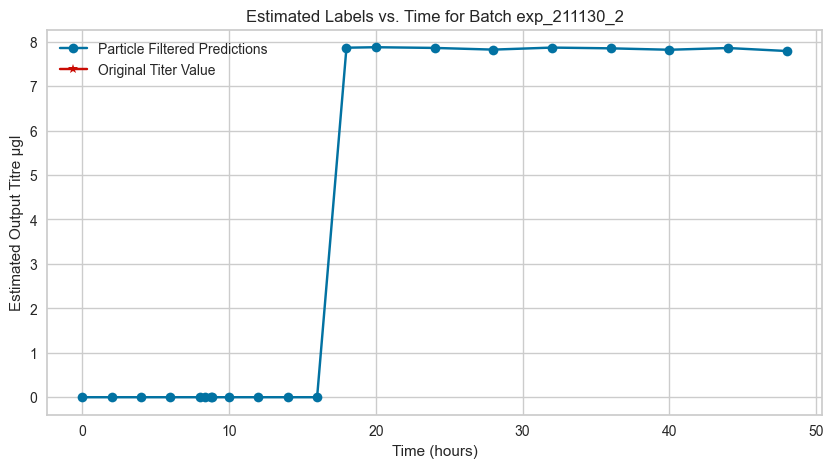

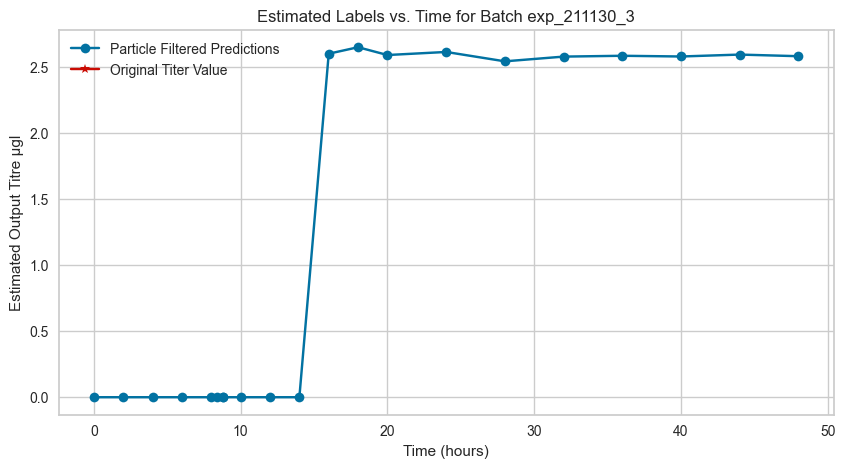

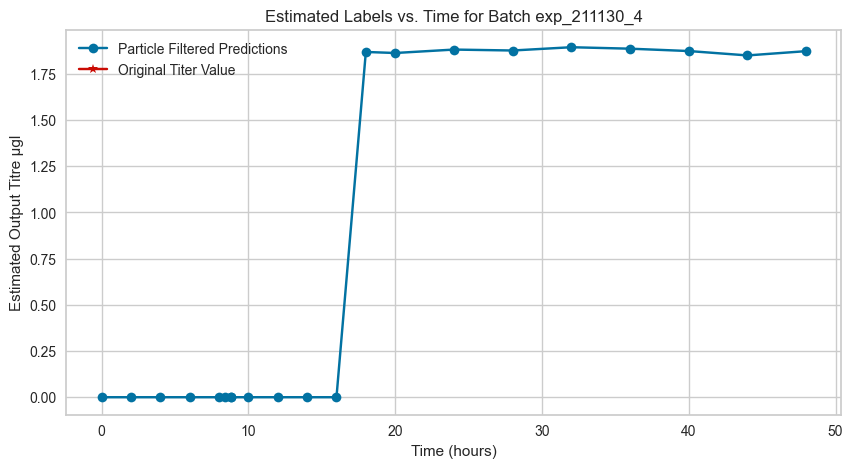

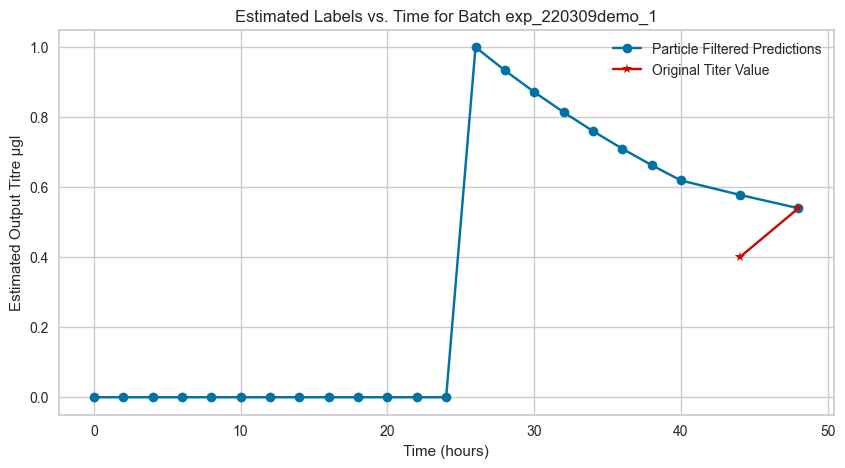

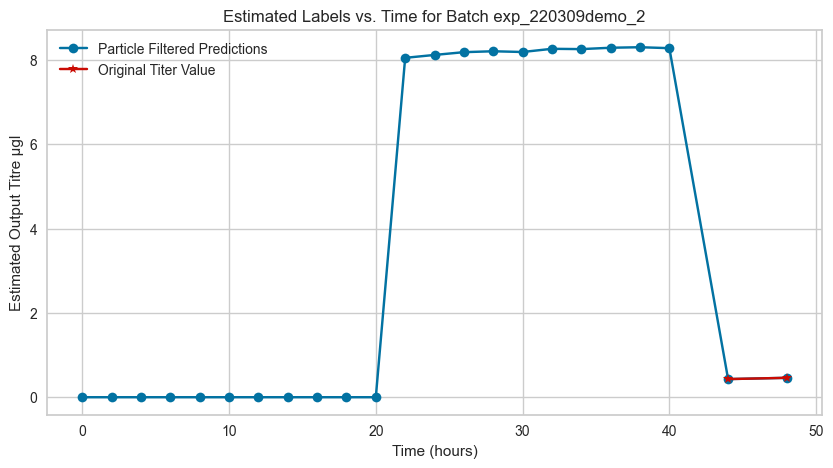

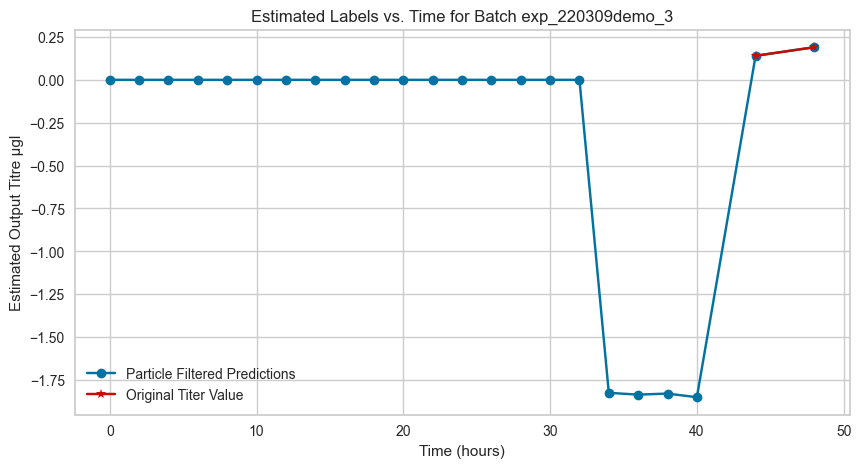

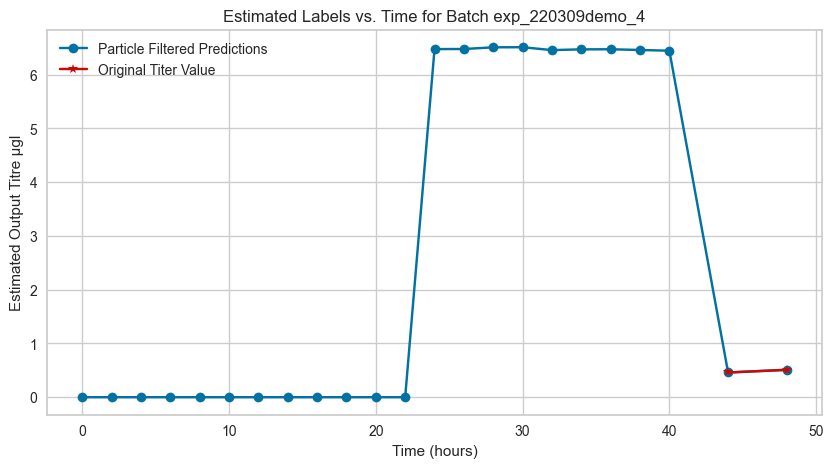

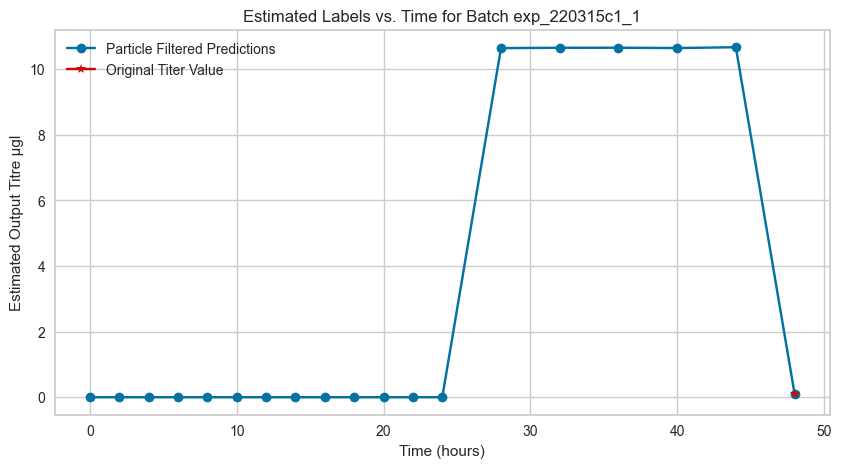

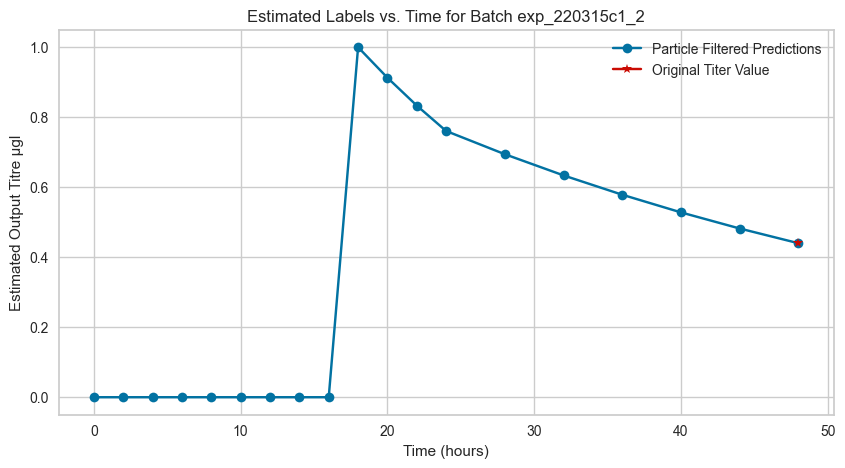

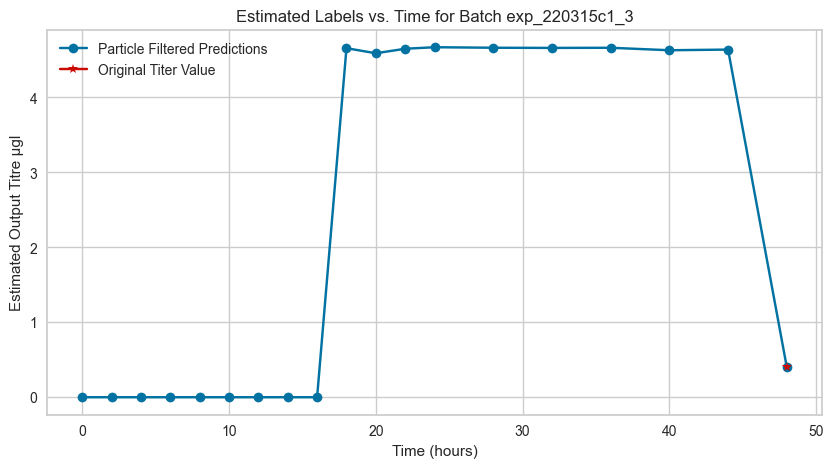

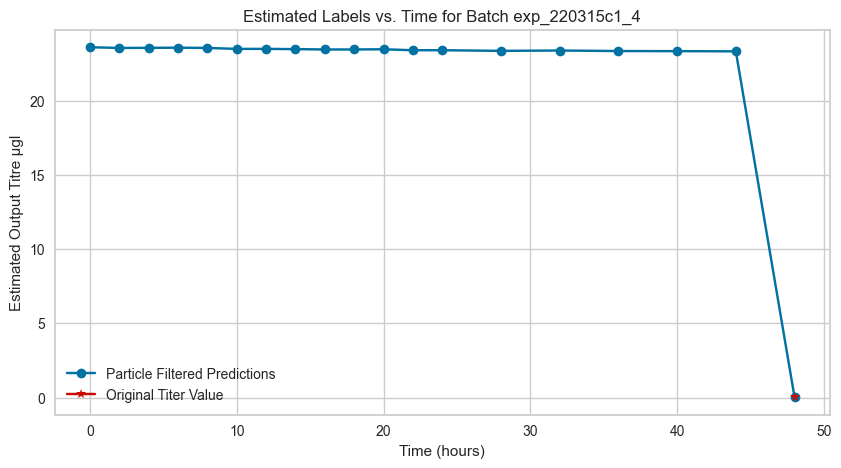

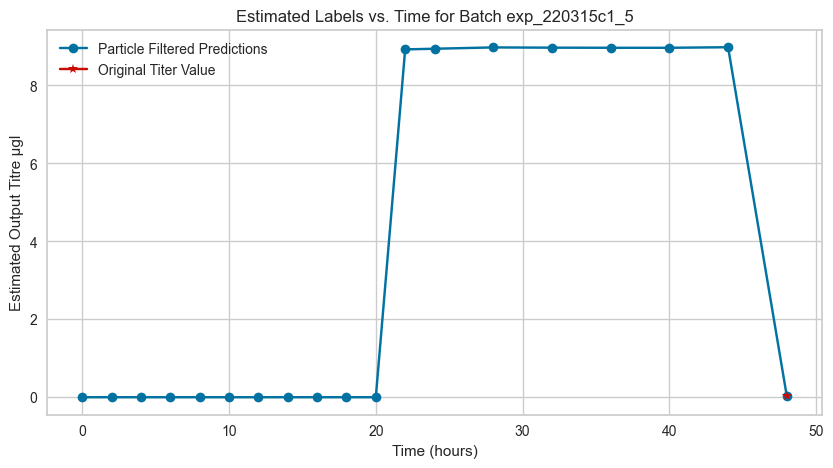

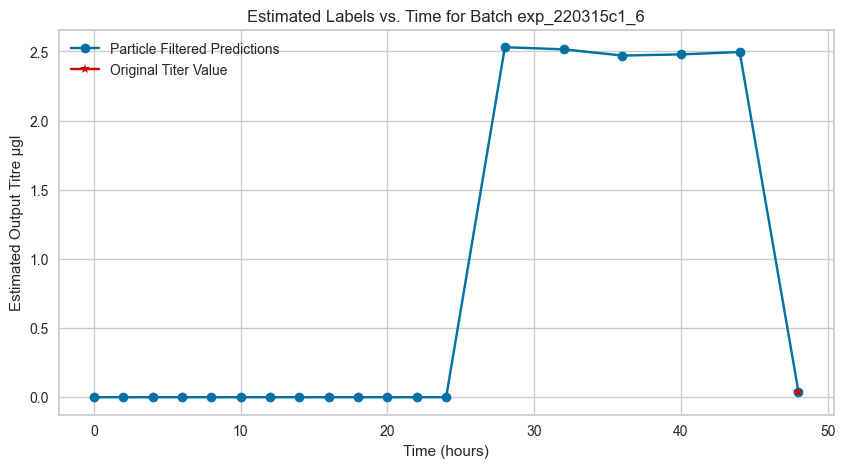

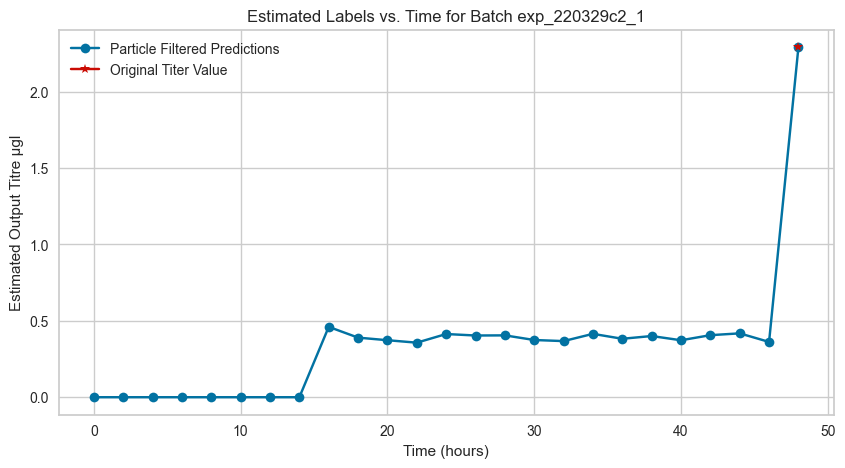

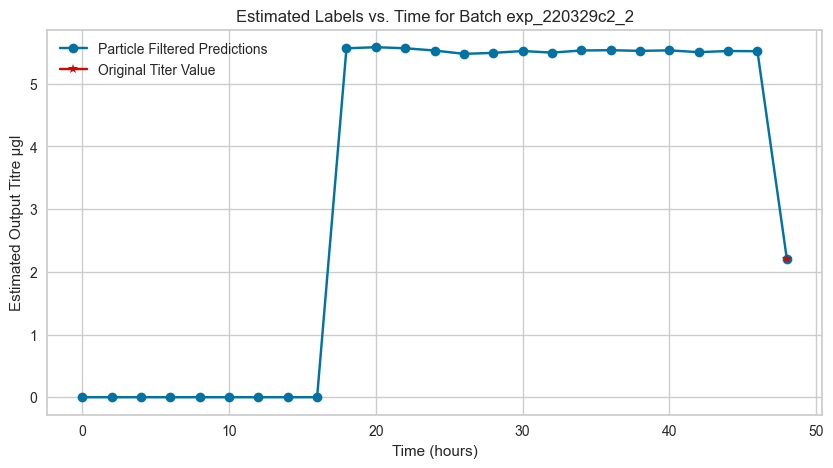

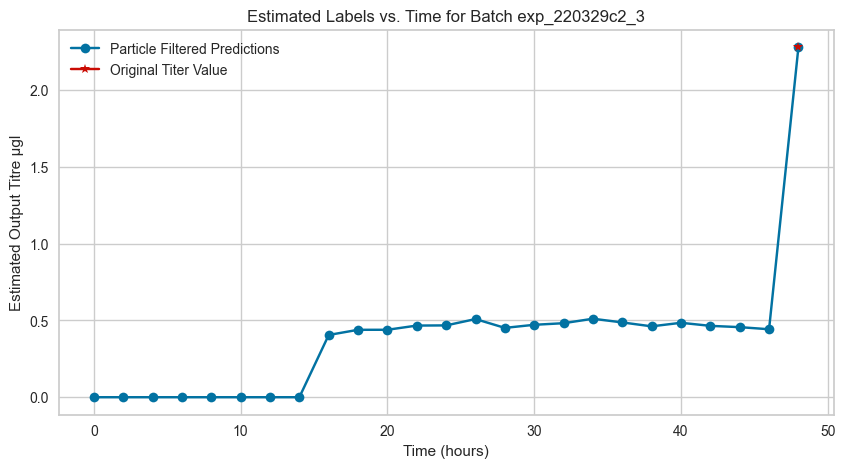

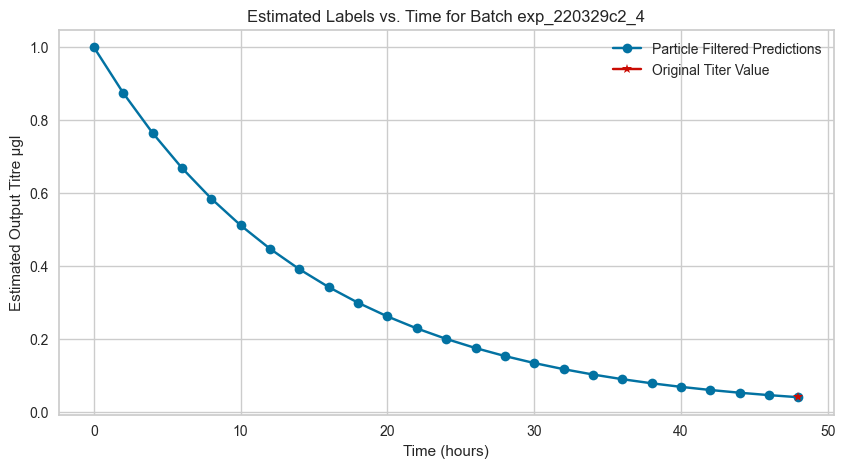

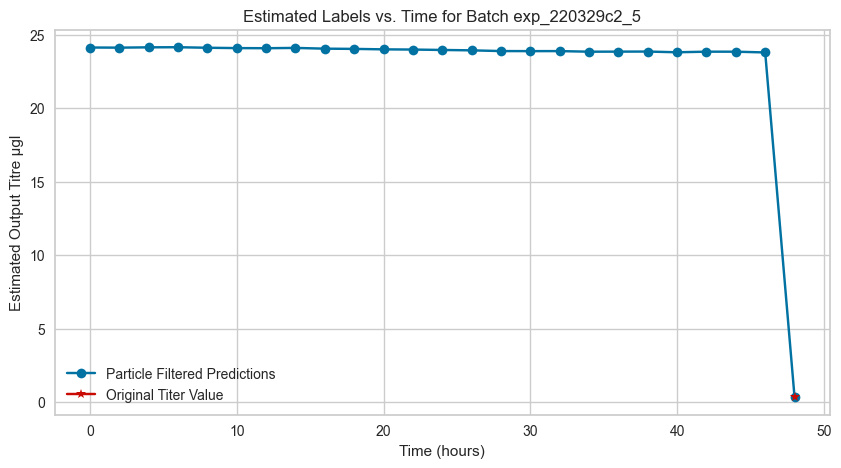

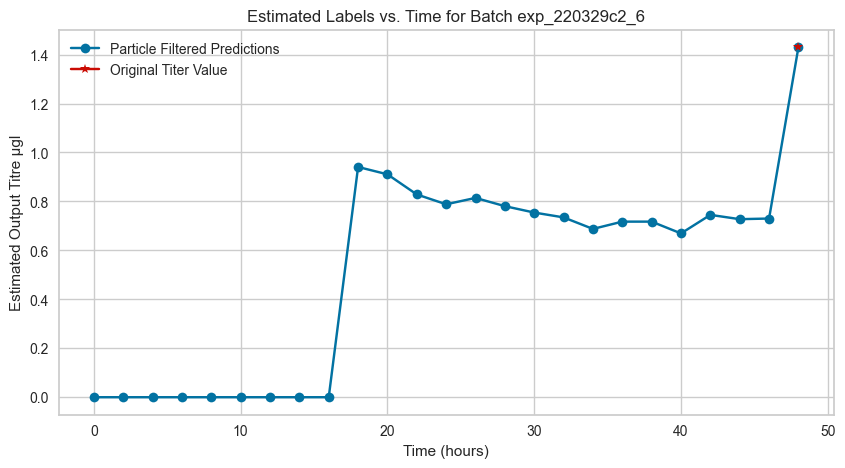

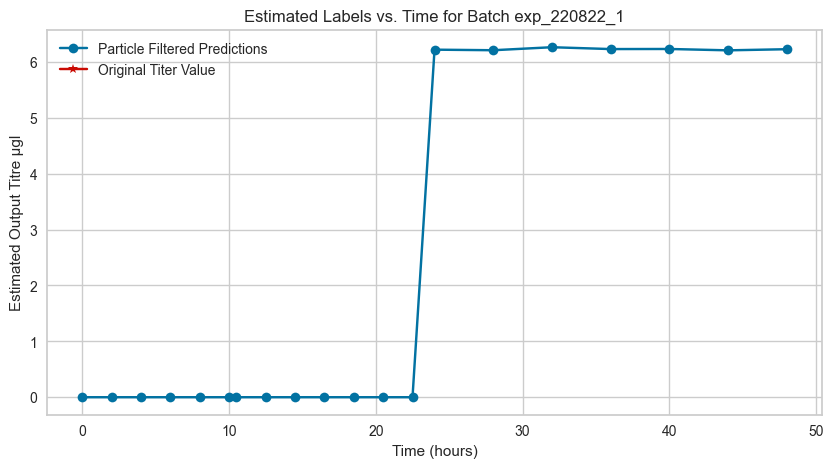

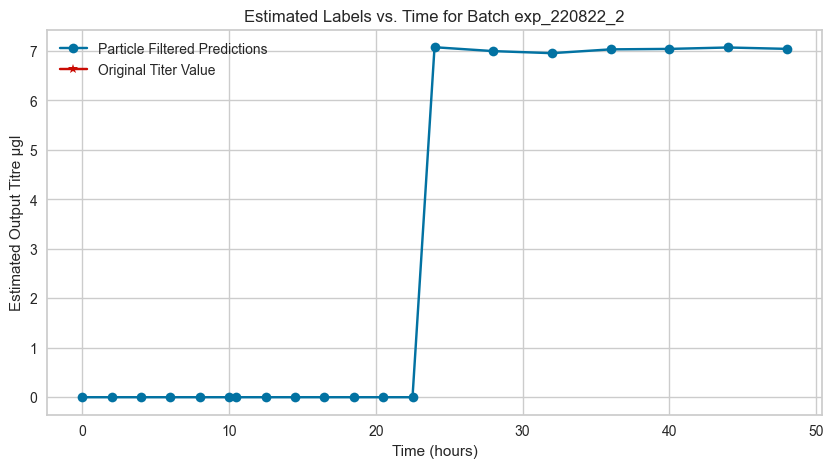

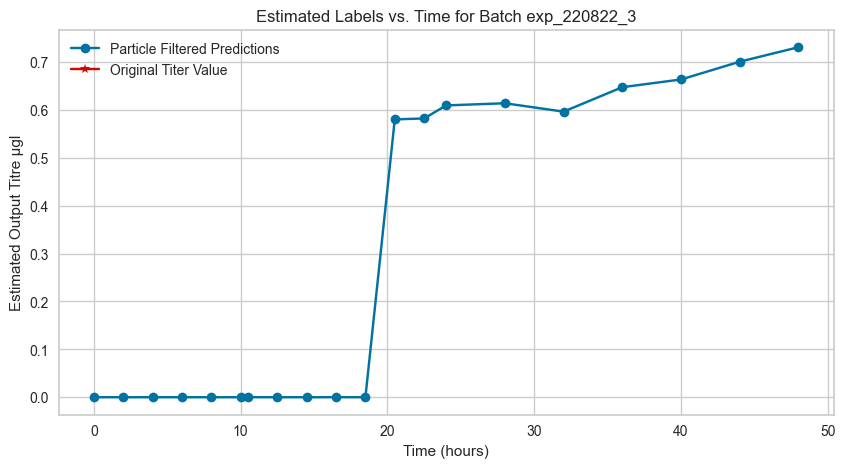

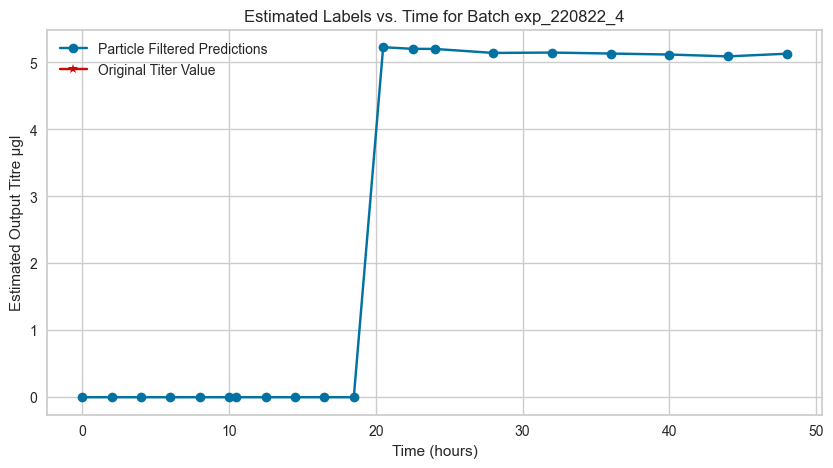

In [132]:
import numpy as np
import pandas as pd
from scipy.stats import norm

def create_particles(feature_ranges, num_particles):
    particles = np.empty((num_particles, len(feature_ranges)))
    for i, (min_val, max_val) in enumerate(feature_ranges):
        particles[:, i] = np.random.uniform(min_val, max_val, size=num_particles)
    return particles

def predict(particles, std_dev=1.0):
    """Add random noise to particles for prediction step."""
    noise = np.random.normal(0, std_dev, size=particles.shape)
    return particles + noise

def update(particles, weights, observed_value, model_function, measurement_std):
    """Update weights based on how particles' predicted values match the observed value."""
    predicted_values = model_function(particles)  # Model function to predict target from features
    distances = np.abs(predicted_values - observed_value)
    weights *= norm.pdf(distances, scale=measurement_std)
    weights /= np.sum(weights)  # Normalize weights
    return weights

def estimate(particles, weights):
    # Assuming you want the estimated value from the first feature
    # Change 0 to your specific feature index for `output_titre_µgl`
    return np.average(particles[:, 0], weights=weights)  # Ensure this is a scalar

def resample(particles, weights):
    cumulative_sum = np.cumsum(weights)
    indices = np.searchsorted(cumulative_sum, np.random.random(len(weights)))
    return particles[indices], np.ones(len(weights)) / len(weights)


def train_evaluate_PF(dataset):
    unique_batches = dataset['batch'].unique()
    scaler = StandardScaler()  # Initialize the scaler
    
    scaled_dataset = dataset.copy()
    time_indx = scaled_dataset.columns.get_loc('input_Timepoint (hr)')

    # DataFrame 'dataset' should be preloaded with columns including 'batch'
    unique_batches = scaled_dataset['batch'].unique()
    cols_scale = [col for col in scaled_dataset.columns if scaled_dataset[col].dtypes != 'o' and col not in ['output_titre_µgl', 'input_batch', 'batch', 'original_titer','y_prev', 'input_batch', 'ml_predicted_output_titer_µg', 'input_Timepoint (hr)', 'imputed_titre']]
    scaled_dataset[cols_scale] = scaler.fit_transform(scaled_dataset[cols_scale])
    
    # Initialize lists to store results
    time_vectors = []
    real_labels = []
    imputted_labels = []
    

    for batch in unique_batches:
        # Filter the data for the current batch
        batch_data = scaled_dataset[scaled_dataset['batch'] == batch]
        
        # Prepare features and labels
        features = batch_data.drop(columns=['output_titre_µgl', 'imputed_titre','input_batch', 'original_titer','batch', 'y_prev', 'input_batch', 'ml_predicted_output_titer_µg'])
        # labels = batch_data['output_titre_µgl'].to_numpy() 
        labels = batch_data['original_titer'].to_numpy()
        labels_2 = batch_data['imputed_titre'].to_numpy()

        # Create a time vector for the current batch, incrementing by 2 hours per time point
        time_vector = features.iloc[:, 0].to_numpy()
        time_vectors.append(time_vector)
        real_labels.append(labels)

        # Initialize particles
        num_particles = 1000 
        feature_columns = [col for col in features.columns]
        feature_columns.append('output_titre_µgl') 
        feature_index = feature_columns.index('output_titre_µgl')  # Get index of the target variable

        # Assuming you have a DataFrame 'batch_data' with features and the target 'output_titre_µgl'
        # feature_columns = [col for col in features.columns if col != 'output_titre_µgl'] 

        feature_ranges = [(np.nanmin(batch_data[col]), np.nanmax(batch_data[col])) for col in feature_columns]
        num_particles = 1000
        particles = create_particles(feature_ranges, num_particles)
        weights = np.ones(num_particles) / num_particles
    
        # Assume a simple model function that predicts 'output_titre_µgl' from features
        def model_function(particles):
            return np.sum(particles, axis=1)  # Simplistic sum of features for illustration
        
        batch_data['predicted_titer'] = np.nan
        # print(batch_data['output_titre_µgl'])
        # Particle filter execution loop (simplified)
        for i, row in batch_data.iterrows():
            # measurement = row['output_titre_µgl']
            measurement = row['imputed_titre']
            particles = predict(particles)
            if not np.isnan(measurement):
                weights = update(particles, weights, measurement, model_function, 0.1)
                particles, weights = resample(particles, weights)
            
            # Update the 'predicted_titer' column
            if pd.isna(row['predicted_titer']):
                if pd.notna(row['imputed_titre']):
                    batch_data.at[i, 'predicted_titer'] = row['imputed_titre']
                else:
                    batch_data.at[i, 'predicted_titer'] = estimate(particles, weights)
            
            # batch_data.at[i, 'predicted_titer'] = estimate(particles, weights)
            
        # imputted_labels.append(batch_data['output_titre_µgl'].to_numpy())   
        imputted_labels.append(batch_data['predicted_titer'].to_numpy()) 
        
    # Plotting each batch's estimated labels vs. time
    for i, (time_vector, estimated_labels, batch_label) in enumerate(zip(time_vectors, imputted_labels, real_labels)):
        plt.figure(figsize=(10, 5))
        plt.plot(time_vector, estimated_labels, marker='o', linestyle='-', color='b', label='Particle Filtered Predictions')
        plt.plot(time_vector, batch_label, marker='*', linestyle='-', color='r', label='Original Titer Value') 
        plt.title(f'Estimated Labels vs. Time for Batch {unique_batches[i]}')
        plt.xlabel('Time (hours)')
        plt.ylabel('Estimated Output Titre µgl')
        plt.grid(True)
        plt.legend()  # This adds the legend to the plot
        plt.show()

# Optionally, plot results or further analysis
train_evaluate_PF(dataset)


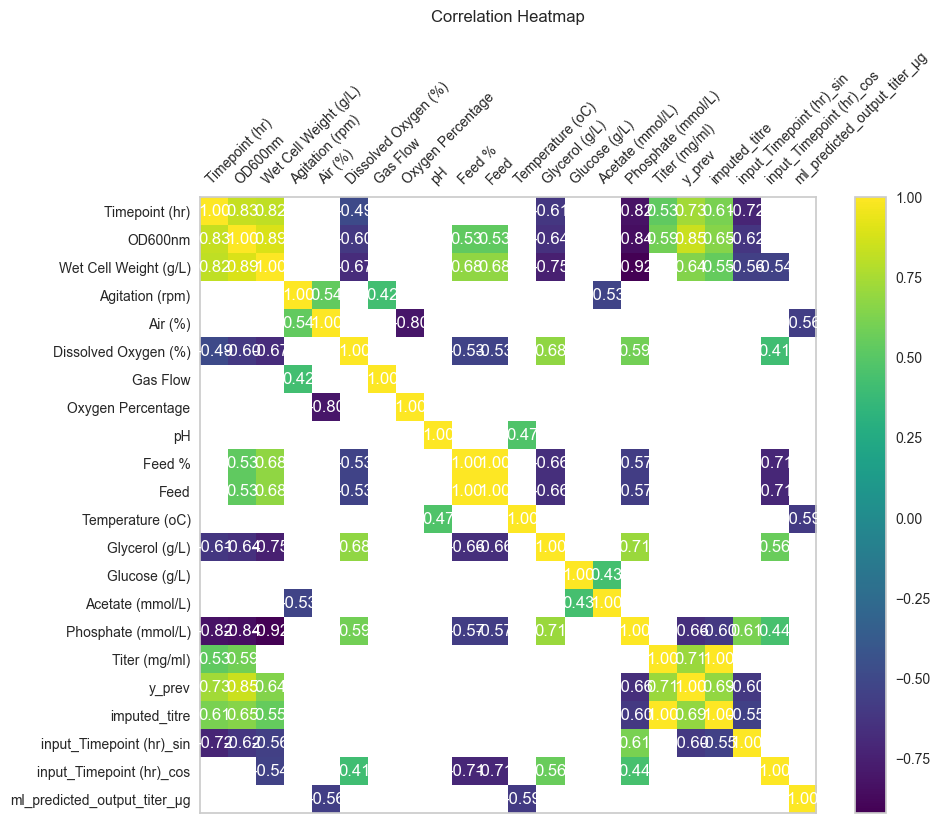

In [111]:
import numpy as np
import matplotlib.pyplot as plt

def plot_corr_matrix_matplotlib(df, corr_val=0.4, save=False, fig_path="images/correlation_plots/correlation_heatmap.png"):
    # Rename columns for readability
    df = df.rename(columns={
        'output_OD600': 'OD600nm', 
        'output_WCW_gl': 'Wet Cell Weight (g/L)', 
        'output_feed': 'Feed', 
        'output_feed_%': 'Feed %',
        'output_agitation': 'Agitation (rpm)', 
        'output_air_%': 'Air (%)', 
        'output_O2': 'Oxygen Percentage', 
        'output_gasflow': 'Gas Flow',
        'output_Ph': 'pH', 
        'output_Temp': 'Temperature (oC)', 
        'output_glycerol_gl': 'Glycerol (g/L)', 
        'output_acetate_mmol_l': 'Acetate (mmol/L)',
        'output_phosphate_mmol_l': 'Phosphate (mmol/L)', 
        'input_Timepoint (hr)': 'Timepoint (hr)', 
        'output_D0_%': 'Dissolved Oxygen (%)', 
        'output_glucose_gl': 'Glucose (g/L)',
        'output_titre_µgl': 'Titer (mg/ml)'
        
    })
    
    # Compute the correlation matrix
    corr_matrix = df.select_dtypes(include=[np.number]).corr()

    # Optionally filter the matrix to keep only correlations with abs value >= corr_val
    if corr_val:
        corr_matrix = corr_matrix.where(np.abs(corr_matrix) >= corr_val)

    fig, ax = plt.subplots(figsize=(10, 8))

    # Create the heatmap
    cax = ax.matshow(corr_matrix, cmap='viridis')

    # Add a color bar for reference
    fig.colorbar(cax)

    # Set up axes with the correct labels
    ax.set_xticks(np.arange(len(corr_matrix.columns)))
    ax.set_yticks(np.arange(len(corr_matrix.columns)))
    ax.set_xticklabels(corr_matrix.columns)
    ax.set_yticklabels(corr_matrix.columns)

    # Remove grid lines
    ax.grid(False)

    # Rotate the tick labels for readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")

    # Annotate cells with their numeric value if abs value is above corr_val
    for (i, j), val in np.ndenumerate(corr_matrix):
        if np.abs(val) >= corr_val:
            ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='white')

    # Set the title and optionally save the figure
    plt.title("Correlation Heatmap", pad=20)
    if save:
        plt.savefig(fig_path)

    plt.show()
plot_corr_matrix_matplotlib(dataset, corr_val=0.4, save=False, fig_path="images/correlation_plots/correlation_heatmap.png")

In [112]:
dataset[:23]

input_Timepoint (hr)  output_OD600  output_WCW_gl  output_agitation  output_air_%  output_D0_%  output_gasflow  output_O2  output_Ph  output_feed_%  output_feed  output_Temp  output_glycerol_gl  output_glucose_gl  output_acetate_mmol_l  output_phosphate_mmol_l  output_titre_µgl         batch  y_prev  imputed_titre input_batch  input_Timepoint (hr)_sin  input_Timepoint (hr)_cos  ml_predicted_output_titer_µg
0                   0.00       0.35300          0.000           1185.44        100.00        96.81            5.01       0.00   6.910000           0.00      0.00000        30.19              6.4300           0.243000                 1.9500                  18.0000               0.0  exp_210623_1  0.0000            0.0         NaN              0.000000e+00              1.000000e+00                      0.000000
1                   2.00       0.54700          0.000           1185.32        100.00        97.95            5.00       0.00   6.775341           0.00      0.00000        29.99              5.4591           0.191775                 4.3624                  22.6842               0.0  exp_210623_1  0.0000            0.0         NaN              2.588190e-01              9.659258e-01                      0.000000
2                   4.00       1.59000          0.735           1185.22        100.00        94.60            5.00       0.00   6.850000           0.00      0.00000        30.01              6.6992          -0.002960                10.6437                  26.7621               0.0  exp_210623_1  0.0000            0.0         NaN              5.000000e-01              8.660254e-01                      0.000000
3                   6.00       4.46000         53.500           1184.83        100.00        82.45            5.00       0.00   6.780000           0.00      0.00000        30.04              4.9055          -0.004731                11.9230                  26.9338               0.0  exp_210623_1  0.0000            0.0         NaN              7.071068e-01              7.071068e-01                      0.000000
4                   8.00      11.32000         53.105           1184.50        100.00        66.11            5.00       0.00   6.710000           0.00      0.00000        29.99              0.0000           0.000000                15.6100                  14.4700               0.0  exp_210623_1  0.0000            0.0         NaN              8.660254e-01              5.000000e-01                      0.000000
5                   8.50      13.82112         51.265           1184.75        100.00        57.77            5.00       0.00   6.720000           0.00      0.00000        29.99              0.6169           0.000000                19.6608                  16.5734               0.0  exp_210623_1  0.0000            0.0         NaN              8.968727e-01              4.422887e-01                      0.000000
6                   8.60      16.30000         50.000           1184.95        100.00        54.25            5.00       0.00   6.720000           0.00      0.00000        29.99              0.5513           0.000000                19.8990                  16.8040               0.0  exp_210623_1  0.0000            0.0         NaN              9.025853e-01              4.305111e-01                      0.000000
7                   8.75      16.13909         50.000           1185.07        100.00        70.62            5.01       0.00   6.860000           7.06      0.24004        29.98              0.2780           0.217557                42.1384                  19.1074               0.0  exp_210623_1  0.0000            0.0         NaN              9.108638e-01              4.127070e-01                      0.000000
8                  10.00      23.40000         65.000           1185.04        100.00        72.47            5.00       0.00   6.760000           9.04      0.30736        29.98              0.0100           0.000000                 0.3700                  10.2200              

> Data 1: Entire Dataset

In [ ]:
def suppress_lightgbm_warnings(message, category, filename, lineno, file=None, line=None):
    return 'LightGBM' not in str(message)

warnings.showwarning = suppress_lightgbm_warnings


experiment_names = ['exp_210623_1', 'exp_210623_2', 'exp_210623_3', 'exp_210623_4', 
                    'exp_211013_1', 'exp_211013_2', 'exp_211013_3', 'exp_211013_4', 
                    'exp_211130_1', 'exp_211130_2', 'exp_211130_3', 'exp_211130_4', 
                    'exp_220309demo_1', 'exp_220309demo_2', 'exp_220309demo_3', 'exp_220309demo_4',
                    'exp_220315c1_1', 'exp_220315c1_2', 'exp_220315c1_3', 'exp_220315c1_4', 'exp_220315c1_5', 'exp_220315c1_6',
                    'exp_220329c2_1', 'exp_220329c2_2', 'exp_220329c2_3', 'exp_220329c2_4', 'exp_220329c2_5', 'exp_220329c2_6', 
                    'exp_220822_1', 'exp_220822_2', 'exp_220822_3', 'exp_220822_4']



from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from collections import defaultdict




def load_data(batch_names):
    df_list = []
    for b_name in batch_names:
        df = pd.read_csv(f"data/final_cleaned/{b_name}.csv")
        df = drop_invariant_columns(df)
        df.name = b_name
        df['batch'] = b_name
        df_list.append(df)
        
    return df_list   


def concatenate_impute_split(experiment_names):
    # Load data
    df_list = load_data(experiment_names)

    # Concatenate all data into a single DataFrame
    full_data = pd.concat(df_list, ignore_index=True)

    full_data_inputed = impute_missing_values_iteratively(full_data)  # Impute missing values iteratively to avoid over-fitting on the test set
    full_data_cyclical_time = add_cyclical_time_features(full_data_inputed, time_column = 'input_Timepoint (hr)', cycle_period = 48.0)    # Add cyclical time features
    

    # Split the data back into the original batches using the 'batch' column and return as a list
    batched_dataframes_list = [group.drop('batch', axis=1) for _, group in full_data_cyclical_time.groupby('batch', sort=False)]
    
    return batched_dataframes_list



def cross_validation_with_shuffling(experiment_names, n_splits=5):
    # results = []
    
    df_batch_list = concatenate_impute_split(experiment_names)
    
    # Initialize dictionaries to store models and their infos
    models_dict = {}
    model_infos_dict = defaultdict(list)
    
    # pycaret_models = []
    for fold in range(n_splits):
        # Shuffle the batch list
        shuffled_indices = np.random.permutation(len(df_batch_list))
        shuffled_batches = [df_batch_list[i] for i in shuffled_indices]
        
        # Split into train and test sets
        split_index = int(len(shuffled_batches) * 0.8)  # 80% for training, 20% for testing
        train_batches = shuffled_batches[:split_index]
        test_batches = shuffled_batches[split_index:]

      
        # # Scale and concatenate the training and testing sets
        # train_batches_scaled, test_batches_scaled = [], []
        # for train_set in train_batches:
        #     train_set_scaled, scaler = scale_and_concat(train_set, train = True)
        #     train_batches_scaled.append(train_set_scaled)
        
        # for test_set in test_batches:
        #     test_set_scaled = scale_and_concat(test_set, train = False, scaler = scaler)
        #     test_batches_scaled.append(test_set_scaled)

        # # Concatenate batches in each set to form training and testing DataFrames
        # train_df = pd.concat(train_batches_scaled, ignore_index=True)
        # test_df = pd.concat(test_batches_scaled, ignore_index=True)

######################################################################################################################## 
        # Trial and Error: scale and cocatenate the dataset
        train_df = pd.concat(train_batches, ignore_index=True)
        test_df = pd.concat(test_batches, ignore_index=True) 
        
        train_df, scaler = scale_and_concat(train_df, train = True)
        test_df = scale_and_concat(test_df, train = False, scaler = scaler)

########################################################################################################################
        
        # Split the DataFrames into features and target variables
        X_train, y_train = train_df.drop('output_OD600', axis = 1) , train_df['output_OD600']
        X_test, y_test = test_df.drop('output_OD600', axis = 1) , test_df['output_OD600']
        print("Features after Fourier Transforms: ", X_test.shape, X_train.shape)
        # Polynomial Feature Extraction and then Feature Selection using Recursive feature elimination (RFE)
        X_train, X_test, selector = add_polynomial_features_sklearn(X_train, X_test, degree=2, columns=important_features, prefix='poly_')
        print("Polynomial Features: ", X_test.shape, X_train.shape)
        X_train, X_test, rfe_model = feature_selection_rfe(X_train, y_train, X_test, num_features_to_select=int(X_train.shape[1] * 0.8))
        print("RFE Features: ", X_test.shape, X_train.shape)
        X_train, X_test, fs_model = feature_selection_with_model(X_train, y_train, X_test, threshold="median")
        print("Feature Selection: ", X_test.shape, X_train.shape)
        
        save_models([scaler, selector, rfe_model, fs_model], fold, base_dir="models/preprocessing/Data 1")
        
        save_csv(X_train, X_test, y_train, y_test, 'data/use_to_code/Data 1', fold) # Save the training and test sets to CSV
        print(f'Performance of the models on fold {fold}:')
        
        # Train and evaluate models
        # pycaret_info, pycaret_model = pycaret_model_2(X_train, y_train, X_test, y_test, fold_index=fold)
        rf_info, rf_model = train_evaluate_randomforest(X_train, y_train, X_test, y_test, params = None, fold_index=fold)
        et_info, et_model = train_evaluate_extratrees(X_train, y_train, X_test, y_test, params = None, fold_index=fold)
        xgb_info, xgb_model = train_evaluate_xgboost(X_train, y_train, X_test, y_test, params = None, fold_index=fold) 
        
        lightgbm_info, lightgbm = train_evaluate_lightgbm(X_train, y_train, X_test, y_test, params=None, fold_index=fold)
        ctboost_info, ctboost = train_evaluate_catboost(X_train, y_train, X_test, y_test, params=None, fold_index=fold)
        svr_info, svr_reg = train_evaluate_svr(X_train, y_train, X_test, y_test, params=None, fold_index=fold)
        # LSTMModel_info, LSTM_model = train_evaluate_lstm_pytorch(X_train, y_train, X_test, y_test, params=None, fold_index=fold)
        # Seq2Seq_info, Seq2Seq = train_evaluate_seq2seq_pytorch(X_train, y_train, X_test, y_test, 1, params=None, fold_index=fold)    
    
        # models_dict[f'PyCaret_{fold}'] = pycaret_model 
        models_dict[f'RandomForest_{fold}'] = rf_model
        models_dict[f'ExtraTrees_{fold}'] = et_model
        models_dict[f'XGBoost_{fold}'] = xgb_model 
        models_dict[f'LightGBM_{fold}'] = lightgbm 
        models_dict[f'CatBoost_{fold}'] = ctboost 
        models_dict[f'SupportVector_{fold}'] = svr_reg
        # models_dict[f'LSTM_{fold}'] = LSTM_model        
        # models_dict[f'Seq2Seq_{fold}'] = Seq2Seq 
                
        
        # model_infos_dict[f'PyCaret_{fold}'].append(pycaret_info)         
        model_infos_dict[f'RandomForest_{fold}'].append(rf_info)
        model_infos_dict[f'ExtraTrees_{fold}'].append(et_info)
        model_infos_dict[f'XGBoost_{fold}'].append(xgb_info)
        model_infos_dict[f'LightGBM_{fold}'].append(lightgbm_info)        
        model_infos_dict[f'CatBoost_{fold}'].append(ctboost_info)
        model_infos_dict[f'SupportVector_{fold}'].append(svr_info)
        # model_infos_dict[f'LSTM_{fold}'].append(LSTMModel_info)
        # model_infos_dict[f'Seq2Seq_{fold}'].append(Seq2Seq_info)
        
    # save the models and model infos dictionaries as a .pkl file
    # save_models_and_info(models_dict, model_infos_dict, directory="models/Data 1") 
    
    return models_dict, model_infos_dict
    
models_dict_1, model_infos_dict_1 = cross_validation_with_shuffling(experiment_names, n_splits=10)



Features after Fourier Transforms:  (149, 16) (535, 16)
Polynomial Features:  (149, 61) (535, 61)
RFE Features:  (149, 48) (535, 48)
Feature Selection:  (149, 24) (535, 24)


In [ ]:
# models_dict_1

> Data 2: removed C1-4,5,6 and all C2 batches

In [ ]:
def suppress_lightgbm_warnings(message, category, filename, lineno, file=None, line=None):
    return 'LightGBM' not in str(message)

warnings.showwarning = suppress_lightgbm_warnings



experiment_names = ['exp_210623_1', 'exp_210623_2', 'exp_210623_3', 'exp_210623_4', 
                    'exp_211013_1', 'exp_211013_2', 'exp_211013_3', 'exp_211013_4', 
                    'exp_211130_1', 'exp_211130_2', 'exp_211130_3', 'exp_211130_4', 
                    'exp_220309demo_1', 'exp_220309demo_2', 'exp_220309demo_3', 'exp_220309demo_4',
                    'exp_220315c1_1', 'exp_220315c1_2', 'exp_220315c1_3', 
                    'exp_220822_1', 'exp_220822_2', 'exp_220822_3', 'exp_220822_4']



from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from collections import defaultdict




def load_data(batch_names):
    df_list = []
    for b_name in batch_names:
        df = pd.read_csv(f"data/final_cleaned/{b_name}.csv")
        df = drop_invariant_columns(df)
        df.name = b_name
        df['batch'] = b_name
        df_list.append(df)
        
    return df_list   


def concatenate_impute_split(experiment_names):
    # Load data
    df_list = load_data(experiment_names)

    # Concatenate all data into a single DataFrame
    full_data = pd.concat(df_list, ignore_index=True)

    full_data_inputed = impute_missing_values_iteratively(full_data)  # Impute missing values iteratively to avoid over-fitting on the test set
    full_data_cyclical_time = add_cyclical_time_features(full_data_inputed, time_column = 'input_Timepoint (hr)', cycle_period = 48.0)    # Add cyclical time features
    

    # Split the data back into the original batches using the 'batch' column and return as a list
    batched_dataframes_list = [group.drop('batch', axis=1) for _, group in full_data_cyclical_time.groupby('batch', sort=False)]
    
    return batched_dataframes_list



def cross_validation_with_shuffling(experiment_names, n_splits=5):
    # results = []
    
    df_batch_list = concatenate_impute_split(experiment_names)
    
    # Initialize dictionaries to store models and their infos
    models_dict = {} 
    model_infos_dict = defaultdict(list)
    
    # pycaret_models = []
    for fold in range(n_splits):
        # Shuffle the batch list
        shuffled_indices = np.random.permutation(len(df_batch_list))
        shuffled_batches = [df_batch_list[i] for i in shuffled_indices]
        
        # Split into train and test sets
        split_index = int(len(shuffled_batches) * 0.8)  # 80% for training, 20% for testing
        train_batches = shuffled_batches[:split_index]
        test_batches = shuffled_batches[split_index:]

      
        # # Scale and concatenate the training and testing sets
        # train_batches_scaled, test_batches_scaled = [], []
        # for train_set in train_batches:
        #     train_set_scaled, scaler = scale_and_concat(train_set, train = True)
        #     train_batches_scaled.append(train_set_scaled)
        
        # for test_set in test_batches:
        #     test_set_scaled = scale_and_concat(test_set, train = False, scaler = scaler)
        #     test_batches_scaled.append(test_set_scaled)

        # # Concatenate batches in each set to form training and testing DataFrames
        # train_df = pd.concat(train_batches_scaled, ignore_index=True)
        # test_df = pd.concat(test_batches_scaled, ignore_index=True)

######################################################################################################################## 
        # Trial and Error: scale and cocatenate the dataset
        train_df = pd.concat(train_batches, ignore_index=True)
        test_df = pd.concat(test_batches, ignore_index=True) 
        
        train_df, scaler = scale_and_concat(train_df, train = True)
        test_df = scale_and_concat(test_df, train = False, scaler = scaler)

########################################################################################################################
        
        # Split the DataFrames into features and target variables
        X_train, y_train = train_df.drop('output_OD600', axis = 1) , train_df['output_OD600']
        X_test, y_test = test_df.drop('output_OD600', axis = 1) , test_df['output_OD600']
        
        # Polynomial Feature Extraction and then Feature Selection using Recursive feature elimination (RFE)
        X_train, X_test, selector = add_polynomial_features_sklearn(X_train, X_test, degree=2, columns=important_features, prefix='poly_')
        X_train, X_test, rfe_model = feature_selection_rfe(X_train, y_train, X_test, num_features_to_select=int(X_train.shape[1] * 0.8))
        X_train, X_test, fs_model = feature_selection_with_model(X_train, y_train, X_test, threshold="median")
        save_models([scaler, selector, rfe_model, fs_model], fold, base_dir="models/preprocessing/Data 2")
        
        save_csv(X_train, X_test, y_train, y_test, 'data/use_to_code/Data 2', fold) # Save the training and test sets to CSV
        print(f'Performance of the models on fold {fold}:')
        # Train and evaluate models
        # pycaret_info, pycaret_model = pycaret_model_2(X_train, y_train, X_test, y_test, fold_index=fold)
        rf_info, rf_model = train_evaluate_randomforest(X_train, y_train, X_test, y_test, params = None, fold_index=fold)
        et_info, et_model = train_evaluate_extratrees(X_train, y_train, X_test, y_test, params = None, fold_index=fold)
        xgb_info, xgb_model = train_evaluate_xgboost(X_train, y_train, X_test, y_test, params = None, fold_index=fold) 

        lightgbm_info, lightgbm = train_evaluate_lightgbm(X_train, y_train, X_test, y_test, params=None, fold_index=fold)
        ctboost_info, ctboost = train_evaluate_catboost(X_train, y_train, X_test, y_test, params=None, fold_index=fold)
        svr_info, svr_reg = train_evaluate_svr(X_train, y_train, X_test, y_test, params=None, fold_index=fold)
        # LSTMModel_info, LSTM_model = train_evaluate_lstm_pytorch(X_train, y_train, X_test, y_test, params=None, fold_index=fold)
        # Seq2Seq_info, Seq2Seq = train_evaluate_seq2seq_pytorch(X_train, y_train, X_test, y_test, 1, params=None, fold_index=fold)    
    
        # models_dict[f'PyCaret_{fold}'] = pycaret_model 
        models_dict[f'RandomForest_{fold}'] = rf_model
        models_dict[f'ExtraTrees_{fold}'] = et_model
        models_dict[f'XGBoost_{fold}'] = xgb_model 
        models_dict[f'LightGBM_{fold}'] = lightgbm 
        models_dict[f'CatBoost_{fold}'] = ctboost 
        models_dict[f'SupportVector_{fold}'] = svr_reg
        # models_dict[f'LSTM_{fold}'] = LSTM_model        
        # models_dict[f'Seq2Seq_{fold}'] = Seq2Seq 
                
        
        # model_infos_dict[f'PyCaret_{fold}'].append(pycaret_info)         
        model_infos_dict[f'RandomForest_{fold}'].append(rf_info)
        model_infos_dict[f'ExtraTrees_{fold}'].append(et_info)
        model_infos_dict[f'XGBoost_{fold}'].append(xgb_info)
        model_infos_dict[f'LightGBM_{fold}'].append(lightgbm_info)        
        model_infos_dict[f'CatBoost_{fold}'].append(ctboost_info)
        model_infos_dict[f'SupportVector_{fold}'].append(svr_info)
        # model_infos_dict[f'LSTM_{fold}'].append(LSTMModel_info)
        # model_infos_dict[f'Seq2Seq_{fold}'].append(Seq2Seq_info)
        
        
    # save the models and model infos dictionaries as a .pkl file
    save_models_and_info(models_dict, model_infos_dict, directory="models/Data 2")
    
    return models_dict, model_infos_dict
    
models_dict_2, model_infos_dict_2 = cross_validation_with_shuffling(experiment_names, n_splits=10)



Model StandardScaler saved in models/preprocessing/Data 2\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/Data 2\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/Data 2\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/Data 2\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/Data 2
Performance of the models on fold 0:
Mean Squared Error for RandomForest: 51.98596679772167
Root Mean Squared Error for RandomForest: 7.21012945776438
R2 Score for RandomForest: 0.9620326727943933
 
Mean Squared Error for ExtraTreesRegressor: 38.90831698228413
Root Mean Squared Error for ExtraTreesRegressor: 6.237653163032081
R2 Score for ExtraTreesRegressor: 0.9715837774522146
 
Mean Squared Error for XGBoost: 59.05612896997234
Root Mean Squared Error for XGBoost: 7.684798564046577
R2 Score for XGBoost: 0.956869064668473
 
[LightGBM] [Warning] Found wh

> Data 3: removed all C2 batches

In [ ]:


experiment_names = ['exp_210623_1', 'exp_210623_2', 'exp_210623_3', 'exp_210623_4', 
                    'exp_211013_1', 'exp_211013_2', 'exp_211013_3', 'exp_211013_4', 
                    'exp_211130_1', 'exp_211130_2', 'exp_211130_3', 'exp_211130_4', 
                    'exp_220309demo_1', 'exp_220309demo_2', 'exp_220309demo_3', 'exp_220309demo_4',
                    'exp_220315c1_1', 'exp_220315c1_2', 'exp_220315c1_3', 'exp_220315c1_4', 'exp_220315c1_5', 'exp_220315c1_6',
                    # 'exp_220329c2_1', 'exp_220329c2_2', 'exp_220329c2_3', 'exp_220329c2_4', 'exp_220329c2_5', 'exp_220329c2_6', 
                    'exp_220822_1', 'exp_220822_2', 'exp_220822_3', 'exp_220822_4']



from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from collections import defaultdict




def load_data(batch_names):
    df_list = []
    for b_name in batch_names:
        df = pd.read_csv(f"data/final_cleaned/{b_name}.csv")
        df = drop_invariant_columns(df)
        df.name = b_name
        df['batch'] = b_name
        df_list.append(df)
        
    return df_list   


def concatenate_impute_split(experiment_names):
    # Load data
    df_list = load_data(experiment_names)

    # Concatenate all data into a single DataFrame
    full_data = pd.concat(df_list, ignore_index=True)

    full_data_inputed = impute_missing_values_iteratively(full_data)  # Impute missing values iteratively to avoid over-fitting on the test set
    full_data_cyclical_time = add_cyclical_time_features(full_data_inputed, time_column = 'input_Timepoint (hr)', cycle_period = 48.0)    # Add cyclical time features
    

    # Split the data back into the original batches using the 'batch' column and return as a list
    batched_dataframes_list = [group.drop('batch', axis=1) for _, group in full_data_cyclical_time.groupby('batch', sort=False)]
    
    return batched_dataframes_list



def cross_validation_with_shuffling(experiment_names, n_splits=5):
    # results = []
    
    df_batch_list = concatenate_impute_split(experiment_names)
    
    # Initialize dictionaries to store models and their infos
    models_dict = {} 
    model_infos_dict = defaultdict(list)
    
    # pycaret_models = []
    for fold in range(n_splits):
        # Shuffle the batch list
        shuffled_indices = np.random.permutation(len(df_batch_list))
        shuffled_batches = [df_batch_list[i] for i in shuffled_indices]
        
        # Split into train and test sets
        split_index = int(len(shuffled_batches) * 0.8)  # 80% for training, 20% for testing
        train_batches = shuffled_batches[:split_index]
        test_batches = shuffled_batches[split_index:]

      
        # # Scale and concatenate the training and testing sets
        # train_batches_scaled, test_batches_scaled = [], []
        # for train_set in train_batches:
        #     train_set_scaled, scaler = scale_and_concat(train_set, train = True)
        #     train_batches_scaled.append(train_set_scaled)
        
        # for test_set in test_batches:
        #     test_set_scaled = scale_and_concat(test_set, train = False, scaler = scaler)
        #     test_batches_scaled.append(test_set_scaled)

        # # Concatenate batches in each set to form training and testing DataFrames
        # train_df = pd.concat(train_batches_scaled, ignore_index=True)
        # test_df = pd.concat(test_batches_scaled, ignore_index=True)

######################################################################################################################## 
        # Trial and Error: scale and cocatenate the dataset
        train_df = pd.concat(train_batches, ignore_index=True)
        test_df = pd.concat(test_batches, ignore_index=True) 
        
        train_df, scaler = scale_and_concat(train_df, train = True)
        test_df = scale_and_concat(test_df, train = False, scaler = scaler)

########################################################################################################################
        
        # Split the DataFrames into features and target variables
        X_train, y_train = train_df.drop('output_OD600', axis = 1) , train_df['output_OD600']
        X_test, y_test = test_df.drop('output_OD600', axis = 1) , test_df['output_OD600']
        
        # Polynomial Feature Extraction and then Feature Selection using Recursive feature elimination (RFE)
        X_train, X_test, selector = add_polynomial_features_sklearn(X_train, X_test, degree=2, columns=important_features, prefix='poly_')
        X_train, X_test, rfe_model = feature_selection_rfe(X_train, y_train, X_test, num_features_to_select=int(X_train.shape[1] * 0.8))
        X_train, X_test, fs_model = feature_selection_with_model(X_train, y_train, X_test, threshold="median")
        save_models([scaler, selector, rfe_model, fs_model], fold, base_dir="models/preprocessing/Data 3")
        
        save_csv(X_train, X_test, y_train, y_test, 'data/use_to_code/Data 3', fold) # Save the training and test sets to CSV
        print(f'Performance of the models on fold {fold}:')
        
        # Train and evaluate models
        # pycaret_info, pycaret_model = pycaret_model_2(X_train, y_train, X_test, y_test, fold_index=fold)
        rf_info, rf_model = train_evaluate_randomforest(X_train, y_train, X_test, y_test, params = None, fold_index=fold)
        et_info, et_model = train_evaluate_extratrees(X_train, y_train, X_test, y_test, params = None, fold_index=fold)
        xgb_info, xgb_model = train_evaluate_xgboost(X_train, y_train, X_test, y_test, params = None, fold_index=fold) 

        lightgbm_info, lightgbm = train_evaluate_lightgbm(X_train, y_train, X_test, y_test, params=None, fold_index=fold)
        ctboost_info, ctboost = train_evaluate_catboost(X_train, y_train, X_test, y_test, params=None, fold_index=fold)
        svr_info, svr_reg = train_evaluate_svr(X_train, y_train, X_test, y_test, params=None, fold_index=fold)
        # LSTMModel_info, LSTM_model = train_evaluate_lstm_pytorch(X_train, y_train, X_test, y_test, params=None, fold_index=fold)
        # Seq2Seq_info, Seq2Seq = train_evaluate_seq2seq_pytorch(X_train, y_train, X_test, y_test, 1, params=None, fold_index=fold)    
    
        # models_dict[f'PyCaret_{fold}'] = pycaret_model 
        models_dict[f'RandomForest_{fold}'] = rf_model
        models_dict[f'ExtraTrees_{fold}'] = et_model
        models_dict[f'XGBoost_{fold}'] = xgb_model 
        models_dict[f'LightGBM_{fold}'] = lightgbm 
        models_dict[f'CatBoost_{fold}'] = ctboost 
        models_dict[f'SupportVector_{fold}'] = svr_reg
        # models_dict[f'LSTM_{fold}'] = LSTM_model        
        # models_dict[f'Seq2Seq_{fold}'] = Seq2Seq 
                
        
        # model_infos_dict[f'PyCaret_{fold}'].append(pycaret_info)         
        model_infos_dict[f'RandomForest_{fold}'].append(rf_info)
        model_infos_dict[f'ExtraTrees_{fold}'].append(et_info)
        model_infos_dict[f'XGBoost_{fold}'].append(xgb_info)
        model_infos_dict[f'LightGBM_{fold}'].append(lightgbm_info)        
        model_infos_dict[f'CatBoost_{fold}'].append(ctboost_info)
        model_infos_dict[f'SupportVector_{fold}'].append(svr_info)
        # model_infos_dict[f'LSTM_{fold}'].append(LSTMModel_info)
        # model_infos_dict[f'Seq2Seq_{fold}'].append(Seq2Seq_info)
        
    # save the models and model infos dictionaries as a .pkl file
    save_models_and_info(models_dict, model_infos_dict, directory="models/Data 3")
    
    return models_dict, model_infos_dict
    
models_dict_3, model_infos_dict_3 = cross_validation_with_shuffling(experiment_names, n_splits=10)



Model StandardScaler saved in models/preprocessing/Data 3\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/Data 3\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/Data 3\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/Data 3\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/Data 3
Performance of the models on fold 0:
Mean Squared Error for RandomForest: 92.34535979432418
Root Mean Squared Error for RandomForest: 9.609649306521241
R2 Score for RandomForest: 0.9353351441689293
 
Mean Squared Error for ExtraTreesRegressor: 97.87237725277555
Root Mean Squared Error for ExtraTreesRegressor: 9.893046914514029
R2 Score for ExtraTreesRegressor: 0.9314648491381601
 
Mean Squared Error for XGBoost: 80.20389083534943
Root Mean Squared Error for XGBoost: 8.955662501197185
R2 Score for XGBoost: 0.9438372101260948
 
[LightGBM] [Warning] Found 

> Data 4: Removed all C2 batches + Glycerol columns

In [ ]:



experiment_names = ['exp_210623_1', 'exp_210623_2', 'exp_210623_3', 'exp_210623_4', 
                    'exp_211013_1', 'exp_211013_2', 'exp_211013_3', 'exp_211013_4', 
                    'exp_211130_1', 'exp_211130_2', 'exp_211130_3', 'exp_211130_4', 
                    'exp_220309demo_1', 'exp_220309demo_2', 'exp_220309demo_3', 'exp_220309demo_4',
                    'exp_220315c1_1', 'exp_220315c1_2', 'exp_220315c1_3', 'exp_220315c1_4', 'exp_220315c1_5', 'exp_220315c1_6',
                    # 'exp_220329c2_1', 'exp_220329c2_2', 'exp_220329c2_3', 'exp_220329c2_4', 'exp_220329c2_5', 'exp_220329c2_6', 
                    'exp_220822_1', 'exp_220822_2', 'exp_220822_3', 'exp_220822_4']



from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from collections import defaultdict


def load_data(batch_names):
    df_list = []
    for b_name in batch_names:
        df = pd.read_csv(f"data/final_cleaned/{b_name}.csv")
        df = drop_invariant_columns(df)
        df.drop(columns=['output_glycerol_gl'], inplace=True)
        df.name = b_name
        df['batch'] = b_name
        df_list.append(df)
        
    return df_list   


def concatenate_impute_split(experiment_names):
    # Load data
    df_list = load_data(experiment_names)

    # Concatenate all data into a single DataFrame
    full_data = pd.concat(df_list, ignore_index=True)

    full_data_inputed = impute_missing_values_iteratively(full_data)  # Impute missing values iteratively to avoid over-fitting on the test set
    full_data_cyclical_time = add_cyclical_time_features(full_data_inputed, time_column = 'input_Timepoint (hr)', cycle_period = 48.0)    # Add cyclical time features
    

    # Split the data back into the original batches using the 'batch' column and return as a list
    batched_dataframes_list = [group.drop('batch', axis=1) for _, group in full_data_cyclical_time.groupby('batch', sort=False)]
    
    return batched_dataframes_list



def cross_validation_with_shuffling(experiment_names, n_splits=5):
    # results = []
    
    df_batch_list = concatenate_impute_split(experiment_names)
    
    # Initialize dictionaries to store models and their infos
    models_dict = {} 
    model_infos_dict = defaultdict(list)
    
    # pycaret_models = []
    for fold in range(n_splits):
        # Shuffle the batch list
        shuffled_indices = np.random.permutation(len(df_batch_list))
        shuffled_batches = [df_batch_list[i] for i in shuffled_indices]
        
        # Split into train and test sets
        split_index = int(len(shuffled_batches) * 0.8)  # 80% for training, 20% for testing
        train_batches = shuffled_batches[:split_index]
        test_batches = shuffled_batches[split_index:]

      
        # # Scale and concatenate the training and testing sets
        # train_batches_scaled, test_batches_scaled = [], []
        # for train_set in train_batches:
        #     train_set_scaled, scaler = scale_and_concat(train_set, train = True)
        #     train_batches_scaled.append(train_set_scaled)
        
        # for test_set in test_batches:
        #     test_set_scaled = scale_and_concat(test_set, train = False, scaler = scaler)
        #     test_batches_scaled.append(test_set_scaled)

        # # Concatenate batches in each set to form training and testing DataFrames
        # train_df = pd.concat(train_batches_scaled, ignore_index=True)
        # test_df = pd.concat(test_batches_scaled, ignore_index=True)

######################################################################################################################## 
        # Trial and Error: scale and cocatenate the dataset
        train_df = pd.concat(train_batches, ignore_index=True)
        test_df = pd.concat(test_batches, ignore_index=True) 
        
        train_df, scaler = scale_and_concat(train_df, train = True)
        test_df = scale_and_concat(test_df, train = False, scaler = scaler)

########################################################################################################################
        
        # Split the DataFrames into features and target variables
        X_train, y_train = train_df.drop('output_OD600', axis = 1) , train_df['output_OD600']
        X_test, y_test = test_df.drop('output_OD600', axis = 1) , test_df['output_OD600']
        
        # Polynomial Feature Extraction and then Feature Selection using Recursive feature elimination (RFE)
        X_train, X_test, selector = add_polynomial_features_sklearn(X_train, X_test, degree=2, columns=important_features, prefix='poly_')
        X_train, X_test, rfe_model = feature_selection_rfe(X_train, y_train, X_test, num_features_to_select=int(X_train.shape[1] * 0.8))
        X_train, X_test, fs_model = feature_selection_with_model(X_train, y_train, X_test, threshold="median")
        save_models([scaler, selector, rfe_model, fs_model], fold, base_dir="models/preprocessing/Data 4")
        
        save_csv(X_train, X_test, y_train, y_test, 'data/use_to_code/Data 4', fold) # Save the training and test sets to CSV
        print(f'Performance of the models on fold {fold}:')
        
        # Train and evaluate models
        # pycaret_info, pycaret_model = pycaret_model_2(X_train, y_train, X_test, y_test, fold_index=fold)
        rf_info, rf_model = train_evaluate_randomforest(X_train, y_train, X_test, y_test, params = None, fold_index=fold)
        et_info, et_model = train_evaluate_extratrees(X_train, y_train, X_test, y_test, params = None, fold_index=fold)
        xgb_info, xgb_model = train_evaluate_xgboost(X_train, y_train, X_test, y_test, params = None, fold_index=fold) 
        lightgbm_info, lightgbm = train_evaluate_lightgbm(X_train, y_train, X_test, y_test, params=None, fold_index=fold)
        ctboost_info, ctboost = train_evaluate_catboost(X_train, y_train, X_test, y_test, params=None, fold_index=fold)
        svr_info, svr_reg = train_evaluate_svr(X_train, y_train, X_test, y_test, params=None, fold_index=fold)
        # LSTMModel_info, LSTM_model = train_evaluate_lstm_pytorch(X_train, y_train, X_test, y_test, params=None, fold_index=fold)
        # Seq2Seq_info, Seq2Seq = train_evaluate_seq2seq_pytorch(X_train, y_train, X_test, y_test, 1, params=None, fold_index=fold)    
    
        # models_dict[f'PyCaret_{fold}'] = pycaret_model 
        models_dict[f'RandomForest_{fold}'] = rf_model
        models_dict[f'ExtraTrees_{fold}'] = et_model
        models_dict[f'XGBoost_{fold}'] = xgb_model 
        models_dict[f'LightGBM_{fold}'] = lightgbm 
        models_dict[f'CatBoost_{fold}'] = ctboost 
        models_dict[f'SupportVector_{fold}'] = svr_reg
        # models_dict[f'LSTM_{fold}'] = LSTM_model        
        # models_dict[f'Seq2Seq_{fold}'] = Seq2Seq 
                
        
        # model_infos_dict[f'PyCaret_{fold}'].append(pycaret_info)         
        model_infos_dict[f'RandomForest_{fold}'].append(rf_info)
        model_infos_dict[f'ExtraTrees_{fold}'].append(et_info)
        model_infos_dict[f'XGBoost_{fold}'].append(xgb_info)
        model_infos_dict[f'LightGBM_{fold}'].append(lightgbm_info)        
        model_infos_dict[f'CatBoost_{fold}'].append(ctboost_info)
        model_infos_dict[f'SupportVector_{fold}'].append(svr_info)
        # model_infos_dict[f'LSTM_{fold}'].append(LSTMModel_info)
        # model_infos_dict[f'Seq2Seq_{fold}'].append(Seq2Seq_info)
        
    # save the models and model infos dictionaries as a .pkl file
    save_models_and_info(models_dict, model_infos_dict, directory="models/Data 4")
    
    return models_dict, model_infos_dict
    
models_dict_4, model_infos_dict_4 = cross_validation_with_shuffling(experiment_names, n_splits=10)




Model StandardScaler saved in models/preprocessing/Data 4\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/Data 4\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/Data 4\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/Data 4\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/Data 4
Performance of the models on fold 0:
Mean Squared Error for RandomForest: 71.56422151838122
Root Mean Squared Error for RandomForest: 8.459563908286361
R2 Score for RandomForest: 0.9474108233511305
 
Mean Squared Error for ExtraTreesRegressor: 96.76745922564642
Root Mean Squared Error for ExtraTreesRegressor: 9.837045248734318
R2 Score for ExtraTreesRegressor: 0.928890150705088
 
Mean Squared Error for XGBoost: 94.95402394020452
Root Mean Squared Error for XGBoost: 9.744435537279957
R2 Score for XGBoost: 0.9302227589071195
 
[LightGBM] [Warning] Found w

> Data 5: Only Data with Agitation of 1200 rpm

In [ ]:



experiment_names = ['exp_210623_1', 'exp_210623_2', 'exp_210623_3', 'exp_210623_4', 
                    'exp_211013_1', 'exp_211013_2', 'exp_211013_3', 'exp_211013_4', 
                    'exp_211130_1', 'exp_211130_2', 'exp_211130_3', 'exp_211130_4', 
                    'exp_220309demo_1', 'exp_220309demo_2', 'exp_220309demo_3', 'exp_220309demo_4',
                    'exp_220315c1_1', 'exp_220315c1_2', 'exp_220315c1_3',
                    'exp_220329c2_1', 'exp_220329c2_2', 'exp_220329c2_3', 
                    'exp_220822_1', 'exp_220822_2', 'exp_220822_3', 'exp_220822_4']



from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from collections import defaultdict




def load_data(batch_names):
    df_list = []
    for b_name in batch_names:
        df = pd.read_csv(f"data/final_cleaned/{b_name}.csv")
        df = drop_invariant_columns(df)
        df.name = b_name
        df['batch'] = b_name
        df_list.append(df)
        
    return df_list   


def concatenate_impute_split(experiment_names):
    # Load data
    df_list = load_data(experiment_names)

    # Concatenate all data into a single DataFrame
    full_data = pd.concat(df_list, ignore_index=True)

    full_data_inputed = impute_missing_values_iteratively(full_data)  # Impute missing values iteratively to avoid over-fitting on the test set
    full_data_cyclical_time = add_cyclical_time_features(full_data_inputed, time_column = 'input_Timepoint (hr)', cycle_period = 48.0)    # Add cyclical time features
    

    # Split the data back into the original batches using the 'batch' column and return as a list
    batched_dataframes_list = [group.drop('batch', axis=1) for _, group in full_data_cyclical_time.groupby('batch', sort=False)]
    
    return batched_dataframes_list



def cross_validation_with_shuffling(experiment_names, n_splits=5):
    # results = []
    
    df_batch_list = concatenate_impute_split(experiment_names)
    
    # Initialize dictionaries to store models and their infos
    models_dict = {}
    model_infos_dict = defaultdict(list)
    
    # pycaret_models = []
    for fold in range(n_splits):
        # Shuffle the batch list
        shuffled_indices = np.random.permutation(len(df_batch_list))
        shuffled_batches = [df_batch_list[i] for i in shuffled_indices]
        
        # Split into train and test sets
        split_index = int(len(shuffled_batches) * 0.8)  # 80% for training, 20% for testing
        train_batches = shuffled_batches[:split_index]
        test_batches = shuffled_batches[split_index:]

      
        # # Scale and concatenate the training and testing sets
        # train_batches_scaled, test_batches_scaled = [], []
        # for train_set in train_batches:
        #     train_set_scaled, scaler = scale_and_concat(train_set, train = True)
        #     train_batches_scaled.append(train_set_scaled)
        
        # for test_set in test_batches:
        #     test_set_scaled = scale_and_concat(test_set, train = False, scaler = scaler)
        #     test_batches_scaled.append(test_set_scaled)

        # # Concatenate batches in each set to form training and testing DataFrames
        # train_df = pd.concat(train_batches_scaled, ignore_index=True)
        # test_df = pd.concat(test_batches_scaled, ignore_index=True)

######################################################################################################################## 
        # Trial and Error: scale and cocatenate the dataset
        train_df = pd.concat(train_batches, ignore_index=True)
        test_df = pd.concat(test_batches, ignore_index=True) 
        
        train_df, scaler = scale_and_concat(train_df, train = True)
        test_df = scale_and_concat(test_df, train = False, scaler = scaler)

########################################################################################################################
        
        # Split the DataFrames into features and target variables
        X_train, y_train = train_df.drop('output_OD600', axis = 1) , train_df['output_OD600']
        X_test, y_test = test_df.drop('output_OD600', axis = 1) , test_df['output_OD600']
        
        # Polynomial Feature Extraction and then Feature Selection using Recursive feature elimination (RFE)
        X_train, X_test, selector = add_polynomial_features_sklearn(X_train, X_test, degree=2, columns=important_features, prefix='poly_')
        X_train, X_test, rfe_model = feature_selection_rfe(X_train, y_train, X_test, num_features_to_select=int(X_train.shape[1] * 0.8))
        X_train, X_test, fs_model = feature_selection_with_model(X_train, y_train, X_test, threshold="median")
        save_models([scaler, selector, rfe_model, fs_model], fold, base_dir="models/preprocessing/Data 5")
        
        save_csv(X_train, X_test, y_train, y_test, 'data/use_to_code/Data 5', fold) # Save the training and test sets to CSV
        print(f'Performance of the models on fold {fold}:')
        
        # Train and evaluate models
        # pycaret_info, pycaret_model = pycaret_model_2(X_train, y_train, X_test, y_test, fold_index=fold)
        rf_info, rf_model = train_evaluate_randomforest(X_train, y_train, X_test, y_test, params = None, fold_index=fold)
        et_info, et_model = train_evaluate_extratrees(X_train, y_train, X_test, y_test, params = None, fold_index=fold)
        xgb_info, xgb_model = train_evaluate_xgboost(X_train, y_train, X_test, y_test, params = None, fold_index=fold) 
        lightgbm_info, lightgbm = train_evaluate_lightgbm(X_train, y_train, X_test, y_test, params=None, fold_index=fold)
        ctboost_info, ctboost = train_evaluate_catboost(X_train, y_train, X_test, y_test, params=None, fold_index=fold)
        svr_info, svr_reg = train_evaluate_svr(X_train, y_train, X_test, y_test, params=None, fold_index=fold)
        # LSTMModel_info, LSTM_model = train_evaluate_lstm_pytorch(X_train, y_train, X_test, y_test, params=None, fold_index=fold)
        # Seq2Seq_info, Seq2Seq = train_evaluate_seq2seq_pytorch(X_train, y_train, X_test, y_test, 1, params=None, fold_index=fold)    
    
        # models_dict[f'PyCaret_{fold}'] = pycaret_model 
        models_dict[f'RandomForest_{fold}'] = rf_model
        models_dict[f'ExtraTrees_{fold}'] = et_model
        models_dict[f'XGBoost_{fold}'] = xgb_model 
        models_dict[f'LightGBM_{fold}'] = lightgbm 
        models_dict[f'CatBoost_{fold}'] = ctboost 
        models_dict[f'SupportVector_{fold}'] = svr_reg
        # models_dict[f'LSTM_{fold}'] = LSTM_model        
        # models_dict[f'Seq2Seq_{fold}'] = Seq2Seq 
                
        
        # model_infos_dict[f'PyCaret_{fold}'].append(pycaret_info)         
        model_infos_dict[f'RandomForest_{fold}'].append(rf_info)
        model_infos_dict[f'ExtraTrees_{fold}'].append(et_info)
        model_infos_dict[f'XGBoost_{fold}'].append(xgb_info)
        model_infos_dict[f'LightGBM_{fold}'].append(lightgbm_info)        
        model_infos_dict[f'CatBoost_{fold}'].append(ctboost_info)
        model_infos_dict[f'SupportVector_{fold}'].append(svr_info)
        # model_infos_dict[f'LSTM_{fold}'].append(LSTMModel_info)
        # model_infos_dict[f'Seq2Seq_{fold}'].append(Seq2Seq_info)
        
    # save the models and model infos dictionaries as a .pkl file
    save_models_and_info(models_dict, model_infos_dict, directory="models/Data 5")
    
    return models_dict, model_infos_dict
    
models_dict_5, model_infos_dict_5 = cross_validation_with_shuffling(experiment_names, n_splits=10)



Model StandardScaler saved in models/preprocessing/Data 5\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/Data 5\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/Data 5\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/Data 5\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/Data 5
Performance of the models on fold 0:
Mean Squared Error for RandomForest: 63.58390805617034
Root Mean Squared Error for RandomForest: 7.973951846868047
R2 Score for RandomForest: 0.9610237065639332
 
Mean Squared Error for ExtraTreesRegressor: 77.57570620832597
Root Mean Squared Error for ExtraTreesRegressor: 8.80770720496123
R2 Score for ExtraTreesRegressor: 0.9524468756149002
 
Mean Squared Error for XGBoost: 114.05319692705635
Root Mean Squared Error for XGBoost: 10.679569135833916
R2 Score for XGBoost: 0.9300865422297825
 
[LightGBM] [Warning] Found

> Data 6: Entire Data without Glycerol variable

In [ ]:



experiment_names = ['exp_210623_1', 'exp_210623_2', 'exp_210623_3', 'exp_210623_4', 
                    'exp_211013_1', 'exp_211013_2', 'exp_211013_3', 'exp_211013_4', 
                    'exp_211130_1', 'exp_211130_2', 'exp_211130_3', 'exp_211130_4', 
                    'exp_220309demo_1', 'exp_220309demo_2', 'exp_220309demo_3', 'exp_220309demo_4',
                    'exp_220315c1_1', 'exp_220315c1_2', 'exp_220315c1_3', 'exp_220315c1_4', 'exp_220315c1_5', 'exp_220315c1_6',
                    'exp_220329c2_1', 'exp_220329c2_2', 'exp_220329c2_3', 'exp_220329c2_4', 'exp_220329c2_5', 'exp_220329c2_6', 
                    'exp_220822_1', 'exp_220822_2', 'exp_220822_3', 'exp_220822_4']



from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from collections import defaultdict


def load_data(batch_names):
    df_list = []
    for b_name in batch_names:
        df = pd.read_csv(f"data/final_cleaned/{b_name}.csv")
        df = drop_invariant_columns(df)
        df.drop(columns=['output_glycerol_gl'], inplace=True)
        df.name = b_name
        df['batch'] = b_name
        df_list.append(df)
        
    return df_list   


def concatenate_impute_split(experiment_names):
    # Load data
    df_list = load_data(experiment_names)

    # Concatenate all data into a single DataFrame
    full_data = pd.concat(df_list, ignore_index=True)

    full_data_inputed = impute_missing_values_iteratively(full_data)  # Impute missing values iteratively to avoid over-fitting on the test set
    full_data_cyclical_time = add_cyclical_time_features(full_data_inputed, time_column = 'input_Timepoint (hr)', cycle_period = 48.0)    # Add cyclical time features
    

    # Split the data back into the original batches using the 'batch' column and return as a list
    batched_dataframes_list = [group.drop('batch', axis=1) for _, group in full_data_cyclical_time.groupby('batch', sort=False)]
    
    return batched_dataframes_list



def cross_validation_with_shuffling(experiment_names, n_splits=5):
    # results = []
    
    df_batch_list = concatenate_impute_split(experiment_names)
    
    # Initialize dictionaries to store models and their infos
    models_dict = {} 
    model_infos_dict = defaultdict(list)
    
    # pycaret_models = []
    for fold in range(n_splits):
        # Shuffle the batch list
        shuffled_indices = np.random.permutation(len(df_batch_list))
        shuffled_batches = [df_batch_list[i] for i in shuffled_indices]
        
        # Split into train and test sets
        split_index = int(len(shuffled_batches) * 0.8)  # 80% for training, 20% for testing
        train_batches = shuffled_batches[:split_index]
        test_batches = shuffled_batches[split_index:]

      
        # # Scale and concatenate the training and testing sets
        # train_batches_scaled, test_batches_scaled = [], []
        # for train_set in train_batches:
        #     train_set_scaled, scaler = scale_and_concat(train_set, train = True)
        #     train_batches_scaled.append(train_set_scaled)
        
        # for test_set in test_batches:
        #     test_set_scaled = scale_and_concat(test_set, train = False, scaler = scaler)
        #     test_batches_scaled.append(test_set_scaled)

        # # Concatenate batches in each set to form training and testing DataFrames
        # train_df = pd.concat(train_batches_scaled, ignore_index=True)
        # test_df = pd.concat(test_batches_scaled, ignore_index=True)

######################################################################################################################## 
        # Trial and Error: scale and cocatenate the dataset
        train_df = pd.concat(train_batches, ignore_index=True)
        test_df = pd.concat(test_batches, ignore_index=True) 
        
        train_df, scaler = scale_and_concat(train_df, train = True)
        test_df = scale_and_concat(test_df, train = False, scaler = scaler)

########################################################################################################################
        
        # Split the DataFrames into features and target variables
        X_train, y_train = train_df.drop('output_OD600', axis = 1) , train_df['output_OD600']
        X_test, y_test = test_df.drop('output_OD600', axis = 1) , test_df['output_OD600']
        
        # Polynomial Feature Extraction and then Feature Selection using Recursive feature elimination (RFE)
        X_train, X_test, selector = add_polynomial_features_sklearn(X_train, X_test, degree=2, columns=important_features, prefix='poly_')
        X_train, X_test, rfe_model = feature_selection_rfe(X_train, y_train, X_test, num_features_to_select=int(X_train.shape[1] * 0.8))
        X_train, X_test, fs_model = feature_selection_with_model(X_train, y_train, X_test, threshold="median")
        save_models([scaler, selector, rfe_model, fs_model], fold, base_dir="models/preprocessing/Data 6")
        
        save_csv(X_train, X_test, y_train, y_test, 'data/use_to_code/Data 6', fold) # Save the training and test sets to CSV 
        print(f'Performance of the models on fold {fold}:')
        
        # Train and evaluate models
        # pycaret_info, pycaret_model = pycaret_model_2(X_train, y_train, X_test, y_test, fold_index=fold)
        rf_info, rf_model = train_evaluate_randomforest(X_train, y_train, X_test, y_test, params = None, fold_index=fold)
        et_info, et_model = train_evaluate_extratrees(X_train, y_train, X_test, y_test, params = None, fold_index=fold)
        xgb_info, xgb_model = train_evaluate_xgboost(X_train, y_train, X_test, y_test, params = None, fold_index=fold) 
        lightgbm_info, lightgbm = train_evaluate_lightgbm(X_train, y_train, X_test, y_test, params=None, fold_index=fold)
        ctboost_info, ctboost = train_evaluate_catboost(X_train, y_train, X_test, y_test, params=None, fold_index=fold)
        svr_info, svr_reg = train_evaluate_svr(X_train, y_train, X_test, y_test, params=None, fold_index=fold)
        # LSTMModel_info, LSTM_model = train_evaluate_lstm_pytorch(X_train, y_train, X_test, y_test, params=None, fold_index=fold)
        # Seq2Seq_info, Seq2Seq = train_evaluate_seq2seq_pytorch(X_train, y_train, X_test, y_test, 1, params=None, fold_index=fold)    
    
        # models_dict[f'PyCaret_{fold}'] = pycaret_model 
        models_dict[f'RandomForest_{fold}'] = rf_model
        models_dict[f'ExtraTrees_{fold}'] = et_model
        models_dict[f'XGBoost_{fold}'] = xgb_model 
        models_dict[f'LightGBM_{fold}'] = lightgbm 
        models_dict[f'CatBoost_{fold}'] = ctboost 
        models_dict[f'SupportVector_{fold}'] = svr_reg
        # models_dict[f'LSTM_{fold}'] = LSTM_model        
        # models_dict[f'Seq2Seq_{fold}'] = Seq2Seq 
                
        
        # model_infos_dict[f'PyCaret_{fold}'].append(pycaret_info)         
        model_infos_dict[f'RandomForest_{fold}'].append(rf_info)
        model_infos_dict[f'ExtraTrees_{fold}'].append(et_info)
        model_infos_dict[f'XGBoost_{fold}'].append(xgb_info)
        model_infos_dict[f'LightGBM_{fold}'].append(lightgbm_info)        
        model_infos_dict[f'CatBoost_{fold}'].append(ctboost_info)
        model_infos_dict[f'SupportVector_{fold}'].append(svr_info)
        # model_infos_dict[f'LSTM_{fold}'].append(LSTMModel_info)
        # model_infos_dict[f'Seq2Seq_{fold}'].append(Seq2Seq_info)
        
    # save the models and model infos dictionaries as a .pkl file
    save_models_and_info(models_dict, model_infos_dict, directory="models/Data 6")
    
    return models_dict, model_infos_dict
    
models_dict_6, model_infos_dict_6 = cross_validation_with_shuffling(experiment_names, n_splits=10)



Model StandardScaler saved in models/preprocessing/Data 6\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/Data 6\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/Data 6\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/Data 6\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/Data 6
Performance of the models on fold 0:
Mean Squared Error for RandomForest: 188.2264227970339
Root Mean Squared Error for RandomForest: 13.719563506068038
R2 Score for RandomForest: 0.9206862537363801
 
Mean Squared Error for ExtraTreesRegressor: 173.85363638060107
Root Mean Squared Error for ExtraTreesRegressor: 13.185356892424304
R2 Score for ExtraTreesRegressor: 0.926742574193383
 
Mean Squared Error for XGBoost: 155.46964411029742
Root Mean Squared Error for XGBoost: 12.468746693645574
R2 Score for XGBoost: 0.9344891130510624
 
[LightGBM] [Warning] Fo

## Model Evaluation

In [ ]:
# Batch 1:
# models_dict_1, model_infos_dict_1
batch_1 = pd.read_csv(r'models/Data 1/model_infos.csv')
batch_1['Dataset'] = 'Data 1'

# # Batch 2:
# models_dict_2, model_infos_dict_2
batch_2 = pd.read_csv('models/Data 2/model_infos.csv')
batch_2['Dataset'] = 'Data 2'

# # Batch 3:
# models_dict_3, model_infos_dict_3
batch_3 = pd.read_csv('models/Data 3/model_infos.csv')
batch_3['Dataset'] = 'Data 3'

# # Batch 4:
# models_dict_4, model_infos_dict_4
batch_4 = pd.read_csv('models/Data 4/model_infos.csv')
batch_4['Dataset'] = 'Data 4'

# # Batch 5:
# models_dict_5, model_infos_dict_5
batch_5 = pd.read_csv('models/Data 5/model_infos.csv')
batch_5['Dataset'] = 'Data 5'

# # Batch 6:
# models_dict_6, model_infos_dict_6
batch_6 = pd.read_csv('models/Data 6/model_infos.csv')
batch_6['Dataset'] = 'Data 6'


batch_concat = pd.concat([batch_1, batch_2, batch_3, batch_4, batch_5, batch_6], axis = 0, ignore_index=True)

In [ ]:
batch_concat['Model Name'] = batch_concat['Model Name'].replace({
    'RandomForestRegressor': 'Random Forest',
    'ExtraTreesRegressor': 'Extra Trees',
    'XGBRegressor': 'XGBoost',
    'LGBMRegressor': 'LightGBM',
    'CatBoostRegressor': 'CatBoost',
})


In [ ]:
batch_concat = batch_concat[~batch_concat['Model Name'].str.startswith("S")]

In [ ]:
batch_concat.groupby(['Dataset', 'Model Name'])[['Mean Squared Error', 'Root Mean Squared Error', 'R2 Score']].mean()

Mean Squared Error  Root Mean Squared Error  R2 Score
Dataset Model Name                                                          
Data 1  CatBoost               146.614432                11.580810  0.923601
        Extra Trees            124.609470                10.931806  0.932242
        LightGBM               143.256025                11.698503  0.923769
        Random Forest          157.063159                12.144965  0.917005
        XGBoost                162.504413                12.211630  0.913976
Data 2  CatBoost                70.290930                 7.985474  0.953660
        Extra Trees             76.828862                 8.063348  0.948672
        LightGBM                81.195202                 8.606103  0.946623
        Random Forest           82.268796                 8.591257  0.946020
        XGBoost                 88.684379                 8.925219  0.942051
Data 3  CatBoost                94.818899                 9.287706  0.941073
        Extra Trees             91.536538                 9.265617  0.942312
        LightGBM                92.738013                 9.465301  0.941049
        Random Forest           92.497084                 9.403311  0.941900
        XGBoost                 95.936123                 9.597871  0.939697
Data 4  CatBoost                66.846264                 7.929556  0.956541
        Extra Trees             87.123311                 9.122799  0.941875
        LightGBM                80.125109                 8.825691  0.947799
        Random Forest           80.216696                 8.898519  0.947131
        XGBoost                 98.230539                 9.771920  0.936288
Data 5  CatBoost               109.406839                10.066975  0.946732
        Extra Trees            115.077423                10.274143  0.944056
        LightGBM               122.772768                10.725809  0.938796
        Random Forest          117.664397                10.398823  0.942835
        XGBoost                143.363962                11.628209  0.927747
Data 6  CatBoost               140.600244                11.538506  0.931903
        Extra Trees            156.236042                12.104759  0.924351
        LightGBM               136.538987                11.497899  0.932397
        Random Forest          149.182081                11.948901  0.926938
        XGBoost                147.899793                12.032677  0.926140

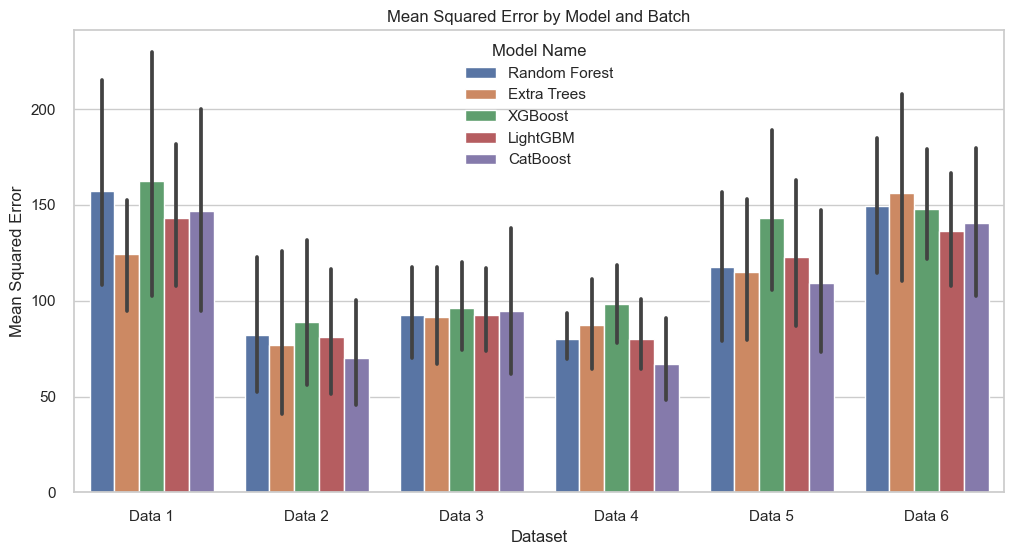

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'batch_concat' is your DataFrame
sns.set(style="whitegrid")

# Plot for Mean Squared Error
plt.figure(figsize=(12, 6))
sns.barplot(x='Dataset', y='Mean Squared Error', hue='Model Name', data=batch_concat)
plt.title('Mean Squared Error by Model and Batch')
plt.legend(title='Model Name')
plt.show()

# Repeat similar plots for 'Root Mean Squared Error' and 'R2 Score'


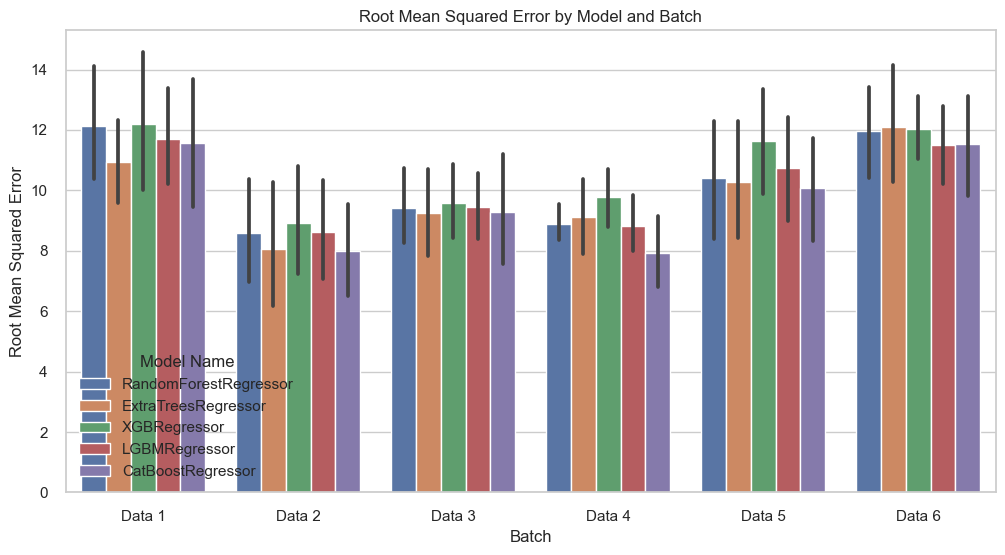

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'batch_concat' is your DataFrame
sns.set(style="whitegrid")

# Plot for Mean Squared Error
plt.figure(figsize=(12, 6))
sns.barplot(x='Batch', y='Root Mean Squared Error', hue='Model Name', data=batch_concat)
plt.title('Root Mean Squared Error by Model and Batch')
plt.legend(title='Model Name')
plt.show()

# Repeat similar plots for 'Root Mean Squared Error' and 'R2 Score'


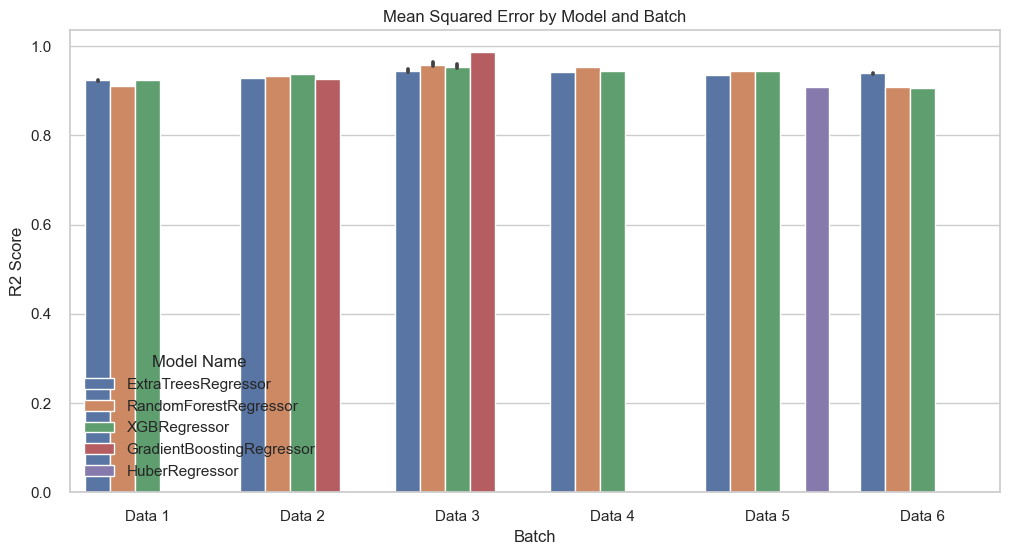

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'batch_concat' is your DataFrame
sns.set(style="whitegrid")

# Plot for Mean Squared Error
plt.figure(figsize=(12, 6))
sns.barplot(x='Batch', y='R2 Score', hue='Model Name', data=batch_concat)
plt.title('Mean Squared Error by Model and Batch')
plt.legend(title='Model Name')
plt.show()

# Repeat similar plots for 'Root Mean Squared Error' and 'R2 Score'


In [ ]:
batch_concat.sort_values(['Mean Squared Error', 'Root Mean Squared Error'], ascending=[True, True]).groupby('Batch').head(2)

Model Name  Mean Squared Error  Root Mean Squared Error  R2 Score                                   Model Parameters  Cross-Validation Fold Index     Model Key   Batch
85   ExtraTreesRegressor           18.991532                 4.357927  0.988403  {'bootstrap': False, 'ccp_alpha': 0.0, 'criter...                            4  ExtraTrees_4  Data 2
73   ExtraTreesRegressor           21.330814                 4.618529  0.985867  {'bootstrap': False, 'ccp_alpha': 0.0, 'criter...                            2  ExtraTrees_2  Data 2
202    CatBoostRegressor           23.492807                 4.846938  0.983945                          {'loss_function': 'RMSE'}                            3    CatBoost_3  Data 4
151  ExtraTreesRegressor           27.856281                 5.277905  0.979553  {'bootstrap': False, 'ccp_alpha': 0.0, 'criter...                            5  ExtraTrees_5  Data 3
160    CatBoostRegressor           29.752455                 5.454581  0.977614                          {'loss_function': 'RMSE'}                            6    CatBoost_6  Data 3
295  ExtraTreesRegressor           30.790787                 5.548945  0.981498  {'bootstrap': False, 'ccp_alpha': 0.0, 'criter...                            9  ExtraTrees_9  Data 5
16     CatBoostRegressor           32.955396                 5.740679  0.979206                          {'loss_function': 'RMSE'}                            2    CatBoost_2  Data 1
232    CatBoostRegressor           33.971153                 5.828478  0.977216                          {'loss_function': 'RMSE'}                            8    CatBoost_8  Data 4
298    CatBoostRegressor           34.009487                 5.831765  0.979564                          {'loss_function': 'RMSE'}                            9    CatBoost_9  Data 5
13   ExtraTreesRegressor           45.446522                 6.741404  0.971325  {'bootstrap': False, 'ccp_alpha': 0.0, 'criter...                            2  ExtraTrees_2  Data 1
349  ExtraTreesRegressor           49.995896                 7.070778  0.962233  {'bootstrap': False, 'ccp_alpha': 0.0, 'criter...                            8  ExtraTrees_8  Data 6
352    CatBoostRegressor           52.655368                 7.256402  0.960224                          {'loss_function': 'RMSE'}                            8    CatBoost_8  Data 6

In [ ]:
batch_concat.query(' Batch == "Data 3" ').head()

Model Name  Mean Squared Error  Root Mean Squared Error  R2 Score                                   Model Parameters  Cross-Validation Fold Index       Model Key   Batch
120  RandomForestRegressor           92.345360                 9.609649  0.935335  {'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...                            0  RandomForest_0  Data 3
121    ExtraTreesRegressor           97.872377                 9.893047  0.931465  {'bootstrap': False, 'ccp_alpha': 0.0, 'criter...                            0    ExtraTrees_0  Data 3
122           XGBRegressor           80.203891                 8.955663  0.943837  {'objective': 'reg:squarederror', 'base_score'...                            0       XGBoost_0  Data 3
123          LGBMRegressor           75.309647                 8.678113  0.947264  {'boosting_type': 'gbdt', 'class_weight': None...                            0      LightGBM_0  Data 3
124      CatBoostRegressor           89.467466                 9.458724  0.937350                          {'loss_function': 'RMSE'}                            0      CatBoost_0  Data 3

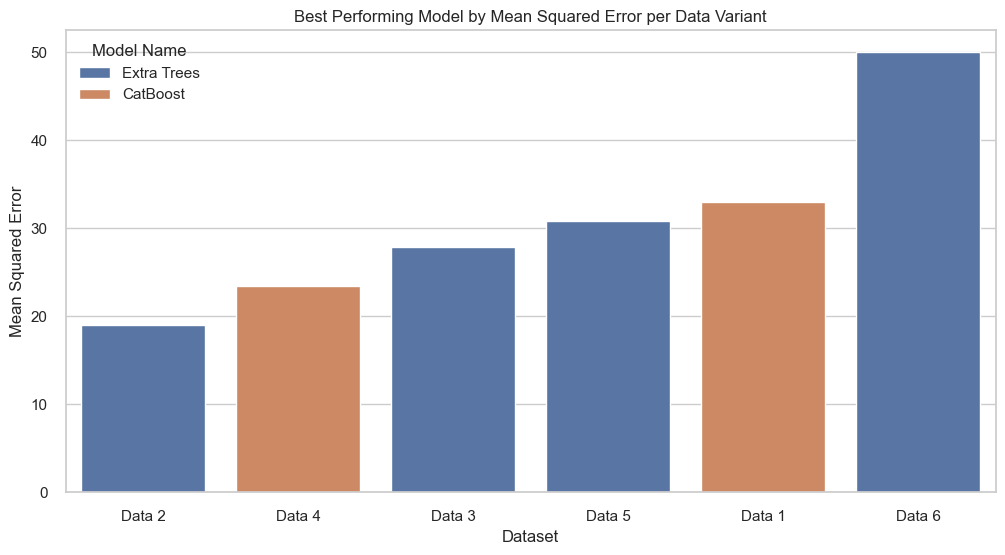

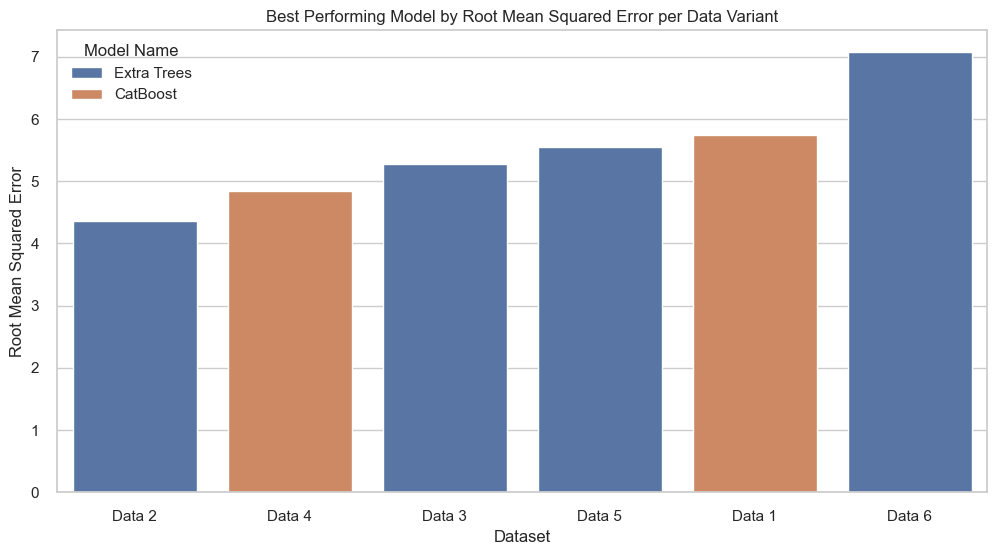

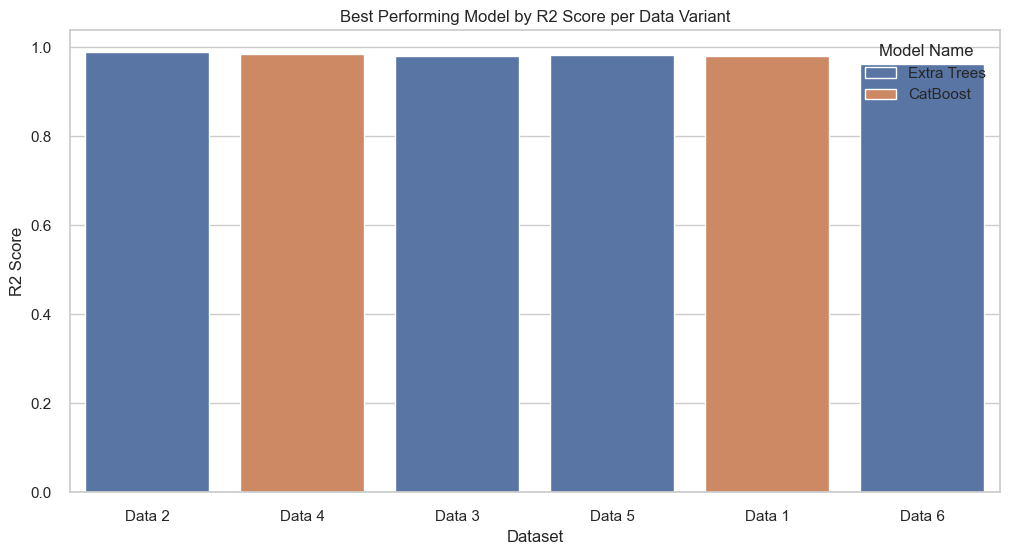

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'best_models' is your DataFrame containing the best model for each batch
best_models = batch_concat.sort_values(['Mean Squared Error', 'Root Mean Squared Error'], ascending=[True, True]).groupby('Dataset').head(1)

# Plot for Mean Squared Error
plt.figure(figsize=(12, 6))
sns.barplot(x='Dataset', y='Mean Squared Error', hue='Model Name', data=best_models, dodge=False)
plt.title('Best Performing Model by Mean Squared Error per Data Variant')
plt.legend(title='Model Name')
plt.show()

# Plot for Root Mean Squared Error
plt.figure(figsize=(12, 6))
sns.barplot(x='Dataset', y='Root Mean Squared Error', hue='Model Name', data=best_models, dodge=False)
plt.title('Best Performing Model by Root Mean Squared Error per Data Variant')
plt.legend(title='Model Name')
plt.show()

# Plot for R2 Score
plt.figure(figsize=(12, 6))
sns.barplot(x='Dataset', y='R2 Score', hue='Model Name', data=best_models, dodge=False)
plt.title('Best Performing Model by R2 Score per Data Variant')
plt.legend(title='Model Name')
plt.show()

In [ ]:
best_models

Model Name  Mean Squared Error  Root Mean Squared Error  R2 Score                                   Model Parameters  Cross-Validation Fold Index     Model Key Dataset
85   Extra Trees           18.991532                 4.357927  0.988403  {'bootstrap': False, 'ccp_alpha': 0.0, 'criter...                            4  ExtraTrees_4  Data 2
202     CatBoost           23.492807                 4.846938  0.983945                          {'loss_function': 'RMSE'}                            3    CatBoost_3  Data 4
151  Extra Trees           27.856281                 5.277905  0.979553  {'bootstrap': False, 'ccp_alpha': 0.0, 'criter...                            5  ExtraTrees_5  Data 3
295  Extra Trees           30.790787                 5.548945  0.981498  {'bootstrap': False, 'ccp_alpha': 0.0, 'criter...                            9  ExtraTrees_9  Data 5
16      CatBoost           32.955396                 5.740679  0.979206                          {'loss_function': 'RMSE'}                            2    CatBoost_2  Data 1
349  Extra Trees           49.995896                 7.070778  0.962233  {'bootstrap': False, 'ccp_alpha': 0.0, 'criter...                            8  ExtraTrees_8  Data 6

In [ ]:
batch_concat.query(' `Cross-Validation Fold Index` == 4' ).sort_values(['Mean Squared Error', 'Root Mean Squared Error'], ascending=[True, True]).head()

Model Name  Mean Squared Error  Root Mean Squared Error  R2 Score                                   Model Parameters  Cross-Validation Fold Index       Model Key   Batch
97   RandomForestRegressor           72.030307                 8.487067  0.954616  {'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...                            4  RandomForest_4  Data 3
137  RandomForestRegressor           75.559184                 8.692479  0.952250  {'bootstrap': True, 'ccp_alpha': 0.0, 'criteri...                            4  RandomForest_4  Data 4
99            XGBRegressor           79.155457                 8.896935  0.950127  {'objective': 'reg:squarederror', 'base_score'...                            4       XGBoost_4  Data 3
139           XGBRegressor           89.513945                 9.461181  0.943431  {'objective': 'reg:squarederror', 'base_score'...                            4       XGBoost_4  Data 4
98     ExtraTreesRegressor           90.418200                 9.508848  0.943031  {'bootstrap': False, 'ccp_alpha': 0.0, 'criter...                            4    ExtraTrees_4  Data 3

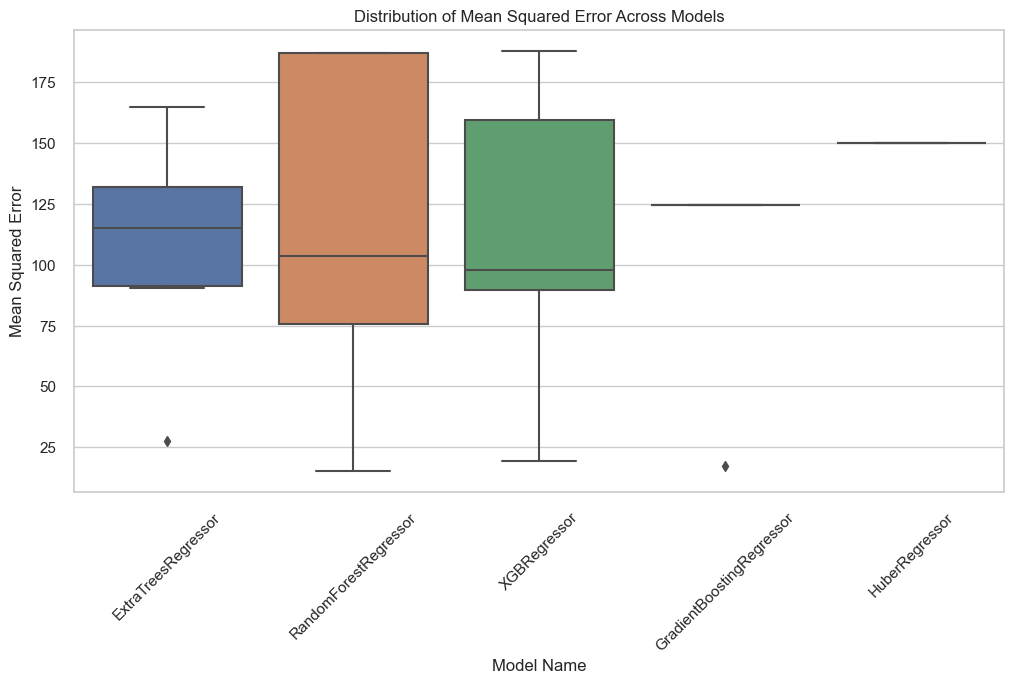

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Model Name', y='Mean Squared Error', data=batch_concat)
plt.title('Distribution of Mean Squared Error Across Models')
plt.xticks(rotation=45)  # Rotate model names for better readability
plt.show()


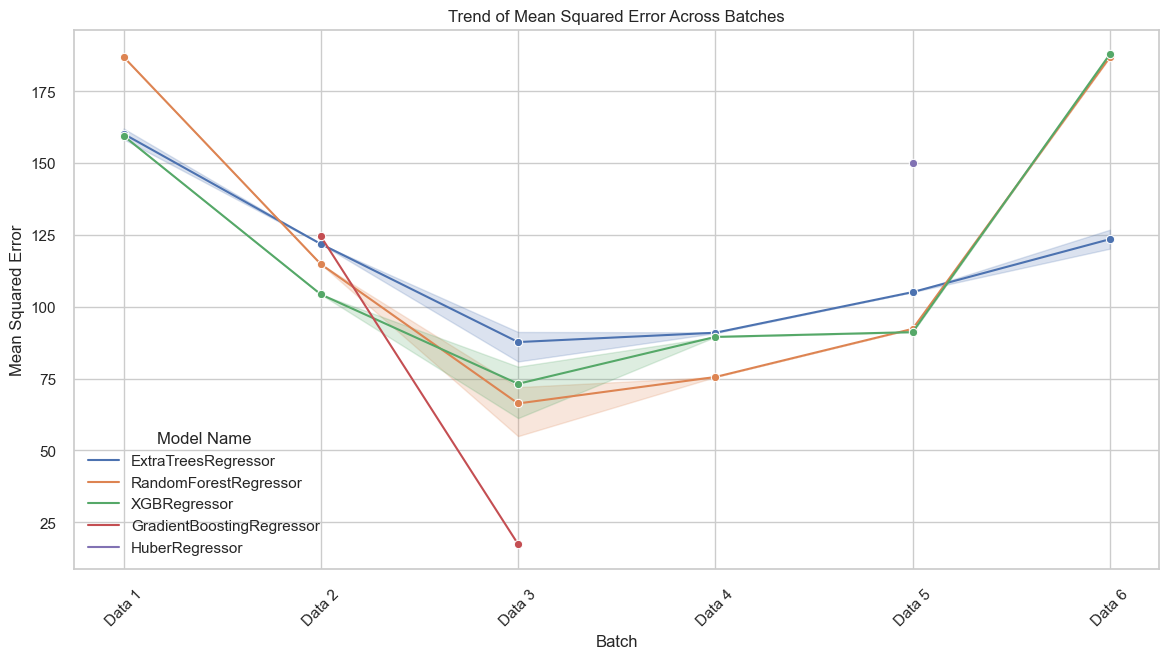

In [ ]:
plt.figure(figsize=(14, 7))
sns.lineplot(x='Batch', y='Mean Squared Error', hue='Model Name', marker='o', data=batch_concat)
plt.title('Trend of Mean Squared Error Across Batches')
plt.xticks(rotation=45)
plt.legend(title='Model Name')
plt.show()


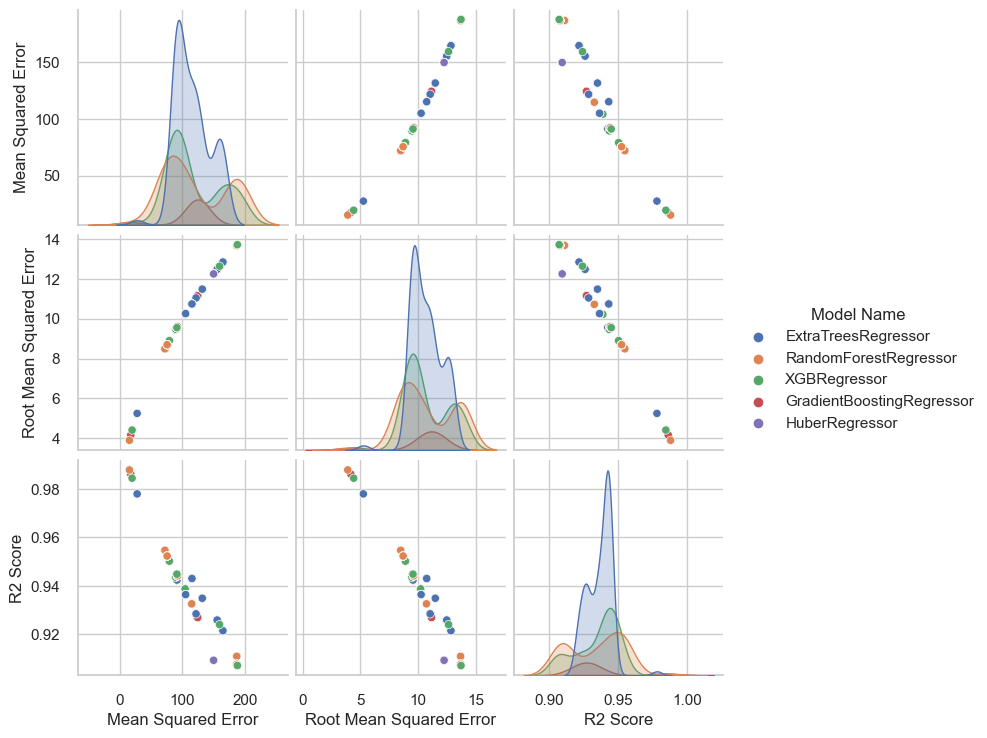

In [ ]:
sns.pairplot(data=batch_concat, vars=['Mean Squared Error', 'Root Mean Squared Error', 'R2 Score'], hue='Model Name')
plt.show()


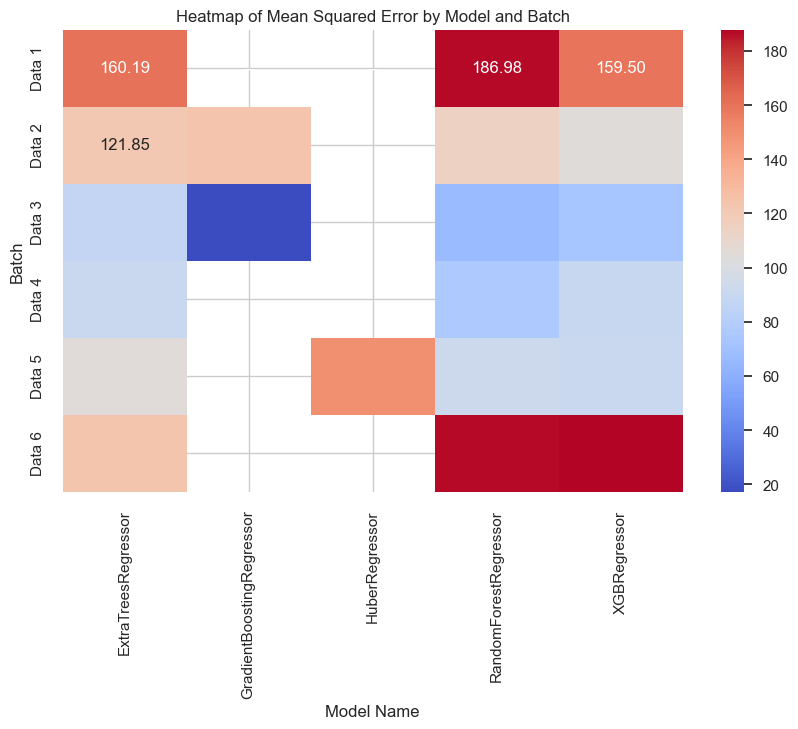

In [ ]:
# Creating a pivot table for the heatmap
performance_pivot = batch_concat.pivot_table(values='Mean Squared Error', index='Batch', columns='Model Name')

plt.figure(figsize=(10, 6))
sns.heatmap(performance_pivot, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Heatmap of Mean Squared Error by Model and Batch')
plt.show()


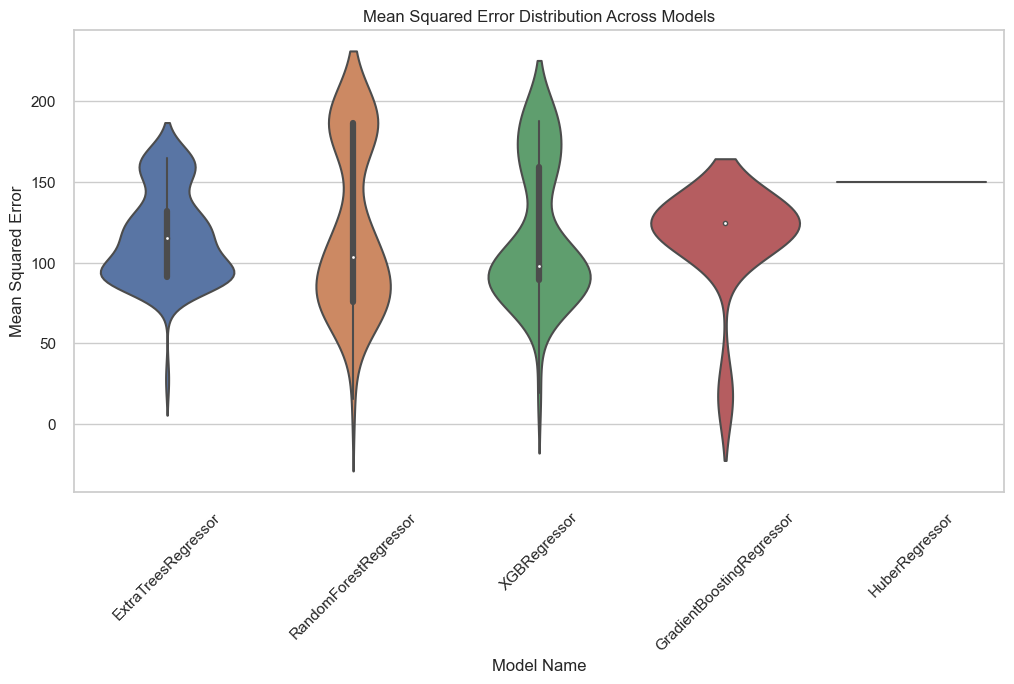

In [ ]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='Model Name', y='Mean Squared Error', data=batch_concat)
plt.title('Mean Squared Error Distribution Across Models')
plt.xticks(rotation=45)
plt.show()


> View Performance metrics

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score


def print_regression_performance_report(
    model, X_test, y_test, sarimax_model=True, action="set"):
    """
    Program: print_regression_performance_report
    Author: Siraprapa W.
    Purpose: Print standard regression metrics report and generate visualizations.
    """

    if action == "set":
        if "input_Timepoint (hr)" in X_test.columns:
            X_test = set_reset_index(X_test, action=action)
        else:
            pass  # Handle cases where there is no time index
    else:
        X_test = set_reset_index(X_test, action=action)
    if sarimax_model == True:
        y_pred = model.get_forecast(
            steps=len(X_test), exog=X_test
        ).predicted_mean.values
    else:
        y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print("Mean Squared Error (MSE): {:.4f}".format(mse))
    print("Root Mean Squared Error (RMSE): {:.4f}".format(rmse))
    print("R-squared (R2): {:.4f}".format(r2))
    # Add additional regression metrics and visualizations here
    # Plot actual vs predicted values
    plt.scatter(y_test, y_pred)
    plt.plot(
        [min(y_test), max(y_test)],
        [min(y_test), max(y_test)],
        color="red",
        linestyle="--",
    )

    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs Predicted")
    plt.show()

    return mse, rmse, r2, y_pred

In [ ]:
mse, rmse, r2, y_pred = print_regression_performance_report(
    model_fit, X_test, y_test, True, "set"
)  # SARIMAX model

NameError: name 'model_fit' is not defined

In [ ]:
mse, rmse, r2, y_pred = print_regression_performance_report(
    xgb_model_fit, X_test, y_test, False, "reset"
)

In [ ]:
# from yellowbrick.datasets import load_concrete
# from yellowbrick.regressor import ResidualsPlot


# visualizer = ResidualsPlot(model)

# visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
# visualizer.score(X_test, y_test)  # Evaluate the model on the test data
# visualizer.show()                 # Finalize and render the figure

In [ ]:
# from sklearn.model_selection import learning_curve

# train_sizes, train_scores, test_scores = learning_curve(estimator=xgb_model_fit, X=X_train, y=y_train, cv=5)
# train_scores_mean = np.mean(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)

# plt.plot(train_sizes, train_scores_mean, label='Training score')
# plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
# plt.xlabel('Training examples')
# plt.ylabel('Score')
# plt.title('Learning Curve')
# plt.legend()
# plt.show()


In [ ]:
from yellowbrick.regressor import ResidualsPlot
import matplotlib.font_manager
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager


def residual_plot(model, X_train, y_train, X_test, y_test, action="set"):
    """
    Program: print_regression_performance_report
    Author: Siraprapa W.

    Purpose: Print standard regression metrics report and generate visualizations.
    """
    if action == "set":
        if "input_Timepoint (hr)" in X_test.columns:
            X_test = set_reset_index(X_test, action=action)
        else:
            pass  # Handle cases where there is no time index
    else:
        X_test = set_reset_index(X_test, action=action)

    visualizer = ResidualsPlot(xgb_model_fit, hist=False)
    visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
    visualizer.score(X_test, y_test)  # Evaluate the model on the test data
    visualizer.show()  # Finalize and render the figure

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score


xgb_model_fit.fit(X_train, y_train)

# Make predictions
y_train_pred = xgb_model_fit.predict(X_train)
y_test_pred = xgb_model_fit.predict(X_test)

# Compute the residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

# Calculate the R-squared values
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Create the residual plots
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plots for training and testing residuals
sns.scatterplot(
    x=y_train_pred,
    y=train_residuals,
    ax=ax,
    color="blue",
    alpha=0.5,
    label=f"Train R² = {train_r2:.3f}",
)
sns.scatterplot(
    x=y_test_pred,
    y=test_residuals,
    ax=ax,
    color="green",
    alpha=0.5,
    label=f"Test R² = {test_r2:.3f}",
)

# Plot a line at 0 for residuals
ax.axhline(y=0, color="black", linestyle="--")

# Annotations and labels
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Residuals")
ax.set_title("Residuals for Ridge Model")

# Plot histograms for residuals
sns.histplot(
    train_residuals,
    kde=True,
    color="blue",
    ax=ax,
    stat="density",
    element="step",
    alpha=0.3,
)
sns.histplot(
    test_residuals,
    kde=True,
    color="green",
    ax=ax,
    stat="density",
    element="step",
    alpha=0.3,
)

# Show legend and plot
ax.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names and data
models = ["Linear Regression", "XGBoost", "SARIMAX"]

mse = [
    # Data 1
    [118.59194508422084, 40.62359283670584, 107.23563874099641],
    # Data 2
    [37.84093283149445, 247.9630739752672, 109.32773828962365],
    # Data 3
    [37.84093283149445, 247.9630739752672, 109.32773828962365],
]

rmse = [
    # Data 1
    [10.889992887243814, 6.373664004064368, 10.355464197272685],
    # Data 2
    [6.151498421644473, 15.74684330192141, 10.45599054559747],
    # Data 3
    [6.151498421644473, 15.74684330192141, 10.45599054559747],
]

r2 = [
    # Data 1
    [0.8962165146364349, 0.9644490353068284, 0.9061547701589259],
    # Data 2
    [0.9679486878029661, 0.7899750005448363, 0.9073992840683901],
    # Data 3
    [0.9679486878029661, 0.7899750005448363, 0.9073992840683901],
]


batches = ["Data 1", "Data 2", "Data 3"]

# Create the figure and axes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Calculate the positions of bars
index = np.arange(len(models))
bar_width = 0.2
opacity = 0.8

# Plotting MSE and RMSE as bar plots
for i, model in enumerate(models):
    mse_values = [mse[j][i] for j in range(len(batches))]
    rmse_values = [rmse[j][i] for j in range(len(batches))]

    axs[0].bar(index + i * bar_width, mse_values, bar_width, alpha=opacity, label=model)
    axs[1].bar(
        index + i * bar_width, rmse_values, bar_width, alpha=opacity, label=model
    )

# Plotting R2 as a horizontal bar plot
for i, model in enumerate(models):
    r2_values = [r2[j][i] for j in range(len(batches))]
    positions = index + i * bar_width  # Horizontal bar positions
    axs[2].barh(positions, r2_values, bar_width, alpha=opacity, label=model)

# Setting the labels and titles

# axs[0].set_title('MSE by Model')
# axs[1].set_title('RMSE by Model')
# axs[2].set_title('R2 by Model')
axs[0].set_xticks(index + bar_width / 2, batches)
axs[1].set_xticks(index + bar_width / 2, batches)
axs[2].set_yticks(index + bar_width / 2, batches)  # Adjust for horizontal bar plot
axs[0].set_ylabel("MSE")
axs[1].set_ylabel("RMSE")
axs[2].set_xlabel("R-squared")  # X-axis for horizontal bar plot
# axs[2].set_xlabel(r'$R^2$')  # X-axis for horizontal bar plot

# Adding legends
axs[0].legend(loc="upper left")
axs[1].legend(loc="upper left")
# Use bbox_to_anchor to move the legend slightly lower than the center right
axs[2].legend(loc="center right", bbox_to_anchor=(1, 0.32))

# remove grids
axs[0].grid(False)
axs[1].grid(False)
axs[2].grid(False)

# Show plot
plt.tight_layout()
plt.show()

In [ ]:
#Regression performance report 

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score


mse, rmse, r2, y_pred = print_regression_performance_report(model_fit, X_test, y_test)

#Regression
    # Error = Actual value - Predicted value

    # MSE (Mean Square Error)
        # The square of the error over all samples is called Mean Squarred Error(MSE).
        # MSE = SQUARE(Actual value - Predicted value)/Number of Samples
    #RMSE (Root Mean Square Error)
    # MAE (Mean Absolute Error)
        # MAE = ABSOLUTE (Actual value - Predicted Value)


In [ ]:
import joblib

# Specify the filename for the saved model
model_filename = "sarimax_model.joblib"
joblib.dump(
    model_fit_2, f"models/{model_filename}"
)  # Save the trained SARIMAX model to file


# save the scaler
scaler_filename = "scaler.joblib"
joblib.dump(scaler, f"models/{scaler_filename}")  # Save the trained scaler to file


# Open a file in write-binary (wb) mode and save the model

print(f"Model saved to {model_filename}")

>> Learning Curve (Access the Bias and Variance) - Model Diagnostics

- `Bias` - error in the training data

- `Variance` -> difference in the errors between the train and test data. (i.e.,  it examines how the model's performance varies between the training data and unseen data (like a validation set).  If the model performs well on the training data but poorly on the validation/test data, it suggests high variance)


`High Bias (will also have High Variance) -> Underfitting:` The model is too simple and doesn't capture the complexities of the data well, leading to poor performance on both training and testing datasets.

`Low Bias + High Variance -> Overfitting:` The model is too complex, fitting too closely to the training data, including its noise and outliers. It performs well on training data but poorly on unseen data.

`Low Bias + Low Variance -> Ideal Model:` This is the desired outcome. The model accurately captures the underlying patterns in the data (low bias) and generalizes well to unseen data (low variance).

<p align="center">
  <img src="learning-curves.png" alt="Example Image"/>
</p>



In [ ]:

#check Bias and Variance using Learnng Curve 


from yellowbrick.model_selection import LearningCurve

sizes = np.linspace(0.1, 1.0, 10) # Define the training set sizes to plot the learning curve

visualizer = LearningCurve(
    xgb_model_fit, cv=5, scoring='r2', train_sizes=sizes, n_jobs=4  #or use scoring = 'neg_mean_squared_error'
        )
visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure


# To fix high bias (underfitting):
    # get additional features or increasing the size of the model 
    # Adding polynomial features is a form of feature engineering that can increase the complexity of the model
    # decrease the regularization parameter (lambda) to allow the model's learning algorithm to fit the data more flexibly, 
        # thereby potentially reducing bias

# To fix high variance (overfitting):
    # Obtaining more training samples can help the model generalize better.
    # Simplifying the model by reducing the number of features (feature selection) can prevent the model from fitting noise in the 
        # training data.
    # Increasing the regularization parameter (lambda) adds a penalty to the model complexity, which can help in preventing overfitting.


> Cross Validation Scores

In [ ]:
from sklearn.model_selection import (
    learning_curve,
    cross_val_score,
    KFold,
    train_test_split,
)
from yellowbrick.model_selection import (
    CVScores,
)  # visualizing the cross validation scores

# check Bias and Variance using Cross Validation

cv = 5  # or # Create a cross-validation object:
# cv = KFold(n_splits=5, shuffle=True, random_state=42)

visualizer = CVScores(xgb_model_fit, cv=cv, scoring="neg_mean_squared_error")

visualizer.fit(X_train, y_train)  # Fit the data to the visualizer
visualizer.show()  # Finalize and render the figure

> Plot Validation Curves (to analyse the impact of each Hyperparameter)

In [ ]:
# to analyze the impact of varying hyperparameter values on the model's performance using Validation curve
# the validation curve is useful for hyperparameter tuning, while the learning curve is used to assess bias and variance.

# Using validation curves is a fundamental aspect of machine learning model tuning, as it provides valuable insights into how
# hyperparameters influence model performance, aiding in the selection of the most appropriate model settings.

from sklearn.model_selection import validation_curve


# the hyperparameter used here is 'max_depth'. A hyperparameter for the model ExtraTreeRegressor

plot_validation_curve(
    model, X_train, y_train, param_name="max_depth", cv=5, scoring="r2"
)

In [ ]:
from yellowbrick.model_selection import ValidationCurve

# cv = StratifiedKFold(4)
viz = ValidationCurve(
    xgb_model_fit,
    param_name="max_depth",
    param_range=np.arange(1, 11),
    cv=10,
    scoring="r2",
)

# Fit and show the visualizer
viz.fit(X, y)
viz.show()

>> Analyze Error Distribution

In [ ]:
# if the errors are normally distributed around zero, it may indicate that the model is making unbiased predictions. 
# If there is a pattern or trend in the errors, it may suggest that the model has systematic biases or is making 
# consistent errors in certain regions of the input space


analyze_error_distribution(y_val, y_pred)

>> Error Analysis - Diagnostics

In [ ]:
#Error analysis is the process of analyzing the errors made by a machine learning model and identifying the patterns 
# or trends that may be causing the errors. The goal of error analysis is to gain insight into the behavior of the 
# model and identify areas for improvement. 

# The steps involved in error analysis:
    # 1. Collect error data - Gather instances where the model made incorrect predictions.
    # 2. Categorize errors - Classify errors into meaningful categories.
    # 3. Identify patterns - Look for commonalities or trends among the errors.
    # 4. Analyze causes - Investigate potential reasons behind these patterns.
    # 5. Prioritize fixes - Decide which errors to address first based on their impact.

    
# Based on the insights gained from the error analysis, you can perform the following.

# False negatives: 
    # To fix this issue, you may consider the following:
        # Increase the weight of the features that are more indicative of churn for low-usage customers, 
            # such as frequency of usage or specific product usage. (adjust the model parameters)
        # Add new features that may be predictive of churn, such as customer sentiment or customer service interactions.
        # Use a different model architecture that is better suited for handling imbalanced data, such as a decision tree 
            # or ensemble model. 


# False positives:
    # To fix this issue, you may consider the following:
        # Decrease the weight of features that are causing false positives, such as age or income, if they are not as 
            # indicative of churn for low-usage customers. (adjust the model parameters)
        # Remove features that are causing false positives altogether, if they are not providing significant value to the 
            # model.
        # Increase the size of the training dataset to capture a more representative sample of customers who do not churn, 
            # which may help the model learn more accurately which customers are likely to churn.


## Model Optimization

>> Auto Hyperparameter Optimization using Optuna

In [ ]:
# Data 2


experiment_names_optim = ['exp_210623_1', 'exp_210623_2', 'exp_210623_3', 'exp_210623_4', 
                    'exp_211013_1', 'exp_211013_2', 'exp_211013_3', 'exp_211013_4', 
                    'exp_211130_1', 'exp_211130_2', 'exp_211130_3', 'exp_211130_4', 
                    'exp_220309demo_1', 'exp_220309demo_2', 'exp_220309demo_3', 'exp_220309demo_4',
                    'exp_220315c1_1', 'exp_220315c1_2', 'exp_220315c1_3', 
                    'exp_220822_1', 'exp_220822_2', 'exp_220822_3', 'exp_220822_4']



from sklearn.utils import shuffle
from collections import defaultdict




def load_data(batch_names):
    df_list = []
    for b_name in batch_names:
        df = pd.read_csv(f"data/final_cleaned/{b_name}.csv")
        df = drop_invariant_columns(df)
        df.name = b_name
        df['batch'] = b_name
        df_list.append(df)
        
    return df_list   


def concatenate_impute_split(experiment_names):
    # Load data
    df_list = load_data(experiment_names)

    # Concatenate all data into a single DataFrame
    full_data = pd.concat(df_list, ignore_index=True)

    full_data_inputed = impute_missing_values_iteratively(full_data)  # Impute missing values iteratively to avoid over-fitting on the test set
    full_data_cyclical_time = add_cyclical_time_features(full_data_inputed, time_column = 'input_Timepoint (hr)', cycle_period = 48.0)    # Add cyclical time features
    

    # Split the data back into the original batches using the 'batch' column and return as a list
    batched_dataframes_list = [group.drop('batch', axis=1) for _, group in full_data_cyclical_time.groupby('batch', sort=False)]
    
    return batched_dataframes_list



def cross_validation_with_shuffling_optim(experiment_names, params, n_splits=5):
    # results = []
    
    df_batch_list = concatenate_impute_split(experiment_names)
    
    # Initialize dictionaries to store models and their infos
    models_dict = {} 
    model_infos_dict = defaultdict(list)
    
    # pycaret_models = []
    for fold in range(n_splits):
        # Shuffle the batch list
        shuffled_indices = np.random.permutation(len(df_batch_list))
        shuffled_batches = [df_batch_list[i] for i in shuffled_indices]
        
        # Split into train and test sets
        split_index = int(len(shuffled_batches) * 0.8)  # 80% for training, 20% for testing
        train_batches = shuffled_batches[:split_index]
        test_batches = shuffled_batches[split_index:]

######################################################################################################################## 
        # Trial and Error: scale and cocatenate the dataset
        train_df = pd.concat(train_batches, ignore_index=True)
        test_df = pd.concat(test_batches, ignore_index=True) 
        
        train_df, scaler = scale_and_concat(train_df, train = True)
        test_df = scale_and_concat(test_df, train = False, scaler = scaler)

########################################################################################################################
        
        # Split the DataFrames into features and target variables
        X_train, y_train = train_df.drop('output_OD600', axis = 1) , train_df['output_OD600']
        X_test, y_test = test_df.drop('output_OD600', axis = 1) , test_df['output_OD600']
        
        # Polynomial Feature Extraction and then Feature Selection using Recursive feature elimination (RFE)
        X_train, X_test, selector = add_polynomial_features_sklearn(X_train, X_test, degree=2, columns=important_features, prefix='poly_')
        X_train, X_test, rfe_model = feature_selection_rfe(X_train, y_train, X_test, num_features_to_select=int(X_train.shape[1] * 0.8))
        X_train, X_test, fs_model = feature_selection_with_model(X_train, y_train, X_test, threshold="median")
        save_models([scaler, selector, rfe_model, fs_model], fold, base_dir="models/preprocessing/hyper_optim/model")
        
        save_csv(X_train, X_test, y_train, y_test, 'data/use_to_code/hyper_optim/data', fold) # Save the training and test sets to CSV
        print(f'Performance of the models on fold {fold}:')
        
        # Train and evaluate models
        et_info, _ = train_evaluate_extratrees(X_train, y_train, X_test, y_test, params = params, fold_index=fold)   
    
    return et_info['Mean Squared Error']




In [ ]:
# Set the logging level for Optuna to WARNING
# logging.getLogger('optuna').setLevel(logging.WARNING)


import optuna

def objective(trial):
    # Define the hyperparameters' search space for Extra Trees Regressor
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 5, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 15)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 15)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])

    # Create the Extra Trees Regressor model with the suggested hyperparameters
    params = {
        'n_estimators': n_estimators,  # Use colon for assignment
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'max_features': max_features,
        'n_jobs': -1,  # Use all available cores
        'random_state': 42  # For reproducibility
    }
    
    mse = cross_validation_with_shuffling_optim(experiment_names_optim, params, n_splits=10)
    
   # Since it's a negative score, we negate it to make it positive. Lower MSE is better.
    return mse

# Create and run the study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# Best hyperparameters
best_hyperparams = study.best_trial.params
# print('Best Hyperparameters:', best_hyperparams)

[I 2024-03-14 20:09:37,026] A new study created in memory with name: no-name-dfd6d952-b3b8-4299-87bd-daf8707f1e8e


Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 79.95956075883403
Root Mean Squared Error for ExtraTreesRegressor: 8.942011001941008
R2 Score for ExtraTreesRegressor: 0.9476890081592146
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_1.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_1.joblib
Model RFE saved in models/preprocessing/hyper_optim/mode

[I 2024-03-14 20:15:17,463] Trial 0 finished with value: 92.5840287116554 and parameters: {'n_estimators': 166, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 0 with value: 92.5840287116554.


Mean Squared Error for ExtraTreesRegressor: 92.5840287116554
Root Mean Squared Error for ExtraTreesRegressor: 9.622059483897166
R2 Score for ExtraTreesRegressor: 0.9505260041647271
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 88.43978166661985
Root Mean Squared Error for ExtraTreesRegressor: 9.404242748175944
R2 Score for ExtraTreesRegressor: 0.9446487640401308
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_1.

[I 2024-03-14 20:21:05,630] Trial 1 finished with value: 82.54489241428644 and parameters: {'n_estimators': 293, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 0 with value: 92.5840287116554.


Mean Squared Error for ExtraTreesRegressor: 82.54489241428644
Root Mean Squared Error for ExtraTreesRegressor: 9.0854219722744
R2 Score for ExtraTreesRegressor: 0.9466506871369352
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 207.94709980970484
Root Mean Squared Error for ExtraTreesRegressor: 14.420371001111755
R2 Score for ExtraTreesRegressor: 0.8690779052656026
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_1

[I 2024-03-14 20:26:08,648] Trial 2 finished with value: 416.10520983571536 and parameters: {'n_estimators': 226, 'max_depth': 44, 'min_samples_split': 12, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 2 with value: 416.10520983571536.


Mean Squared Error for ExtraTreesRegressor: 416.10520983571536
Root Mean Squared Error for ExtraTreesRegressor: 20.398657059613395
R2 Score for ExtraTreesRegressor: 0.811600755930807
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 201.13380856936598
Root Mean Squared Error for ExtraTreesRegressor: 14.182165158020336
R2 Score for ExtraTreesRegressor: 0.8884662224882682
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScale

[I 2024-03-14 20:31:13,436] Trial 3 finished with value: 106.67759214608033 and parameters: {'n_estimators': 165, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 2 with value: 416.10520983571536.


Mean Squared Error for ExtraTreesRegressor: 106.67759214608033
Root Mean Squared Error for ExtraTreesRegressor: 10.328484503840839
R2 Score for ExtraTreesRegressor: 0.9373619611670585
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 106.66148983159133
Root Mean Squared Error for ExtraTreesRegressor: 10.327704964395107
R2 Score for ExtraTreesRegressor: 0.9352086128124181
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScal

[I 2024-03-14 20:36:19,613] Trial 4 finished with value: 120.29000801532827 and parameters: {'n_estimators': 288, 'max_depth': 24, 'min_samples_split': 10, 'min_samples_leaf': 9, 'max_features': 'log2'}. Best is trial 2 with value: 416.10520983571536.


Mean Squared Error for ExtraTreesRegressor: 120.29000801532827
Root Mean Squared Error for ExtraTreesRegressor: 10.967680156502023
R2 Score for ExtraTreesRegressor: 0.9307179104270934
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 65.1988831009271
Root Mean Squared Error for ExtraTreesRegressor: 8.074582534157855
R2 Score for ExtraTreesRegressor: 0.951575286557062
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_1

[I 2024-03-14 20:41:12,682] Trial 5 finished with value: 180.38217284009113 and parameters: {'n_estimators': 244, 'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'log2'}. Best is trial 2 with value: 416.10520983571536.


Mean Squared Error for ExtraTreesRegressor: 180.38217284009113
Root Mean Squared Error for ExtraTreesRegressor: 13.430643053856027
R2 Score for ExtraTreesRegressor: 0.9079073770210246
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 128.61923086192974
Root Mean Squared Error for ExtraTreesRegressor: 11.341041877267262
R2 Score for ExtraTreesRegressor: 0.8930313459205201
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScal

[I 2024-03-14 20:46:19,105] Trial 6 finished with value: 100.62648709552285 and parameters: {'n_estimators': 130, 'max_depth': 37, 'min_samples_split': 15, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 2 with value: 416.10520983571536.


Mean Squared Error for ExtraTreesRegressor: 100.62648709552285
Root Mean Squared Error for ExtraTreesRegressor: 10.031275447096588
R2 Score for ExtraTreesRegressor: 0.9268593025376347
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 74.0764590875478
Root Mean Squared Error for ExtraTreesRegressor: 8.606768213885385
R2 Score for ExtraTreesRegressor: 0.9483966811854232
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_

[I 2024-03-14 20:51:12,532] Trial 7 finished with value: 82.19377041159872 and parameters: {'n_estimators': 132, 'max_depth': 50, 'min_samples_split': 11, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 2 with value: 416.10520983571536.


Mean Squared Error for ExtraTreesRegressor: 82.19377041159872
Root Mean Squared Error for ExtraTreesRegressor: 9.066078006039806
R2 Score for ExtraTreesRegressor: 0.9483053125571461
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 253.37739117362452
Root Mean Squared Error for ExtraTreesRegressor: 15.917832489809173
R2 Score for ExtraTreesRegressor: 0.8685548331996941
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler

[I 2024-03-14 20:56:17,096] Trial 8 finished with value: 182.5410616510803 and parameters: {'n_estimators': 123, 'max_depth': 23, 'min_samples_split': 10, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 2 with value: 416.10520983571536.


Mean Squared Error for ExtraTreesRegressor: 182.5410616510803
Root Mean Squared Error for ExtraTreesRegressor: 13.510775760520945
R2 Score for ExtraTreesRegressor: 0.9017024731111513
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 117.08065773467489
Root Mean Squared Error for ExtraTreesRegressor: 10.820381589143466
R2 Score for ExtraTreesRegressor: 0.917876478654895
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler

[I 2024-03-14 21:01:42,427] Trial 9 finished with value: 43.54095153948818 and parameters: {'n_estimators': 85, 'max_depth': 42, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': None}. Best is trial 2 with value: 416.10520983571536.


Mean Squared Error for ExtraTreesRegressor: 43.54095153948818
Root Mean Squared Error for ExtraTreesRegressor: 6.598556777014817
R2 Score for ExtraTreesRegressor: 0.9657564382231525
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 11.566324678321003
Root Mean Squared Error for ExtraTreesRegressor: 3.4009299725694153
R2 Score for ExtraTreesRegressor: 0.9918137715983223
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler

[I 2024-03-14 21:07:38,650] Trial 10 finished with value: 55.46799072058549 and parameters: {'n_estimators': 228, 'max_depth': 50, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 2 with value: 416.10520983571536.


Mean Squared Error for ExtraTreesRegressor: 55.46799072058549
Root Mean Squared Error for ExtraTreesRegressor: 7.447683580858245
R2 Score for ExtraTreesRegressor: 0.9600967864172054
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 57.55149700881613
Root Mean Squared Error for ExtraTreesRegressor: 7.586270296319274
R2 Score for ExtraTreesRegressor: 0.956052153114853
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_1.

[I 2024-03-14 21:12:41,019] Trial 11 finished with value: 157.22450784425223 and parameters: {'n_estimators': 52, 'max_depth': 22, 'min_samples_split': 12, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 2 with value: 416.10520983571536.


Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 9:
Mean Squared Error for ExtraTreesRegressor: 157.22450784425223
Root Mean Squared Error for ExtraTreesRegressor: 12.538919723973523
R2 Score for ExtraTreesRegressor: 0.8974800094786002
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 184.52271542137396
Root Mean Squared Error for ExtraTreesRegressor: 13.58391384768668
R2 Score for ExtraTreesRegressor: 

[I 2024-03-14 21:17:57,083] Trial 12 finished with value: 357.27025754452256 and parameters: {'n_estimators': 217, 'max_depth': 31, 'min_samples_split': 8, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 2 with value: 416.10520983571536.


Mean Squared Error for ExtraTreesRegressor: 357.27025754452256
Root Mean Squared Error for ExtraTreesRegressor: 18.901594047712553
R2 Score for ExtraTreesRegressor: 0.8292247753441477
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 239.88921784377374
Root Mean Squared Error for ExtraTreesRegressor: 15.488357493413359
R2 Score for ExtraTreesRegressor: 0.8670894785096523
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScal

[I 2024-03-14 21:23:06,220] Trial 13 finished with value: 402.20474234904225 and parameters: {'n_estimators': 223, 'max_depth': 37, 'min_samples_split': 7, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 2 with value: 416.10520983571536.


Mean Squared Error for ExtraTreesRegressor: 402.20474234904225
Root Mean Squared Error for ExtraTreesRegressor: 20.0550428159364
R2 Score for ExtraTreesRegressor: 0.8097615349772098
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 39.5597347046497
Root Mean Squared Error for ExtraTreesRegressor: 6.289652987617814
R2 Score for ExtraTreesRegressor: 0.9708221281257255
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_1.

[I 2024-03-14 21:27:56,928] Trial 14 finished with value: 20.32283239031869 and parameters: {'n_estimators': 206, 'max_depth': 41, 'min_samples_split': 5, 'min_samples_leaf': 11, 'max_features': None}. Best is trial 2 with value: 416.10520983571536.


Mean Squared Error for ExtraTreesRegressor: 20.32283239031869
Root Mean Squared Error for ExtraTreesRegressor: 4.508085224385037
R2 Score for ExtraTreesRegressor: 0.9856002225857814
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 128.2500623689765
Root Mean Squared Error for ExtraTreesRegressor: 11.324754406563372
R2 Score for ExtraTreesRegressor: 0.9107606943345455
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_

[I 2024-03-14 21:33:04,965] Trial 15 finished with value: 91.53416529622392 and parameters: {'n_estimators': 263, 'max_depth': 36, 'min_samples_split': 13, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 2 with value: 416.10520983571536.


Mean Squared Error for ExtraTreesRegressor: 91.53416529622392
Root Mean Squared Error for ExtraTreesRegressor: 9.56734891682246
R2 Score for ExtraTreesRegressor: 0.9200659872391398
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 72.86407330928422
Root Mean Squared Error for ExtraTreesRegressor: 8.53604553111593
R2 Score for ExtraTreesRegressor: 0.9505050781665303
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_1.j

[I 2024-03-14 21:38:15,771] Trial 16 finished with value: 73.28462690384586 and parameters: {'n_estimators': 187, 'max_depth': 45, 'min_samples_split': 2, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 2 with value: 416.10520983571536.


Mean Squared Error for ExtraTreesRegressor: 73.28462690384586
Root Mean Squared Error for ExtraTreesRegressor: 8.560644070620263
R2 Score for ExtraTreesRegressor: 0.9469056166829363
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 104.60208107368591
Root Mean Squared Error for ExtraTreesRegressor: 10.227515879903875
R2 Score for ExtraTreesRegressor: 0.9316179368698697
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler

[I 2024-03-14 21:43:43,109] Trial 17 finished with value: 109.0848738734588 and parameters: {'n_estimators': 260, 'max_depth': 34, 'min_samples_split': 9, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 2 with value: 416.10520983571536.


Mean Squared Error for ExtraTreesRegressor: 109.0848738734588
Root Mean Squared Error for ExtraTreesRegressor: 10.44437043930647
R2 Score for ExtraTreesRegressor: 0.910483133987434
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 98.98966516432026
Root Mean Squared Error for ExtraTreesRegressor: 9.949355012477957
R2 Score for ExtraTreesRegressor: 0.9379901433028949
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_1.

[I 2024-03-14 21:48:36,794] Trial 18 finished with value: 223.4655945737469 and parameters: {'n_estimators': 194, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 2 with value: 416.10520983571536.


Mean Squared Error for ExtraTreesRegressor: 223.4655945737469
Root Mean Squared Error for ExtraTreesRegressor: 14.94876565385072
R2 Score for ExtraTreesRegressor: 0.8823276786587656
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 21.36177503636789
Root Mean Squared Error for ExtraTreesRegressor: 4.621880032667215
R2 Score for ExtraTreesRegressor: 0.9841559198905608
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_1

[I 2024-03-14 21:53:20,126] Trial 19 finished with value: 22.69151092698953 and parameters: {'n_estimators': 237, 'max_depth': 45, 'min_samples_split': 13, 'min_samples_leaf': 8, 'max_features': None}. Best is trial 2 with value: 416.10520983571536.


Mean Squared Error for ExtraTreesRegressor: 22.69151092698953
Root Mean Squared Error for ExtraTreesRegressor: 4.763560740348498
R2 Score for ExtraTreesRegressor: 0.9845775148662254
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 31.29361693204287
Root Mean Squared Error for ExtraTreesRegressor: 5.594069800426419
R2 Score for ExtraTreesRegressor: 0.9788752087317673
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_1

[I 2024-03-14 21:59:02,713] Trial 20 finished with value: 10.955566583798477 and parameters: {'n_estimators': 268, 'max_depth': 40, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 2 with value: 416.10520983571536.


Mean Squared Error for ExtraTreesRegressor: 10.955566583798477
Root Mean Squared Error for ExtraTreesRegressor: 3.309919422553739
R2 Score for ExtraTreesRegressor: 0.9914526453452455
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 215.83681783928145
Root Mean Squared Error for ExtraTreesRegressor: 14.691385837941956
R2 Score for ExtraTreesRegressor: 0.8745506294822882
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScale

[I 2024-03-14 22:04:08,575] Trial 21 finished with value: 479.3260402968708 and parameters: {'n_estimators': 223, 'max_depth': 31, 'min_samples_split': 8, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 479.3260402968708
Root Mean Squared Error for ExtraTreesRegressor: 21.893515941868973
R2 Score for ExtraTreesRegressor: 0.7700624143273125
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 173.15584956406676
Root Mean Squared Error for ExtraTreesRegressor: 13.158869615740812
R2 Score for ExtraTreesRegressor: 0.9051322464397356
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScale

[I 2024-03-14 22:09:38,390] Trial 22 finished with value: 83.9981951196791 and parameters: {'n_estimators': 213, 'max_depth': 31, 'min_samples_split': 7, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 83.9981951196791
Root Mean Squared Error for ExtraTreesRegressor: 9.165052925088817
R2 Score for ExtraTreesRegressor: 0.9349339649897492
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 88.25638981140312
Root Mean Squared Error for ExtraTreesRegressor: 9.394487203216743
R2 Score for ExtraTreesRegressor: 0.9322502084310105
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_1.

[I 2024-03-14 22:15:16,853] Trial 23 finished with value: 142.55108382745456 and parameters: {'n_estimators': 175, 'max_depth': 34, 'min_samples_split': 4, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 142.55108382745456
Root Mean Squared Error for ExtraTreesRegressor: 11.93947586066719
R2 Score for ExtraTreesRegressor: 0.9148455802286896
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 371.8574489035005
Root Mean Squared Error for ExtraTreesRegressor: 19.283605702863262
R2 Score for ExtraTreesRegressor: 0.814114649108411
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_

[I 2024-03-14 22:20:55,171] Trial 24 finished with value: 87.78344877106557 and parameters: {'n_estimators': 246, 'max_depth': 39, 'min_samples_split': 9, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 87.78344877106557
Root Mean Squared Error for ExtraTreesRegressor: 9.369282190811928
R2 Score for ExtraTreesRegressor: 0.9362898752247887
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 234.5706939759754
Root Mean Squared Error for ExtraTreesRegressor: 15.315700897313691
R2 Score for ExtraTreesRegressor: 0.8691444659782468
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_

[I 2024-03-14 22:26:57,065] Trial 25 finished with value: 68.32589668377358 and parameters: {'n_estimators': 197, 'max_depth': 45, 'min_samples_split': 7, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 68.32589668377358
Root Mean Squared Error for ExtraTreesRegressor: 8.265948020872958
R2 Score for ExtraTreesRegressor: 0.949729224330368
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 66.26593122392427
Root Mean Squared Error for ExtraTreesRegressor: 8.140388886528964
R2 Score for ExtraTreesRegressor: 0.9563571581279092
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_1.

[I 2024-03-14 22:32:38,892] Trial 26 finished with value: 90.7351086406591 and parameters: {'n_estimators': 155, 'max_depth': 26, 'min_samples_split': 6, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 90.7351086406591
Root Mean Squared Error for ExtraTreesRegressor: 9.525497815897031
R2 Score for ExtraTreesRegressor: 0.9404068911942899
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 41.07313233356768
Root Mean Squared Error for ExtraTreesRegressor: 6.408832368970785
R2 Score for ExtraTreesRegressor: 0.9694201960188477
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_1.

[I 2024-03-14 22:39:09,433] Trial 27 finished with value: 57.84559408707997 and parameters: {'n_estimators': 227, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 13, 'max_features': None}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 57.84559408707997
Root Mean Squared Error for ExtraTreesRegressor: 7.605629105279849
R2 Score for ExtraTreesRegressor: 0.9615032151818459
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 156.60628544678167
Root Mean Squared Error for ExtraTreesRegressor: 12.514243303004049
R2 Score for ExtraTreesRegressor: 0.9064274992743966
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler

[I 2024-03-14 22:45:31,118] Trial 28 finished with value: 164.60719185431643 and parameters: {'n_estimators': 277, 'max_depth': 33, 'min_samples_split': 13, 'min_samples_leaf': 12, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 164.60719185431643
Root Mean Squared Error for ExtraTreesRegressor: 12.829933431406277
R2 Score for ExtraTreesRegressor: 0.9073299049286455
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 175.00085513483094
Root Mean Squared Error for ExtraTreesRegressor: 13.228788876342042
R2 Score for ExtraTreesRegressor: 0.8954488552934388
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScal

[I 2024-03-14 22:50:52,847] Trial 29 finished with value: 93.28340368380343 and parameters: {'n_estimators': 252, 'max_depth': 28, 'min_samples_split': 8, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 93.28340368380343
Root Mean Squared Error for ExtraTreesRegressor: 9.658333380237163
R2 Score for ExtraTreesRegressor: 0.9358555239002324
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 183.90702990558543
Root Mean Squared Error for ExtraTreesRegressor: 13.561232610112748
R2 Score for ExtraTreesRegressor: 0.8932919744195513
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler

[I 2024-03-14 22:55:56,477] Trial 30 finished with value: 25.204289742793264 and parameters: {'n_estimators': 152, 'max_depth': 43, 'min_samples_split': 14, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 25.204289742793264
Root Mean Squared Error for ExtraTreesRegressor: 5.020387409632176
R2 Score for ExtraTreesRegressor: 0.9792309387669172
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 93.9456365923231
Root Mean Squared Error for ExtraTreesRegressor: 9.692555730679246
R2 Score for ExtraTreesRegressor: 0.9167988175700799
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_1

[I 2024-03-14 23:01:04,335] Trial 31 finished with value: 79.11913790762829 and parameters: {'n_estimators': 218, 'max_depth': 28, 'min_samples_split': 8, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 79.11913790762829
Root Mean Squared Error for ExtraTreesRegressor: 8.89489392334885
R2 Score for ExtraTreesRegressor: 0.9342374196271553
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 224.74162138778718
Root Mean Squared Error for ExtraTreesRegressor: 14.991384905597855
R2 Score for ExtraTreesRegressor: 0.8650594809259476
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_

[I 2024-03-14 23:06:14,104] Trial 32 finished with value: 275.4251948165135 and parameters: {'n_estimators': 212, 'max_depth': 31, 'min_samples_split': 6, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 275.4251948165135
Root Mean Squared Error for ExtraTreesRegressor: 16.59593910619443
R2 Score for ExtraTreesRegressor: 0.8422203139121719
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 79.12695786114969
Root Mean Squared Error for ExtraTreesRegressor: 8.895333487910934
R2 Score for ExtraTreesRegressor: 0.9424688448262304
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_1

[I 2024-03-14 23:11:43,875] Trial 33 finished with value: 153.99774749401084 and parameters: {'n_estimators': 183, 'max_depth': 37, 'min_samples_split': 9, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 153.99774749401084
Root Mean Squared Error for ExtraTreesRegressor: 12.409582889606357
R2 Score for ExtraTreesRegressor: 0.9080563515522974
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 295.5998914767581
Root Mean Squared Error for ExtraTreesRegressor: 17.19301868424385
R2 Score for ExtraTreesRegressor: 0.8435096260897404
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler

[I 2024-03-14 23:17:22,203] Trial 34 finished with value: 394.92909364371957 and parameters: {'n_estimators': 236, 'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 394.92909364371957
Root Mean Squared Error for ExtraTreesRegressor: 19.87282299130447
R2 Score for ExtraTreesRegressor: 0.804380769687201
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 468.8337774973644
Root Mean Squared Error for ExtraTreesRegressor: 21.65256976659732
R2 Score for ExtraTreesRegressor: 0.7823844113918378
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_1

[I 2024-03-14 23:22:22,340] Trial 35 finished with value: 70.27842086643147 and parameters: {'n_estimators': 296, 'max_depth': 47, 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 70.27842086643147
Root Mean Squared Error for ExtraTreesRegressor: 8.383222582422077
R2 Score for ExtraTreesRegressor: 0.9531960518566507
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 97.56587939920993
Root Mean Squared Error for ExtraTreesRegressor: 9.877544198798097
R2 Score for ExtraTreesRegressor: 0.9360112844025364
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_1

[I 2024-03-14 23:27:20,397] Trial 36 finished with value: 171.37401175655953 and parameters: {'n_estimators': 234, 'max_depth': 5, 'min_samples_split': 7, 'min_samples_leaf': 12, 'max_features': 'log2'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 171.37401175655953
Root Mean Squared Error for ExtraTreesRegressor: 13.090989716463746
R2 Score for ExtraTreesRegressor: 0.8998915186165776
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 252.6902557702814
Root Mean Squared Error for ExtraTreesRegressor: 15.89623401218922
R2 Score for ExtraTreesRegressor: 0.8668414720850498
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler

[I 2024-03-14 23:32:16,936] Trial 37 finished with value: 77.49022976625973 and parameters: {'n_estimators': 276, 'max_depth': 37, 'min_samples_split': 6, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 77.49022976625973
Root Mean Squared Error for ExtraTreesRegressor: 8.802853501351692
R2 Score for ExtraTreesRegressor: 0.9373073670027452
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 149.24313566776434
Root Mean Squared Error for ExtraTreesRegressor: 12.216510781224086
R2 Score for ExtraTreesRegressor: 0.9146855124127793
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler

[I 2024-03-14 23:37:24,863] Trial 38 finished with value: 166.81615123602407 and parameters: {'n_estimators': 250, 'max_depth': 25, 'min_samples_split': 11, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 166.81615123602407
Root Mean Squared Error for ExtraTreesRegressor: 12.91573270225209
R2 Score for ExtraTreesRegressor: 0.9169694877689032
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 121.39047225336333
Root Mean Squared Error for ExtraTreesRegressor: 11.017734442859082
R2 Score for ExtraTreesRegressor: 0.9087317154969347
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScale

[I 2024-03-14 23:42:22,006] Trial 39 finished with value: 41.72043143724639 and parameters: {'n_estimators': 199, 'max_depth': 21, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 41.72043143724639
Root Mean Squared Error for ExtraTreesRegressor: 6.459135502313479
R2 Score for ExtraTreesRegressor: 0.9708608842529641
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 109.06648227200822
Root Mean Squared Error for ExtraTreesRegressor: 10.443489946948205
R2 Score for ExtraTreesRegressor: 0.9254419203158673
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler

[I 2024-03-14 23:47:32,750] Trial 40 finished with value: 128.64224350307757 and parameters: {'n_estimators': 226, 'max_depth': 38, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 128.64224350307757
Root Mean Squared Error for ExtraTreesRegressor: 11.34205640539129
R2 Score for ExtraTreesRegressor: 0.9267307432918125
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 349.31097844638566
Root Mean Squared Error for ExtraTreesRegressor: 18.68986298629248
R2 Score for ExtraTreesRegressor: 0.8132720042273224
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler

[I 2024-03-14 23:52:48,982] Trial 41 finished with value: 246.22868831175228 and parameters: {'n_estimators': 220, 'max_depth': 31, 'min_samples_split': 8, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 246.22868831175228
Root Mean Squared Error for ExtraTreesRegressor: 15.691675764931936
R2 Score for ExtraTreesRegressor: 0.8548326460798427
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 87.36276716745392
Root Mean Squared Error for ExtraTreesRegressor: 9.346805185059434
R2 Score for ExtraTreesRegressor: 0.9217947924719505
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler

[I 2024-03-14 23:57:39,795] Trial 42 finished with value: 382.12874571314416 and parameters: {'n_estimators': 241, 'max_depth': 29, 'min_samples_split': 7, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 382.12874571314416
Root Mean Squared Error for ExtraTreesRegressor: 19.54811361009405
R2 Score for ExtraTreesRegressor: 0.8201731222589497
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 193.37779079838737
Root Mean Squared Error for ExtraTreesRegressor: 13.906034330404458
R2 Score for ExtraTreesRegressor: 0.893518331566439
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler

[I 2024-03-15 00:02:40,490] Trial 43 finished with value: 444.24863381764084 and parameters: {'n_estimators': 237, 'max_depth': 26, 'min_samples_split': 7, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 444.24863381764084
Root Mean Squared Error for ExtraTreesRegressor: 21.077206499383188
R2 Score for ExtraTreesRegressor: 0.7664915238358068
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 152.04649715500824
Root Mean Squared Error for ExtraTreesRegressor: 12.33071357039033
R2 Score for ExtraTreesRegressor: 0.9108696529681282
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScale

[I 2024-03-15 00:07:41,491] Trial 44 finished with value: 295.0755557606785 and parameters: {'n_estimators': 256, 'max_depth': 26, 'min_samples_split': 9, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 295.0755557606785
Root Mean Squared Error for ExtraTreesRegressor: 17.177763409730574
R2 Score for ExtraTreesRegressor: 0.8591325408484303
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 100.29132013180836
Root Mean Squared Error for ExtraTreesRegressor: 10.014555413587184
R2 Score for ExtraTreesRegressor: 0.9377340942397925
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScale

[I 2024-03-15 00:12:51,397] Trial 45 finished with value: 59.292798327147594 and parameters: {'n_estimators': 278, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 59.292798327147594
Root Mean Squared Error for ExtraTreesRegressor: 7.70018170741104
R2 Score for ExtraTreesRegressor: 0.9572106377445055
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 137.09060625432053
Root Mean Squared Error for ExtraTreesRegressor: 11.708569778342723
R2 Score for ExtraTreesRegressor: 0.908906162882011
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_

[I 2024-03-15 00:17:42,204] Trial 46 finished with value: 104.26036035467115 and parameters: {'n_estimators': 235, 'max_depth': 35, 'min_samples_split': 7, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 104.26036035467115
Root Mean Squared Error for ExtraTreesRegressor: 10.21079626447767
R2 Score for ExtraTreesRegressor: 0.9366725793589287
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 156.87749470931396
Root Mean Squared Error for ExtraTreesRegressor: 12.525074638871976
R2 Score for ExtraTreesRegressor: 0.9030967947799117
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScale

[I 2024-03-15 00:22:48,723] Trial 47 finished with value: 143.14353989790513 and parameters: {'n_estimators': 209, 'max_depth': 48, 'min_samples_split': 6, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 143.14353989790513
Root Mean Squared Error for ExtraTreesRegressor: 11.964260942402799
R2 Score for ExtraTreesRegressor: 0.8871860092152226
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 103.23697407886536
Root Mean Squared Error for ExtraTreesRegressor: 10.160559732557324
R2 Score for ExtraTreesRegressor: 0.9275152584567613
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScal

[I 2024-03-15 00:27:54,535] Trial 48 finished with value: 144.46440325628419 and parameters: {'n_estimators': 163, 'max_depth': 33, 'min_samples_split': 4, 'min_samples_leaf': 12, 'max_features': None}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 144.46440325628419
Root Mean Squared Error for ExtraTreesRegressor: 12.019334559628673
R2 Score for ExtraTreesRegressor: 0.9121785174550664
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 179.84303391373942
Root Mean Squared Error for ExtraTreesRegressor: 13.410556808490071
R2 Score for ExtraTreesRegressor: 0.9001121246480649
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScal

[I 2024-03-15 00:33:07,145] Trial 49 finished with value: 62.283668620113325 and parameters: {'n_estimators': 100, 'max_depth': 23, 'min_samples_split': 10, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 62.283668620113325
Root Mean Squared Error for ExtraTreesRegressor: 7.892000292708644
R2 Score for ExtraTreesRegressor: 0.9522100698965382
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 259.55061977110216
Root Mean Squared Error for ExtraTreesRegressor: 16.110574780904066
R2 Score for ExtraTreesRegressor: 0.8533041652930629
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScale

[I 2024-03-15 00:38:02,292] Trial 50 finished with value: 167.89151402459515 and parameters: {'n_estimators': 285, 'max_depth': 14, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 167.89151402459515
Root Mean Squared Error for ExtraTreesRegressor: 12.957295783634606
R2 Score for ExtraTreesRegressor: 0.8990347134287275
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 399.2771691233718
Root Mean Squared Error for ExtraTreesRegressor: 19.981921056879685
R2 Score for ExtraTreesRegressor: 0.7992189001966411
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScale

[I 2024-03-15 00:43:12,868] Trial 51 finished with value: 215.68401725289988 and parameters: {'n_estimators': 239, 'max_depth': 27, 'min_samples_split': 7, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 215.68401725289988
Root Mean Squared Error for ExtraTreesRegressor: 14.686184570980302
R2 Score for ExtraTreesRegressor: 0.8679559250666276
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 149.51587737922927
Root Mean Squared Error for ExtraTreesRegressor: 12.227668517719527
R2 Score for ExtraTreesRegressor: 0.8914045084516861
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScal

[I 2024-03-15 00:48:14,343] Trial 52 finished with value: 228.53905994152228 and parameters: {'n_estimators': 246, 'max_depth': 29, 'min_samples_split': 6, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 228.53905994152228
Root Mean Squared Error for ExtraTreesRegressor: 15.117508390654931
R2 Score for ExtraTreesRegressor: 0.8751150280505445
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 55.34252885726172
Root Mean Squared Error for ExtraTreesRegressor: 7.439255934383607
R2 Score for ExtraTreesRegressor: 0.9532259872235986
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler

[I 2024-03-15 00:53:15,352] Trial 53 finished with value: 164.34987309923193 and parameters: {'n_estimators': 266, 'max_depth': 30, 'min_samples_split': 8, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 164.34987309923193
Root Mean Squared Error for ExtraTreesRegressor: 12.819901446549109
R2 Score for ExtraTreesRegressor: 0.9062568225701091
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 94.20416752707084
Root Mean Squared Error for ExtraTreesRegressor: 9.705883139986327
R2 Score for ExtraTreesRegressor: 0.9360683336145432
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler

[I 2024-03-15 00:58:19,259] Trial 54 finished with value: 231.88036488268074 and parameters: {'n_estimators': 226, 'max_depth': 32, 'min_samples_split': 9, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 231.88036488268074
Root Mean Squared Error for ExtraTreesRegressor: 15.22761849018686
R2 Score for ExtraTreesRegressor: 0.877734073431846
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 302.7535215222188
Root Mean Squared Error for ExtraTreesRegressor: 17.399813835849475
R2 Score for ExtraTreesRegressor: 0.8378124823565168
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_

[I 2024-03-15 01:03:16,679] Trial 55 finished with value: 165.85313743283942 and parameters: {'n_estimators': 205, 'max_depth': 24, 'min_samples_split': 7, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 165.85313743283942
Root Mean Squared Error for ExtraTreesRegressor: 12.87839809265265
R2 Score for ExtraTreesRegressor: 0.8867506322682214
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 109.52735385873034
Root Mean Squared Error for ExtraTreesRegressor: 10.465531704539924
R2 Score for ExtraTreesRegressor: 0.9327903791144775
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScale

[I 2024-03-15 01:08:30,155] Trial 56 finished with value: 105.46824899331452 and parameters: {'n_estimators': 187, 'max_depth': 42, 'min_samples_split': 12, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 105.46824899331452
Root Mean Squared Error for ExtraTreesRegressor: 10.269773560956176
R2 Score for ExtraTreesRegressor: 0.9351932782774094
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 123.35798693497648
Root Mean Squared Error for ExtraTreesRegressor: 11.106664077704721
R2 Score for ExtraTreesRegressor: 0.9250329606365593
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScal

[I 2024-03-15 01:13:52,382] Trial 57 finished with value: 188.7698892068248 and parameters: {'n_estimators': 242, 'max_depth': 35, 'min_samples_split': 7, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 188.7698892068248
Root Mean Squared Error for ExtraTreesRegressor: 13.739355487315438
R2 Score for ExtraTreesRegressor: 0.8941531817654992
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 207.64990654132535
Root Mean Squared Error for ExtraTreesRegressor: 14.410062683462739
R2 Score for ExtraTreesRegressor: 0.9100020288106795
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScale

[I 2024-03-15 01:19:03,250] Trial 58 finished with value: 77.07076630549992 and parameters: {'n_estimators': 257, 'max_depth': 39, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 77.07076630549992
Root Mean Squared Error for ExtraTreesRegressor: 8.778995745841316
R2 Score for ExtraTreesRegressor: 0.945234462522111
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 116.00999195008808
Root Mean Squared Error for ExtraTreesRegressor: 10.770793468918066
R2 Score for ExtraTreesRegressor: 0.9063985182613328
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_

[I 2024-03-15 01:24:08,050] Trial 59 finished with value: 112.13427479315504 and parameters: {'n_estimators': 230, 'max_depth': 29, 'min_samples_split': 6, 'min_samples_leaf': 12, 'max_features': None}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 112.13427479315504
Root Mean Squared Error for ExtraTreesRegressor: 10.589347231683124
R2 Score for ExtraTreesRegressor: 0.9301793869564773
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 133.40492253373225
Root Mean Squared Error for ExtraTreesRegressor: 11.550104871114039
R2 Score for ExtraTreesRegressor: 0.9162431654345992
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScal

[I 2024-03-15 01:29:15,596] Trial 60 finished with value: 112.00541584801425 and parameters: {'n_estimators': 221, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 11, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 112.00541584801425
Root Mean Squared Error for ExtraTreesRegressor: 10.583261115932757
R2 Score for ExtraTreesRegressor: 0.9212427668283887
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 46.52788309137164
Root Mean Squared Error for ExtraTreesRegressor: 6.821135029551288
R2 Score for ExtraTreesRegressor: 0.9658280657847579
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler

[I 2024-03-15 01:34:21,029] Trial 61 finished with value: 77.23299920693864 and parameters: {'n_estimators': 202, 'max_depth': 27, 'min_samples_split': 8, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 77.23299920693864
Root Mean Squared Error for ExtraTreesRegressor: 8.788230721080247
R2 Score for ExtraTreesRegressor: 0.9433055765698817
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 66.12451197875711
Root Mean Squared Error for ExtraTreesRegressor: 8.131697976361217
R2 Score for ExtraTreesRegressor: 0.9467502942175012
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_1

[I 2024-03-15 01:39:39,469] Trial 62 finished with value: 448.355319240941 and parameters: {'n_estimators': 240, 'max_depth': 33, 'min_samples_split': 9, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 448.355319240941
Root Mean Squared Error for ExtraTreesRegressor: 21.174402452984147
R2 Score for ExtraTreesRegressor: 0.7792246311400396
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 58.228766139003255
Root Mean Squared Error for ExtraTreesRegressor: 7.63077755795589
R2 Score for ExtraTreesRegressor: 0.9574884344457701
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_1

[I 2024-03-15 01:44:56,408] Trial 63 finished with value: 125.70944899956163 and parameters: {'n_estimators': 246, 'max_depth': 33, 'min_samples_split': 11, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 125.70944899956163
Root Mean Squared Error for ExtraTreesRegressor: 11.212022520471569
R2 Score for ExtraTreesRegressor: 0.9011146508255468
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 90.22544526578126
Root Mean Squared Error for ExtraTreesRegressor: 9.498707557651265
R2 Score for ExtraTreesRegressor: 0.9375259667362409
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler

[I 2024-03-15 01:50:00,707] Trial 64 finished with value: 185.46568930633308 and parameters: {'n_estimators': 266, 'max_depth': 30, 'min_samples_split': 12, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 185.46568930633308
Root Mean Squared Error for ExtraTreesRegressor: 13.618578828436288
R2 Score for ExtraTreesRegressor: 0.8912610118817541
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 135.1622817854075
Root Mean Squared Error for ExtraTreesRegressor: 11.625931437326107
R2 Score for ExtraTreesRegressor: 0.9077497880861493
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScale

[I 2024-03-15 01:54:57,671] Trial 65 finished with value: 251.84182535719518 and parameters: {'n_estimators': 238, 'max_depth': 36, 'min_samples_split': 7, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 251.84182535719518
Root Mean Squared Error for ExtraTreesRegressor: 15.869525051405766
R2 Score for ExtraTreesRegressor: 0.8707119370630083
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 80.36191702441
Root Mean Squared Error for ExtraTreesRegressor: 8.964480856380362
R2 Score for ExtraTreesRegressor: 0.9330229552347212
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_1.

[I 2024-03-15 02:00:04,102] Trial 66 finished with value: 141.06919920389967 and parameters: {'n_estimators': 211, 'max_depth': 25, 'min_samples_split': 9, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 141.06919920389967
Root Mean Squared Error for ExtraTreesRegressor: 11.877255541744468
R2 Score for ExtraTreesRegressor: 0.8741739412311331
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 154.59859338057288
Root Mean Squared Error for ExtraTreesRegressor: 12.433768269538117
R2 Score for ExtraTreesRegressor: 0.9021880334693779
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScal

[I 2024-03-15 02:05:23,555] Trial 67 finished with value: 178.32626063272804 and parameters: {'n_estimators': 192, 'max_depth': 43, 'min_samples_split': 14, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 178.32626063272804
Root Mean Squared Error for ExtraTreesRegressor: 13.35388560055567
R2 Score for ExtraTreesRegressor: 0.8913592485525755
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 169.3818593450384
Root Mean Squared Error for ExtraTreesRegressor: 13.014678610900786
R2 Score for ExtraTreesRegressor: 0.9074860038117754
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler

[I 2024-03-15 02:10:22,139] Trial 68 finished with value: 64.11689107524575 and parameters: {'n_estimators': 176, 'max_depth': 32, 'min_samples_split': 8, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 64.11689107524575
Root Mean Squared Error for ExtraTreesRegressor: 8.007302359424536
R2 Score for ExtraTreesRegressor: 0.9556971501661088
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 103.73412530018898
Root Mean Squared Error for ExtraTreesRegressor: 10.184995105555474
R2 Score for ExtraTreesRegressor: 0.9227228952339249
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler

[I 2024-03-15 02:15:25,114] Trial 69 finished with value: 133.1214383612927 and parameters: {'n_estimators': 219, 'max_depth': 35, 'min_samples_split': 6, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 133.1214383612927
Root Mean Squared Error for ExtraTreesRegressor: 11.537826414073523
R2 Score for ExtraTreesRegressor: 0.9257161906894904
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 199.50632005868871
Root Mean Squared Error for ExtraTreesRegressor: 14.124670617706053
R2 Score for ExtraTreesRegressor: 0.879037739674327
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler

[I 2024-03-15 02:20:31,361] Trial 70 finished with value: 145.74171530036392 and parameters: {'n_estimators': 254, 'max_depth': 41, 'min_samples_split': 7, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 145.74171530036392
Root Mean Squared Error for ExtraTreesRegressor: 12.072353345572848
R2 Score for ExtraTreesRegressor: 0.919395833271963
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 189.0207175471835
Root Mean Squared Error for ExtraTreesRegressor: 13.748480554126099
R2 Score for ExtraTreesRegressor: 0.8876107917430925
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler

[I 2024-03-15 02:25:43,787] Trial 71 finished with value: 86.67908860194818 and parameters: {'n_estimators': 230, 'max_depth': 30, 'min_samples_split': 9, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 86.67908860194818
Root Mean Squared Error for ExtraTreesRegressor: 9.310160503554608
R2 Score for ExtraTreesRegressor: 0.9388815735617663
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 225.70495726476372
Root Mean Squared Error for ExtraTreesRegressor: 15.02348019816859
R2 Score for ExtraTreesRegressor: 0.864996760220083
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_1

[I 2024-03-15 02:30:49,157] Trial 72 finished with value: 201.3827197763564 and parameters: {'n_estimators': 218, 'max_depth': 28, 'min_samples_split': 8, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 201.3827197763564
Root Mean Squared Error for ExtraTreesRegressor: 14.19093794561714
R2 Score for ExtraTreesRegressor: 0.8734356172905722
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 174.41663668628178
Root Mean Squared Error for ExtraTreesRegressor: 13.20668908872628
R2 Score for ExtraTreesRegressor: 0.9023892556705337
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_

[I 2024-03-15 02:35:52,790] Trial 73 finished with value: 274.232224302975 and parameters: {'n_estimators': 50, 'max_depth': 32, 'min_samples_split': 8, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 274.232224302975
Root Mean Squared Error for ExtraTreesRegressor: 16.559958463201983
R2 Score for ExtraTreesRegressor: 0.8515898853955942
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 305.46381274847386
Root Mean Squared Error for ExtraTreesRegressor: 17.477523072462926
R2 Score for ExtraTreesRegressor: 0.8423273656777027
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler

[I 2024-03-15 02:40:58,500] Trial 74 finished with value: 141.4288024166286 and parameters: {'n_estimators': 241, 'max_depth': 34, 'min_samples_split': 10, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 141.4288024166286
Root Mean Squared Error for ExtraTreesRegressor: 11.892384219181139
R2 Score for ExtraTreesRegressor: 0.9122856943429429
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 90.91914590714617
Root Mean Squared Error for ExtraTreesRegressor: 9.53515316642298
R2 Score for ExtraTreesRegressor: 0.9329358077698737
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_1

[I 2024-03-15 02:46:40,501] Trial 75 finished with value: 52.022950002662654 and parameters: {'n_estimators': 233, 'max_depth': 26, 'min_samples_split': 6, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 52.022950002662654
Root Mean Squared Error for ExtraTreesRegressor: 7.2126936717611025
R2 Score for ExtraTreesRegressor: 0.9619681761770722
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 122.0583218782075
Root Mean Squared Error for ExtraTreesRegressor: 11.04800080911508
R2 Score for ExtraTreesRegressor: 0.9271770964795694
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler

[I 2024-03-15 02:52:15,130] Trial 76 finished with value: 215.19206667536315 and parameters: {'n_estimators': 273, 'max_depth': 38, 'min_samples_split': 7, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 215.19206667536315
Root Mean Squared Error for ExtraTreesRegressor: 14.669426255834383
R2 Score for ExtraTreesRegressor: 0.8841363059427814
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 84.25009884404487
Root Mean Squared Error for ExtraTreesRegressor: 9.178785259719549
R2 Score for ExtraTreesRegressor: 0.9426358678017154
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler

[I 2024-03-15 02:57:14,595] Trial 77 finished with value: 200.6387830145497 and parameters: {'n_estimators': 250, 'max_depth': 29, 'min_samples_split': 7, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 200.6387830145497
Root Mean Squared Error for ExtraTreesRegressor: 14.16470200938056
R2 Score for ExtraTreesRegressor: 0.8729938724635556
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 80.04513486131111
Root Mean Squared Error for ExtraTreesRegressor: 8.946794669674224
R2 Score for ExtraTreesRegressor: 0.9370708641740364
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_1

[I 2024-03-15 03:02:21,174] Trial 78 finished with value: 169.27229616833122 and parameters: {'n_estimators': 212, 'max_depth': 23, 'min_samples_split': 9, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 169.27229616833122
Root Mean Squared Error for ExtraTreesRegressor: 13.01046871439808
R2 Score for ExtraTreesRegressor: 0.9029524472838052
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 212.4610431179079
Root Mean Squared Error for ExtraTreesRegressor: 14.576043465834887
R2 Score for ExtraTreesRegressor: 0.8755084204197104
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler

[I 2024-03-15 03:07:47,990] Trial 79 finished with value: 337.97698784594587 and parameters: {'n_estimators': 224, 'max_depth': 47, 'min_samples_split': 4, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 337.97698784594587
Root Mean Squared Error for ExtraTreesRegressor: 18.384150452113523
R2 Score for ExtraTreesRegressor: 0.8226197800861419
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 97.59143685944858
Root Mean Squared Error for ExtraTreesRegressor: 9.87883782939312
R2 Score for ExtraTreesRegressor: 0.9447693086692691
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_

[I 2024-03-15 03:12:44,879] Trial 80 finished with value: 130.85245809586817 and parameters: {'n_estimators': 71, 'max_depth': 32, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 130.85245809586817
Root Mean Squared Error for ExtraTreesRegressor: 11.439075928407338
R2 Score for ExtraTreesRegressor: 0.9173384365521624
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 246.09282532618147
Root Mean Squared Error for ExtraTreesRegressor: 15.68734602557684
R2 Score for ExtraTreesRegressor: 0.8609174764507777
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScale

[I 2024-03-15 03:17:53,762] Trial 81 finished with value: 434.5839272121272 and parameters: {'n_estimators': 226, 'max_depth': 47, 'min_samples_split': 10, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 434.5839272121272
Root Mean Squared Error for ExtraTreesRegressor: 20.84667664670144
R2 Score for ExtraTreesRegressor: 0.7899708805509171
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 250.43784058000173
Root Mean Squared Error for ExtraTreesRegressor: 15.82522797876864
R2 Score for ExtraTreesRegressor: 0.8716969120620424
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_

[I 2024-03-15 03:23:24,489] Trial 82 finished with value: 193.01820639431818 and parameters: {'n_estimators': 234, 'max_depth': 50, 'min_samples_split': 10, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 193.01820639431818
Root Mean Squared Error for ExtraTreesRegressor: 13.893099236466936
R2 Score for ExtraTreesRegressor: 0.8948694658895169
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 229.38851388398717
Root Mean Squared Error for ExtraTreesRegressor: 15.145577370440098
R2 Score for ExtraTreesRegressor: 0.8758126687976009
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScal

[I 2024-03-15 03:28:29,953] Trial 83 finished with value: 101.94928504162492 and parameters: {'n_estimators': 216, 'max_depth': 46, 'min_samples_split': 11, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 101.94928504162492
Root Mean Squared Error for ExtraTreesRegressor: 10.096993861621632
R2 Score for ExtraTreesRegressor: 0.9325015599487184
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 268.07327637916694
Root Mean Squared Error for ExtraTreesRegressor: 16.372943424417215
R2 Score for ExtraTreesRegressor: 0.8440858948913902
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScal

[I 2024-03-15 03:33:34,454] Trial 84 finished with value: 197.2621806772976 and parameters: {'n_estimators': 261, 'max_depth': 31, 'min_samples_split': 8, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 197.2621806772976
Root Mean Squared Error for ExtraTreesRegressor: 14.045005542088534
R2 Score for ExtraTreesRegressor: 0.8847427753567451
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 199.38691800615211
Root Mean Squared Error for ExtraTreesRegressor: 14.120443265214874
R2 Score for ExtraTreesRegressor: 0.8759728628210681
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScale

[I 2024-03-15 03:38:54,242] Trial 85 finished with value: 98.15988093739546 and parameters: {'n_estimators': 203, 'max_depth': 43, 'min_samples_split': 8, 'min_samples_leaf': 13, 'max_features': 'log2'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 98.15988093739546
Root Mean Squared Error for ExtraTreesRegressor: 9.907566852532232
R2 Score for ExtraTreesRegressor: 0.9332394258246224
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 132.77605438246255
Root Mean Squared Error for ExtraTreesRegressor: 11.52284923022351
R2 Score for ExtraTreesRegressor: 0.9020532385183117
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_

[I 2024-03-15 03:44:04,073] Trial 86 finished with value: 71.4437608402972 and parameters: {'n_estimators': 247, 'max_depth': 44, 'min_samples_split': 9, 'min_samples_leaf': 15, 'max_features': None}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 71.4437608402972
Root Mean Squared Error for ExtraTreesRegressor: 8.452441117233365
R2 Score for ExtraTreesRegressor: 0.9416428333393104
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 84.5528769340683
Root Mean Squared Error for ExtraTreesRegressor: 9.19526383167271
R2 Score for ExtraTreesRegressor: 0.9300815290176234
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_1.jo

[I 2024-03-15 03:49:07,244] Trial 87 finished with value: 78.63087229949313 and parameters: {'n_estimators': 227, 'max_depth': 49, 'min_samples_split': 9, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 78.63087229949313
Root Mean Squared Error for ExtraTreesRegressor: 8.86740504880053
R2 Score for ExtraTreesRegressor: 0.9423587093591247
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 131.9150267209141
Root Mean Squared Error for ExtraTreesRegressor: 11.48542671044111
R2 Score for ExtraTreesRegressor: 0.9274648498766702
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_1.

[I 2024-03-15 03:54:17,447] Trial 88 finished with value: 243.9303917280913 and parameters: {'n_estimators': 239, 'max_depth': 34, 'min_samples_split': 14, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 243.9303917280913
Root Mean Squared Error for ExtraTreesRegressor: 15.618271086394016
R2 Score for ExtraTreesRegressor: 0.8785157147825203
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 338.3853776238017
Root Mean Squared Error for ExtraTreesRegressor: 18.395254214709883
R2 Score for ExtraTreesRegressor: 0.8258155288303921
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler

[I 2024-03-15 03:59:21,098] Trial 89 finished with value: 205.53925328696323 and parameters: {'n_estimators': 195, 'max_depth': 27, 'min_samples_split': 12, 'min_samples_leaf': 15, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 205.53925328696323
Root Mean Squared Error for ExtraTreesRegressor: 14.33664023706263
R2 Score for ExtraTreesRegressor: 0.8810748398405204
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 192.5439659867331
Root Mean Squared Error for ExtraTreesRegressor: 13.87602125923469
R2 Score for ExtraTreesRegressor: 0.8810546180458403
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_

[I 2024-03-15 04:04:31,255] Trial 90 finished with value: 259.39911302534944 and parameters: {'n_estimators': 255, 'max_depth': 40, 'min_samples_split': 7, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 259.39911302534944
Root Mean Squared Error for ExtraTreesRegressor: 16.10587200450039
R2 Score for ExtraTreesRegressor: 0.8637200651496784
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 501.49811724315106
Root Mean Squared Error for ExtraTreesRegressor: 22.394153639804095
R2 Score for ExtraTreesRegressor: 0.7684300928567824
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScale

[I 2024-03-15 04:09:58,212] Trial 91 finished with value: 162.47676969171647 and parameters: {'n_estimators': 225, 'max_depth': 49, 'min_samples_split': 2, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 162.47676969171647
Root Mean Squared Error for ExtraTreesRegressor: 12.746637583759744
R2 Score for ExtraTreesRegressor: 0.8964078345265007
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 180.04057651317046
Root Mean Squared Error for ExtraTreesRegressor: 13.41791997714886
R2 Score for ExtraTreesRegressor: 0.8876217588356159
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScale

[I 2024-03-15 04:15:06,430] Trial 92 finished with value: 67.65090243643292 and parameters: {'n_estimators': 222, 'max_depth': 46, 'min_samples_split': 3, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 67.65090243643292
Root Mean Squared Error for ExtraTreesRegressor: 8.22501686541936
R2 Score for ExtraTreesRegressor: 0.9417148704610134
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 112.82690775784332
Root Mean Squared Error for ExtraTreesRegressor: 10.62200111833186
R2 Score for ExtraTreesRegressor: 0.9300207546901429
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_1

[I 2024-03-15 04:20:13,472] Trial 93 finished with value: 59.011321410681404 and parameters: {'n_estimators': 209, 'max_depth': 48, 'min_samples_split': 10, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 59.011321410681404
Root Mean Squared Error for ExtraTreesRegressor: 7.681882673582135
R2 Score for ExtraTreesRegressor: 0.9580875194850899
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 127.61957431580724
Root Mean Squared Error for ExtraTreesRegressor: 11.296883389493194
R2 Score for ExtraTreesRegressor: 0.9200451301804695
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScale

[I 2024-03-15 04:25:33,258] Trial 94 finished with value: 81.43248310306126 and parameters: {'n_estimators': 231, 'max_depth': 46, 'min_samples_split': 11, 'min_samples_leaf': 15, 'max_features': 'log2'}. Best is trial 21 with value: 479.3260402968708.


Mean Squared Error for ExtraTreesRegressor: 81.43248310306126
Root Mean Squared Error for ExtraTreesRegressor: 9.023994852783398
R2 Score for ExtraTreesRegressor: 0.9446933739182544
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 122.66243688122142
Root Mean Squared Error for ExtraTreesRegressor: 11.075307529871187
R2 Score for ExtraTreesRegressor: 0.9131804723937511
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler

[I 2024-03-15 04:31:10,977] Trial 95 finished with value: 542.1949883024109 and parameters: {'n_estimators': 244, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 95 with value: 542.1949883024109.


Mean Squared Error for ExtraTreesRegressor: 542.1949883024109
Root Mean Squared Error for ExtraTreesRegressor: 23.28508080944558
R2 Score for ExtraTreesRegressor: 0.7422817201910115
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 295.5228179053911
Root Mean Squared Error for ExtraTreesRegressor: 17.19077711755321
R2 Score for ExtraTreesRegressor: 0.8573554488989235
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_1

[I 2024-03-15 04:35:54,924] Trial 96 finished with value: 84.03229565807774 and parameters: {'n_estimators': 243, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 95 with value: 542.1949883024109.


Mean Squared Error for ExtraTreesRegressor: 84.03229565807774
Root Mean Squared Error for ExtraTreesRegressor: 9.166913093188882
R2 Score for ExtraTreesRegressor: 0.9474863827376092
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 94.49697147997585
Root Mean Squared Error for ExtraTreesRegressor: 9.720955276102028
R2 Score for ExtraTreesRegressor: 0.918740707324743
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_1.

[I 2024-03-15 04:41:49,379] Trial 97 finished with value: 226.06599728533092 and parameters: {'n_estimators': 236, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 14, 'max_features': 'log2'}. Best is trial 95 with value: 542.1949883024109.


Mean Squared Error for ExtraTreesRegressor: 226.06599728533092
Root Mean Squared Error for ExtraTreesRegressor: 15.035491255204498
R2 Score for ExtraTreesRegressor: 0.8798868546976729
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 68.16722440883021
Root Mean Squared Error for ExtraTreesRegressor: 8.25634449431649
R2 Score for ExtraTreesRegressor: 0.9398686664018165
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_

[I 2024-03-15 04:48:16,860] Trial 98 finished with value: 210.40750510364916 and parameters: {'n_estimators': 247, 'max_depth': 36, 'min_samples_split': 7, 'min_samples_leaf': 13, 'max_features': 'sqrt'}. Best is trial 95 with value: 542.1949883024109.


Mean Squared Error for ExtraTreesRegressor: 210.40750510364916
Root Mean Squared Error for ExtraTreesRegressor: 14.50543019367744
R2 Score for ExtraTreesRegressor: 0.8862053664254655
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler_0.joblib
Model PolynomialFeatures saved in models/preprocessing/hyper_optim/model\PolynomialFeatures\PolynomialFeatures_0.joblib
Model RFE saved in models/preprocessing/hyper_optim/model\RFE\RFE_0.joblib
Model SelectFromModel saved in models/preprocessing/hyper_optim/model\SelectFromModel\SelectFromModel_0.joblib
Training and test sets saved in the directory: data/use_to_code/hyper_optim/data
Performance of the models on fold 0:
Mean Squared Error for ExtraTreesRegressor: 134.4294782832423
Root Mean Squared Error for ExtraTreesRegressor: 11.594372698996798
R2 Score for ExtraTreesRegressor: 0.9116239189540307
 
Model StandardScaler saved in models/preprocessing/hyper_optim/model\StandardScaler\StandardScaler

[I 2024-03-15 04:55:09,841] Trial 99 finished with value: 479.0939271975737 and parameters: {'n_estimators': 287, 'max_depth': 25, 'min_samples_split': 13, 'min_samples_leaf': 14, 'max_features': 'sqrt'}. Best is trial 95 with value: 542.1949883024109.


Mean Squared Error for ExtraTreesRegressor: 479.0939271975737
Root Mean Squared Error for ExtraTreesRegressor: 21.888214344655292
R2 Score for ExtraTreesRegressor: 0.7795027632935884
 


In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
from joblib import dump

# Best hyperparameters obtained from Optuna for Extra Trees Regressor
best_n_estimators = best_hyperparams["n_estimators"]
best_max_depth = best_hyperparams["max_depth"]
best_min_samples_split = best_hyperparams["min_samples_split"]
best_min_samples_leaf = best_hyperparams["min_samples_leaf"]
best_max_features = best_hyperparams["max_features"]

print("Best n_estimators: {}".format(best_n_estimators))
print("Best max_depth: {}".format(best_max_depth))
print("Best min_samples_split: {}".format(best_min_samples_split))
print("Best min_samples_leaf: {}".format(best_min_samples_leaf))
print("Best max_features: {}".format(best_max_features))

# Instantiate and fit the tuned Extra Trees model
tuned_extratrees_model = ExtraTreesRegressor(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    max_features=best_max_features,
    n_jobs=-1,  # Use all available cores
    random_state=42  # For reproducibility
)



X_train_optim = pd.read_csv('data/use_to_code/hyper_optim/data/X_train_0.csv')
y_train_optim = pd.read_csv('data/use_to_code/hyper_optim/data/y_train_0.csv')


tuned_extratrees_model.fit(X_train_optim, y_train_optim) 

# Save the tuned model
# dump(tuned_extratrees_model, "models/tuned_model/tuned_extratrees.joblib") # Save the trained model to file 

joblib.dump(study, "models/tuned_model/study.joblib")  # Save the Optuna study object to file

Best n_estimators: 244
Best max_depth: 30
Best min_samples_split: 6
Best min_samples_leaf: 14
Best max_features: log2


['models/tuned_model/study.joblib']

In [ ]:
# Assuming 'study' is your Optuna study object

# Get all trials in the study
all_trials = study.trials

# Sort the trials by their value (MSE in this case) in descending order
# The first trial in this sorted list will have the highest MSE
sorted_trials = sorted(all_trials, key=lambda trial: trial.value, reverse=False)

# The worst trial (highest MSE)
worst_trial = sorted_trials[0]

print("Worst Trial:")
print(" Value (MSE):", worst_trial.value)
print(" Parameters:")
for key, value in worst_trial.params.items():
    print(f"  {key}: {value}")


#########################
# use this:
# para = {
# Worst Trial:
#  Value (MSE): 10.955566583798477
#  Parameters:
#   n_estimators: 268
#   max_depth: 40
#   min_samples_split: 8
#   min_samples_leaf: 1
#   max_features: log2
# }

Worst Trial:
 Value (MSE): 10.955566583798477
 Parameters:
  n_estimators: 268
  max_depth: 40
  min_samples_split: 8
  min_samples_leaf: 1
  max_features: log2


In [ ]:
study.best_value



542.1949883024109